__This notebook uses bee view images which are created in the first notebook to train an autoencoder. The trained encoder is processes the bee view images of a bee's flight with NeuroCopter. Then, activations in the encoder are tracked during the flight such that each activation generates a time series. These time series are correlated with recorded brain activity of the bee during the flight to check whether some part of the bee's vision correlates with its brain activity.__

In [ ]:
%matplotlib inline
import sys
import math
import numpy as np

import torch
import torch.functional as F

from skimage.io import imread
import os
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils import weight_norm

from skimage.io import imread
from skimage.transform import resize

import csv

from operator import attrgetter
from threading import Thread
import pandas as pd
from IPython.display import display, HTML

from matplotlib import pyplot as mp
import matplotlib.pyplot as plt

from random import randrange

from bee_view_analyzer.ModelLoader import *
import bee_view_analyzer.Autoencoder as Autoencoder
import bee_view_analyzer.Correlation as Correlation
import bee_view_analyzer.DataLoader as DataLoader
import bee_view_analyzer.Helper as Helper
import bee_view_analyzer.Utils as Utils
import bee_view_analyzer.Visualizer as Visualizer
import bee_view_analyzer.DistributionTest as DistributionTest

In [ ]:
model_path = Utils.get_path(['02_autoencoder'], 'model.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
    
h, w = 262 // 4.05, 226 // 4.05
h = int(h)
w = int(w)

print (h, w)

64 55


# Train Autoencoder

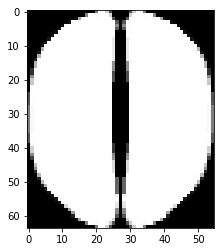

In [ ]:
mask_path = Utils.get_path(['02_autoencoder'], 'mask.png')
mask = imread(mask_path, as_grey=True)
mask = resize(mask, (h, w), order=5)
plt.imshow(mask, cmap=plt.cm.gray)

mask = torch.from_numpy(mask.astype(np.float32)).to(device)

In [ ]:
path_training = Utils.get_path(['02_autoencoder', 'training_data_september'])
valid_size = .08

train_loader, valid_loader = DataLoader.load_training_data(h, w, path_training, valid_size, batch_size)

In [ ]:
model = Autoencoder.VAE(num_latents=64, num_hidden=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

model = Autoencoder.init_weights(model)
model = model.to(device)

In [ ]:
num_epochs = 100

model, losses, val_losses = Autoencoder.train_model(model, num_epochs, batch_size, optimizer, train_loader, valid_loader, h, w, device, mask, model_path)

Utils.save_object(model_path + "losses.dill")

99_155 - train:5206.34, val:5206.99, beta:0.10

Visualize:

In [ ]:
model = Autoencoder.load_model(vae_num_latents=64, vae_num_hidden=128, path=model_path)
model = model.to(device)

In [ ]:
losses = Utils.load_object(model_path + "losses.dill")
val_losses = Utils.load_object(model_path + "val_losses.dill")

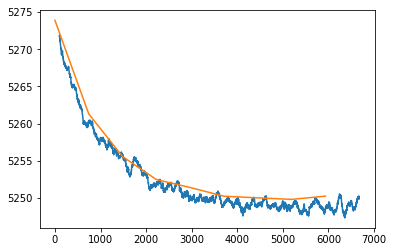

In [ ]:
batches_per_epoch = np.floor(len(train_loader.sampler.indices) / batch_size)
plt.plot(pd.Series(losses[int(batches_per_epoch):]).rolling(100).mean())
plt.plot(np.arange(len(val_losses) - 1) * batches_per_epoch, val_losses[1:])

# Autoencoder

__Show one example bee view image and the processed output image of the trained autoencoder.__

In [ ]:
def show_input_output(model, img_num = -1):
    with torch.no_grad():
        fig=plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 2, 1)    

        if img_num < 0:
            # sample random image from validation set
            img_num = randrange(len(valid_loader.sampler.indices))   

        batch_num = 0

        while batch_num < img_num // batch_size:
            batch_num += 1
            dataiter = iter(valid_loader)

        img, _ = dataiter.next()

        npimg = img[img_num % batch_size].numpy()    
        ax.imshow(np.transpose(npimg, (1, 2, 0)))

        img = img.to(device)
        xhat, xhat_logits, mu, logvar = model.forward(img) 
        img = xhat[img_num % batch_size].cpu().detach()

        ax = fig.add_subplot(1, 2, 2)    
        npimg = img.numpy()    

        # normalize output of autoencoder to values between 0 and 1
        npimg += (-1 * np.amin(npimg))
        npimg /= np.amax(npimg)

        ax.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)

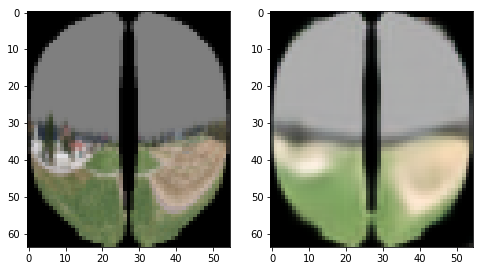

In [ ]:
show_input_output(model, img_num = 200)

__Show the number of activation maps and size of activation map for each layer of the autoencoder:__

In [ ]:
bee_view_image_path = Utils.get_path(["flights", "flight_2018_09_03#1", "bee_eye"])

model_loader = ModelLoader(Autoencoder, model_path, bee_view_image_path, batch_size = batch_size,
                           image_height = int(262 // 4.05), image_width = int(226 // 4.05))

for i_batch, (xb, yb) in enumerate(model_loader.data_loader):    
    xbd = xb.data
        
    with torch.no_grad():
        model_loader.model.eval()
        
        xr = xbd.to(model_loader.device)
        
        print("Input size: ", xr[0, 0].cpu().data.numpy().shape)
        print()

        for ii, layer in enumerate(model_loader.model.encoder):
            xr = layer(xr)
            
            print("Layer: ", ii)
            print("   Activation maps: ", xr.shape[1])
            print("   Size: ", xr[0, 0].cpu().data.numpy().shape)
            
        z_flat = xr.view(-1, model_loader.model.num_hidden * 4 * 4)
        xr = model_loader.model.to_latent(z_flat)
        
        print()
        print("Latent: ", xr.cpu().data.numpy().shape)
        print()
        
        z_mu = xr[:, :model_loader.model.num_latents]
        z_logvar = xr[:, model_loader.model.num_latents:]
        z = model_loader.model.reparameterize(z_mu, z_logvar)        
        
        print(z.cpu().data.numpy().shape)
        
        z_flat = model_loader.model.from_latent(z)
        z_conv = z_flat.view(-1, model_loader.model.num_hidden, 4, 4)
        
        print()
        print("Latent: ", z_conv[0,0].cpu().data.numpy().shape)
        print()
        
        xr = z_conv
        
        for ii, layer in enumerate(model_loader.model.decoder):
            xr = layer(xr)
            
            print("Layer: ", ii)
            print("   Activation maps: ", xr.shape[1])
            print("   Size: ", xr[0, 0].cpu().data.numpy().shape)
            
    break

Input size:  (64, 55)

Layer:  0
   Activation maps:  8
   Size:  (64, 55)
Layer:  1
   Activation maps:  8
   Size:  (64, 55)
Layer:  2
   Activation maps:  8
   Size:  (32, 28)
Layer:  3
   Activation maps:  8
   Size:  (32, 28)
Layer:  4
   Activation maps:  16
   Size:  (32, 28)
Layer:  5
   Activation maps:  16
   Size:  (32, 28)
Layer:  6
   Activation maps:  16
   Size:  (16, 14)
Layer:  7
   Activation maps:  16
   Size:  (16, 14)
Layer:  8
   Activation maps:  32
   Size:  (16, 14)
Layer:  9
   Activation maps:  32
   Size:  (16, 14)
Layer:  10
   Activation maps:  32
   Size:  (8, 7)
Layer:  11
   Activation maps:  32
   Size:  (8, 7)
Layer:  12
   Activation maps:  64
   Size:  (8, 7)
Layer:  13
   Activation maps:  64
   Size:  (8, 7)
Layer:  14
   Activation maps:  64
   Size:  (4, 4)
Layer:  15
   Activation maps:  64
   Size:  (4, 4)
Layer:  16
   Activation maps:  128
   Size:  (4, 4)
Layer:  17
   Activation maps:  128
   Size:  (4, 4)

Latent:  (128, 128)

(128, 64)



# Prepare Correlation

In [ ]:
bee_view_image_path = Utils.get_path(["flights", "flight_2018_09_03#1", "bee_eye"])

model_loader = ModelLoader(Autoencoder, model_path, bee_view_image_path, batch_size = batch_size,
                           image_height = int(262 // 4.05), image_width = int(226 // 4.05))

### Save all activations in one frame

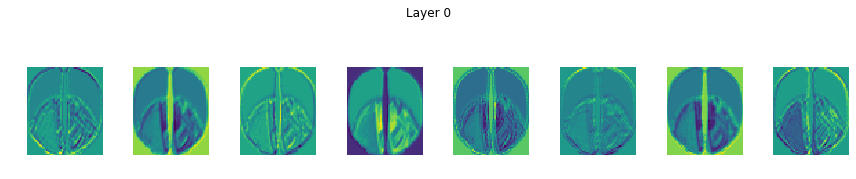

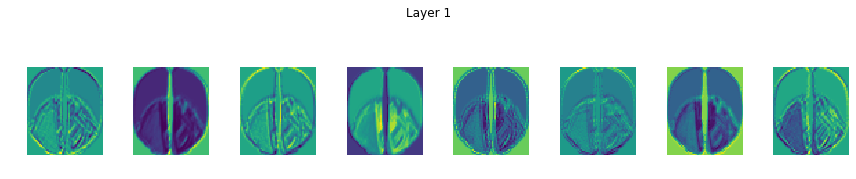

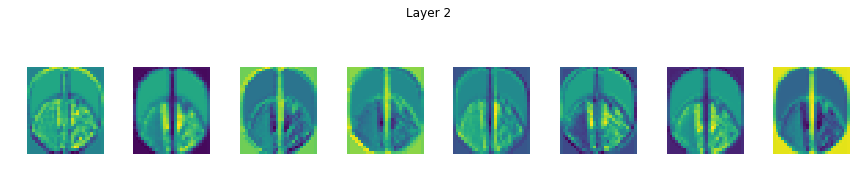

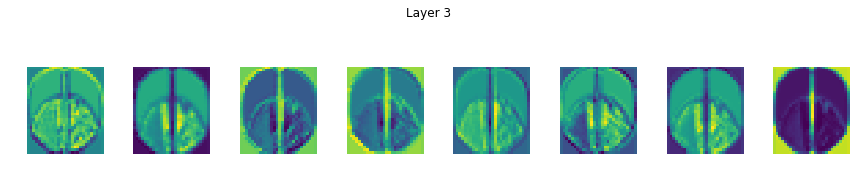

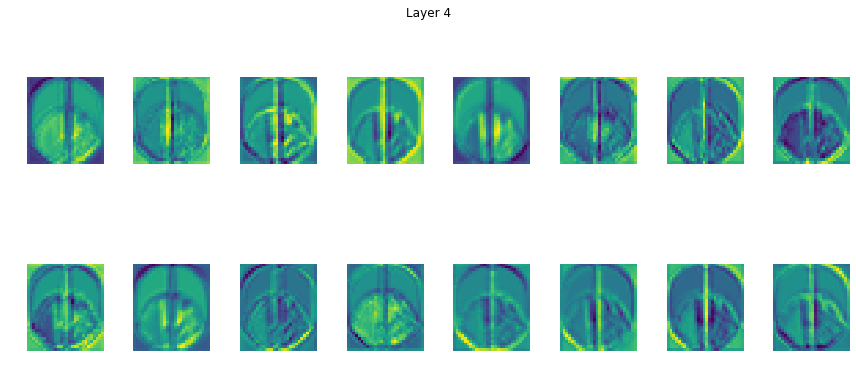

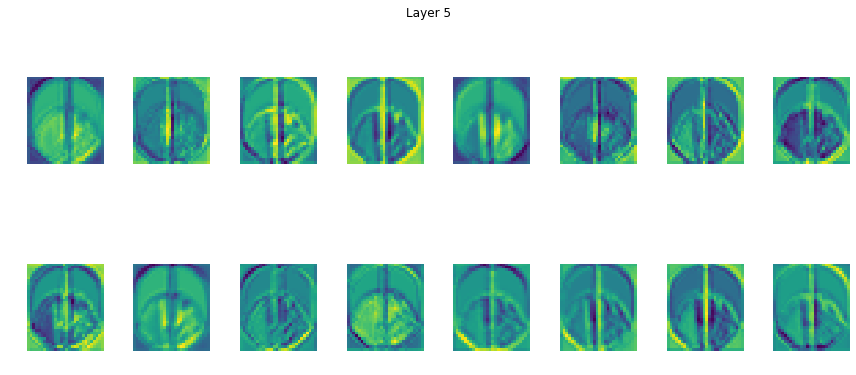

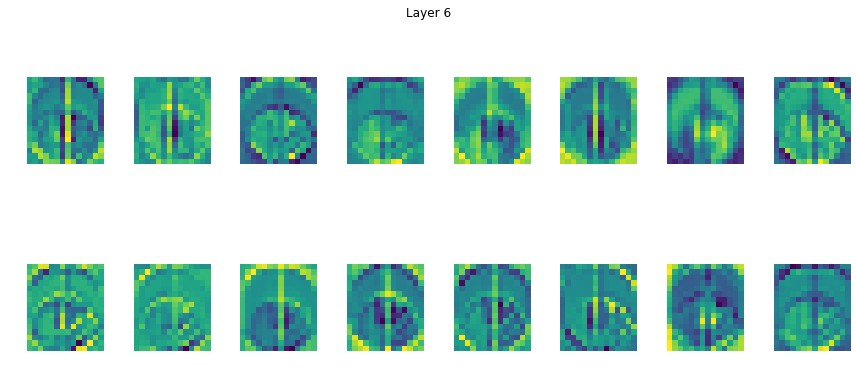

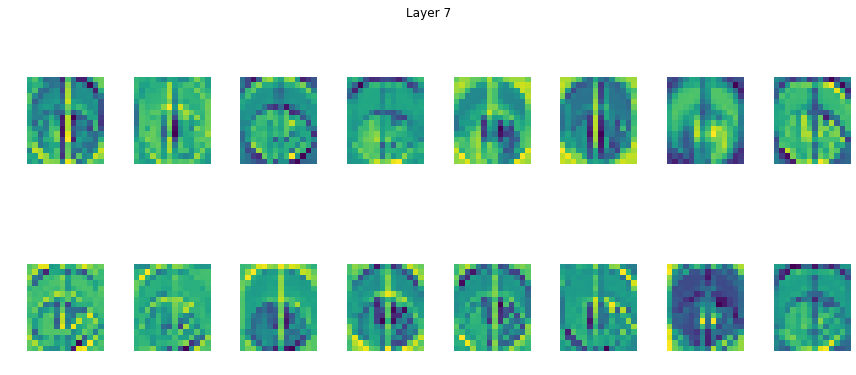

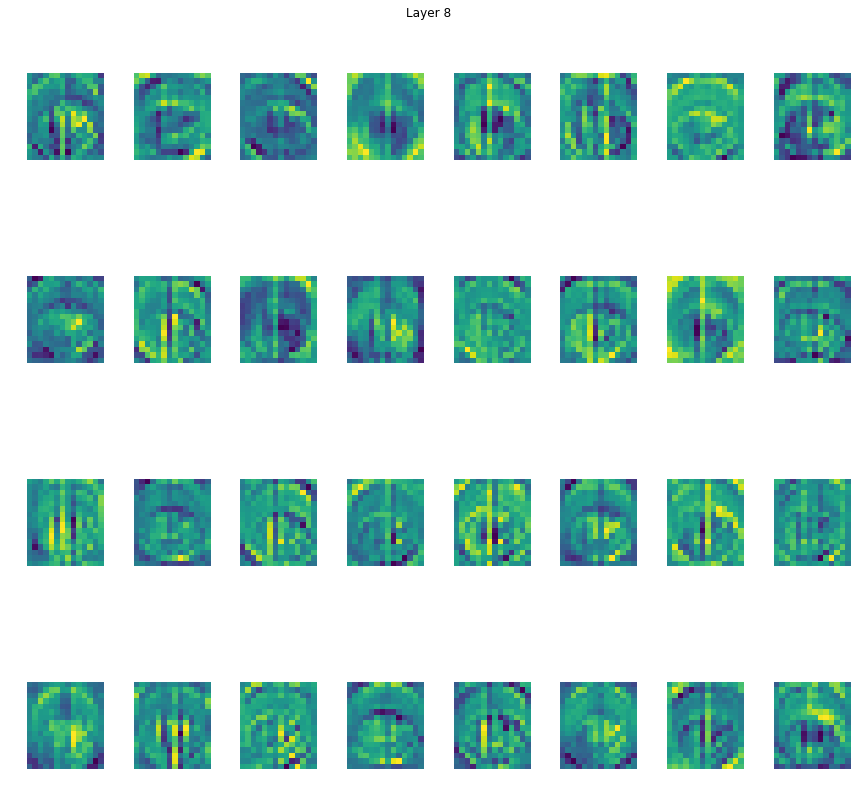

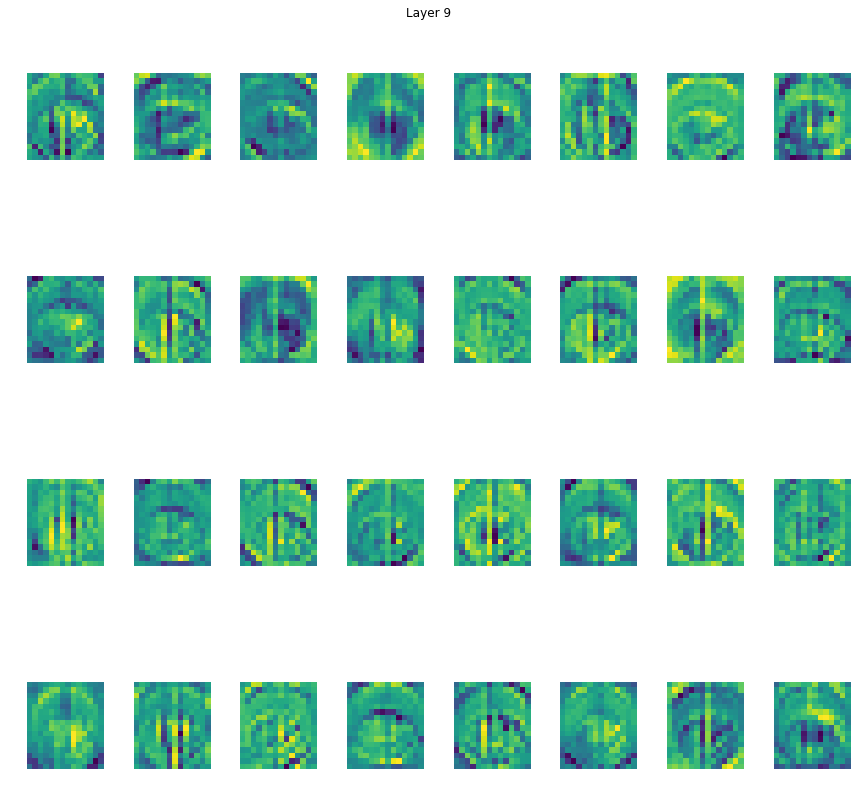

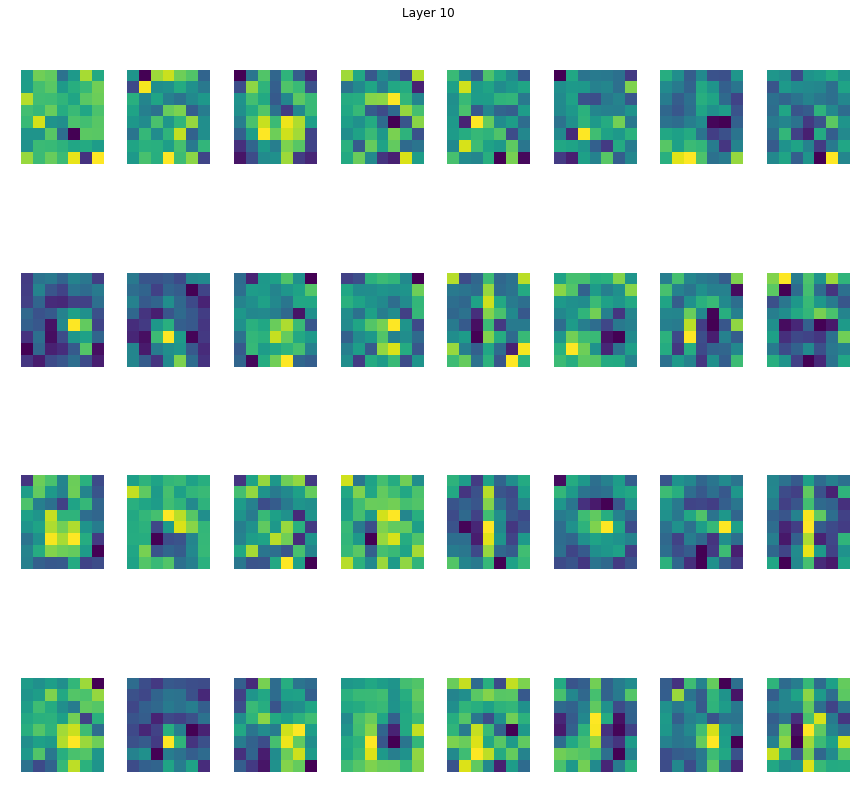

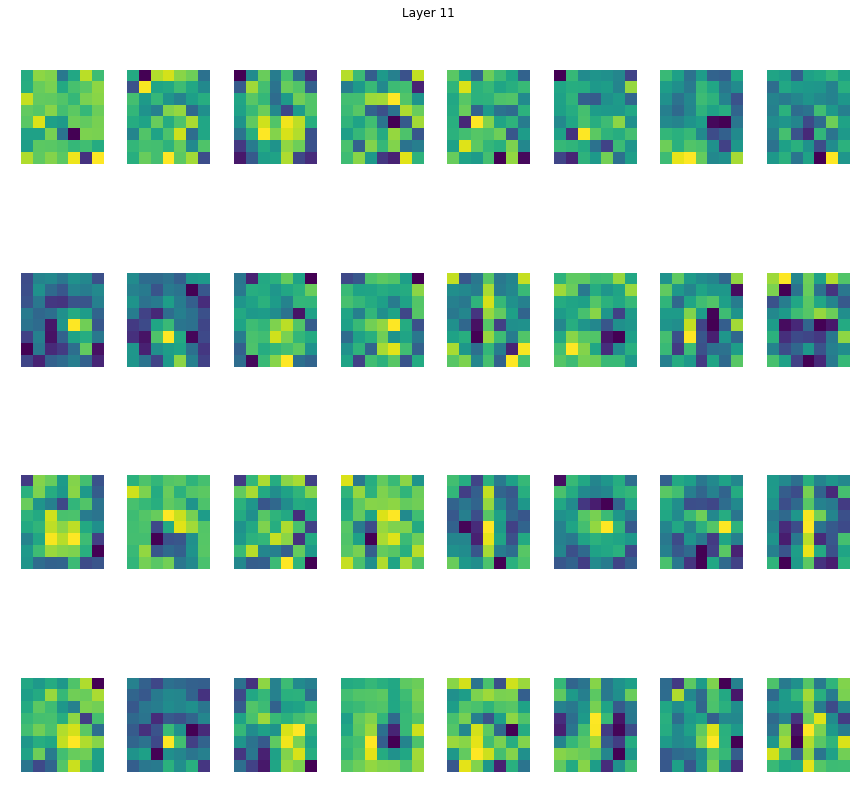

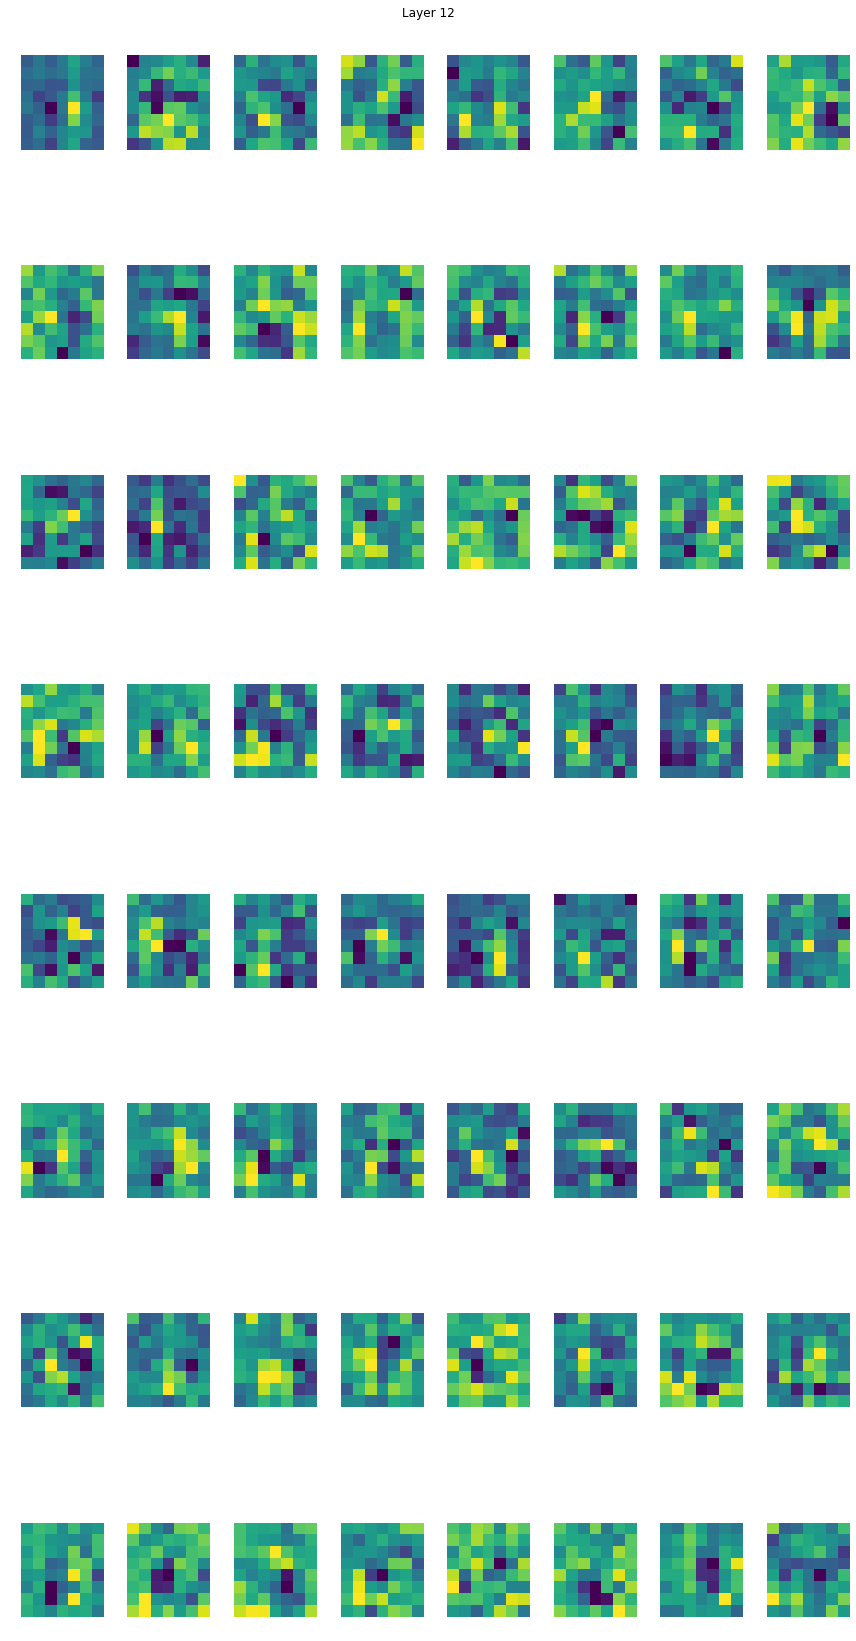

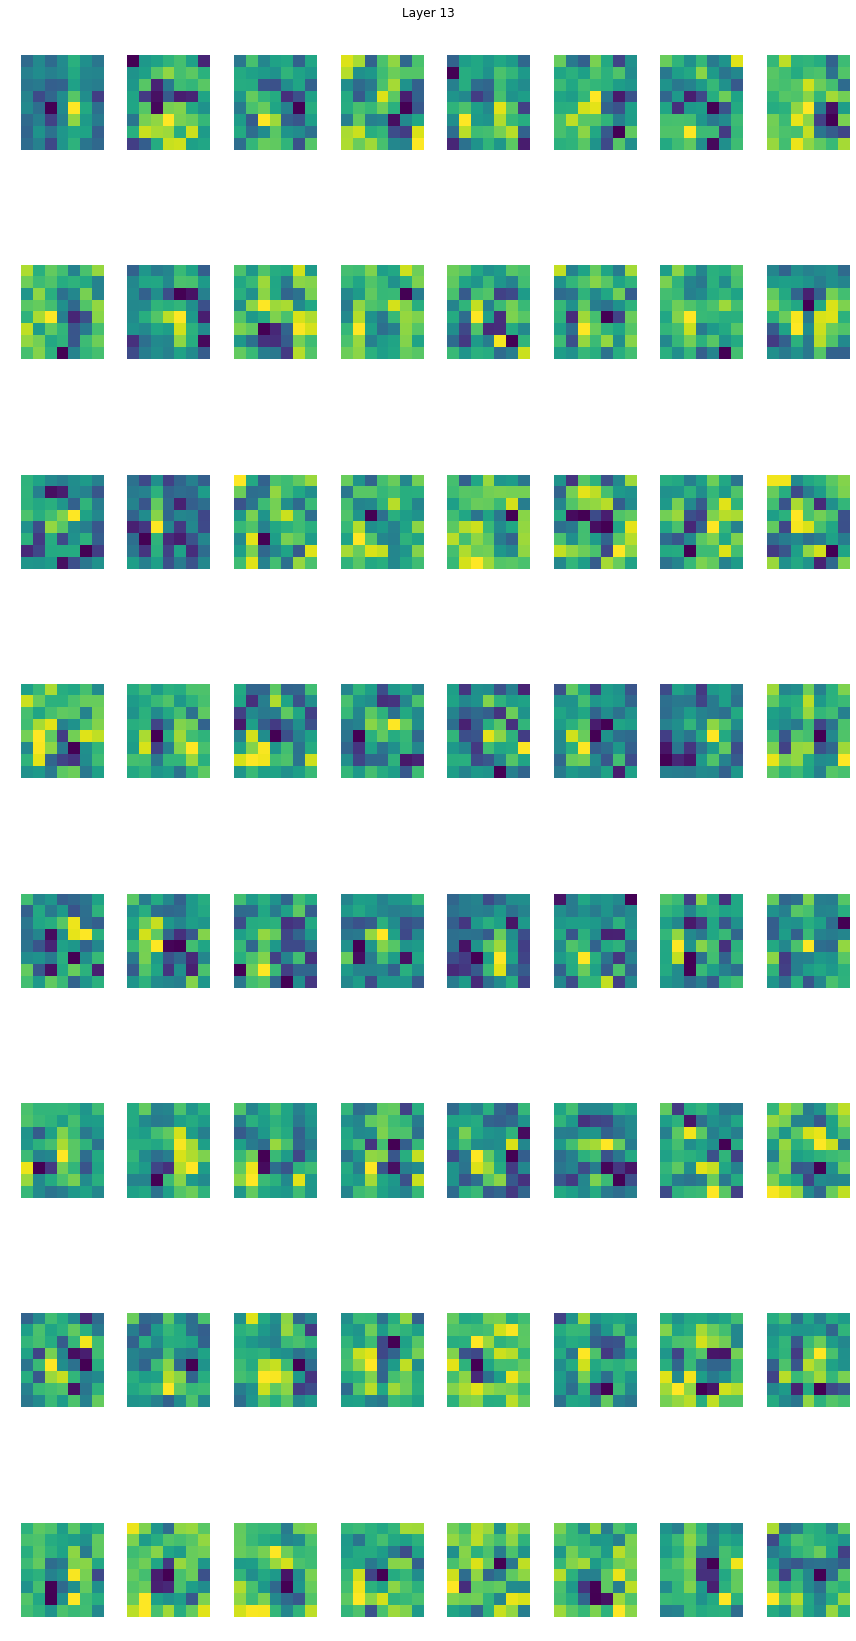

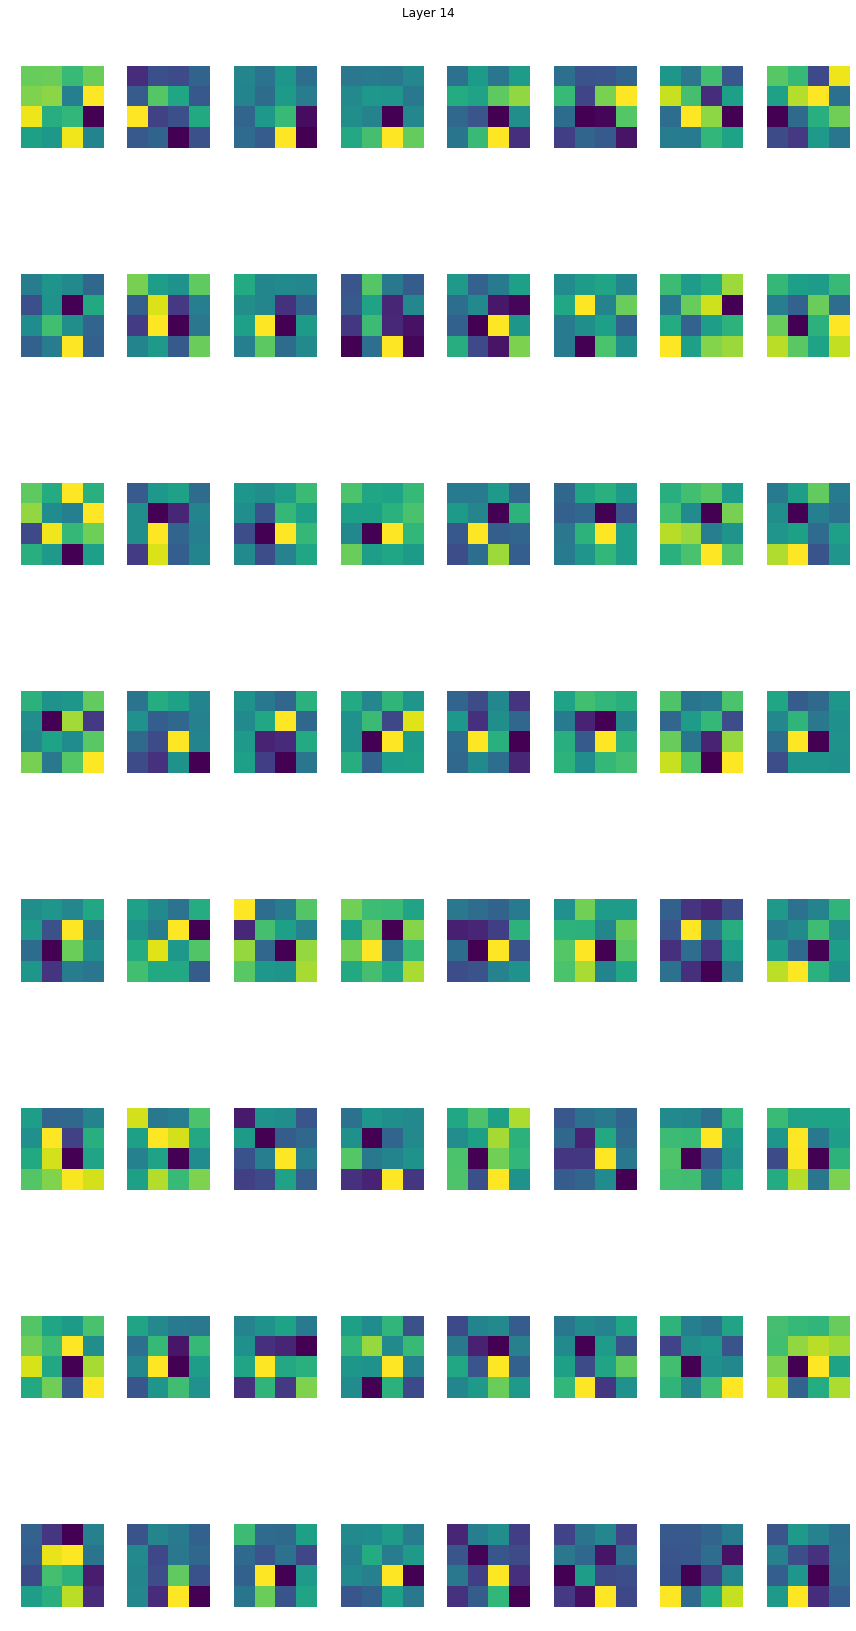

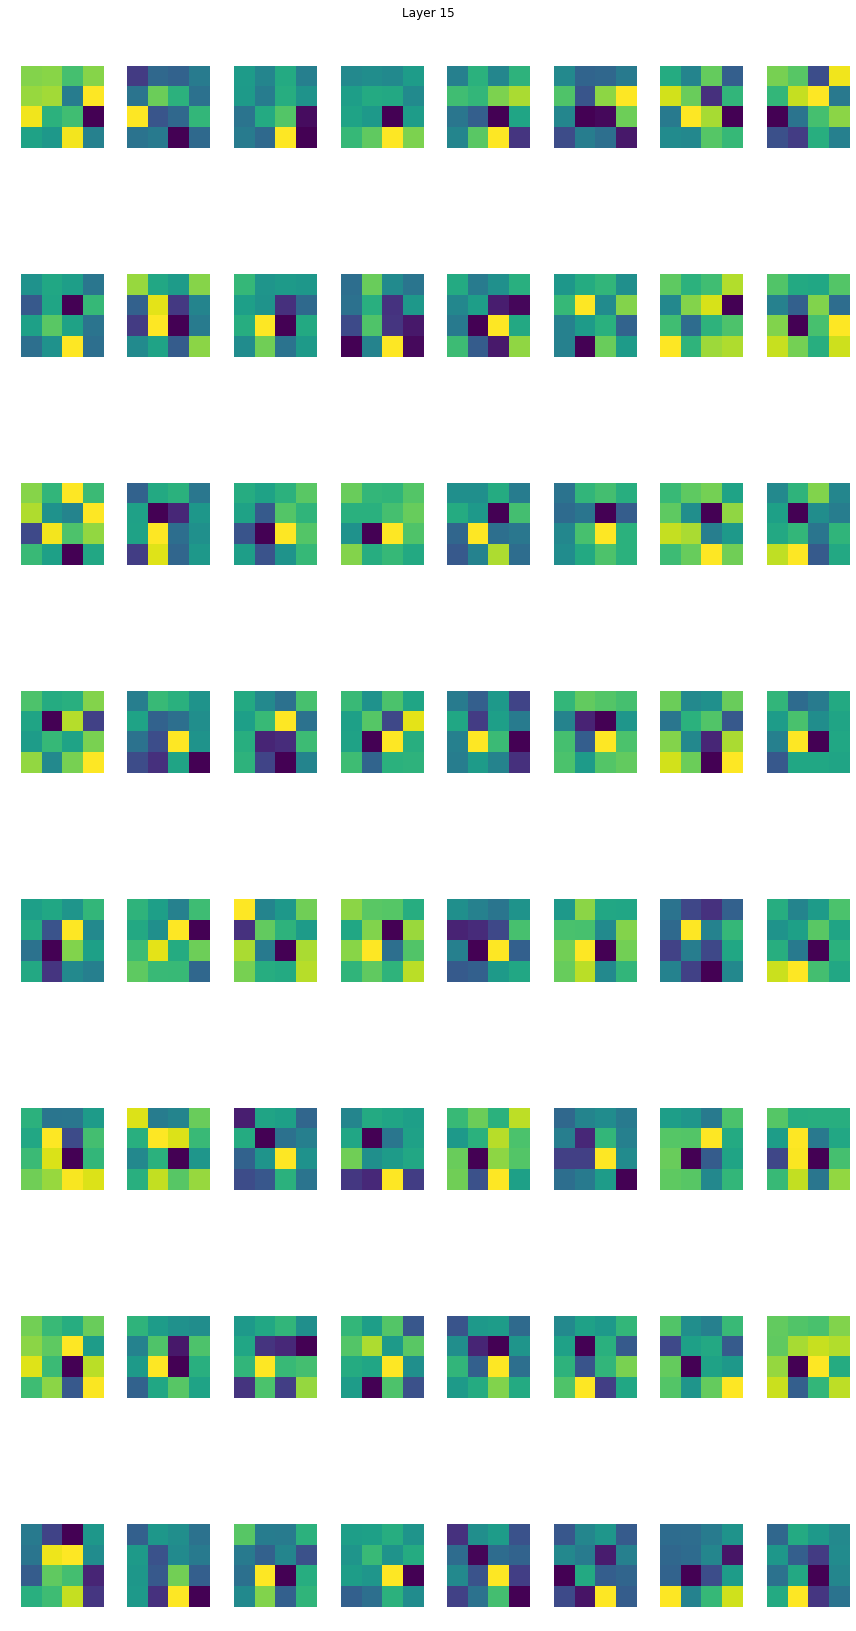

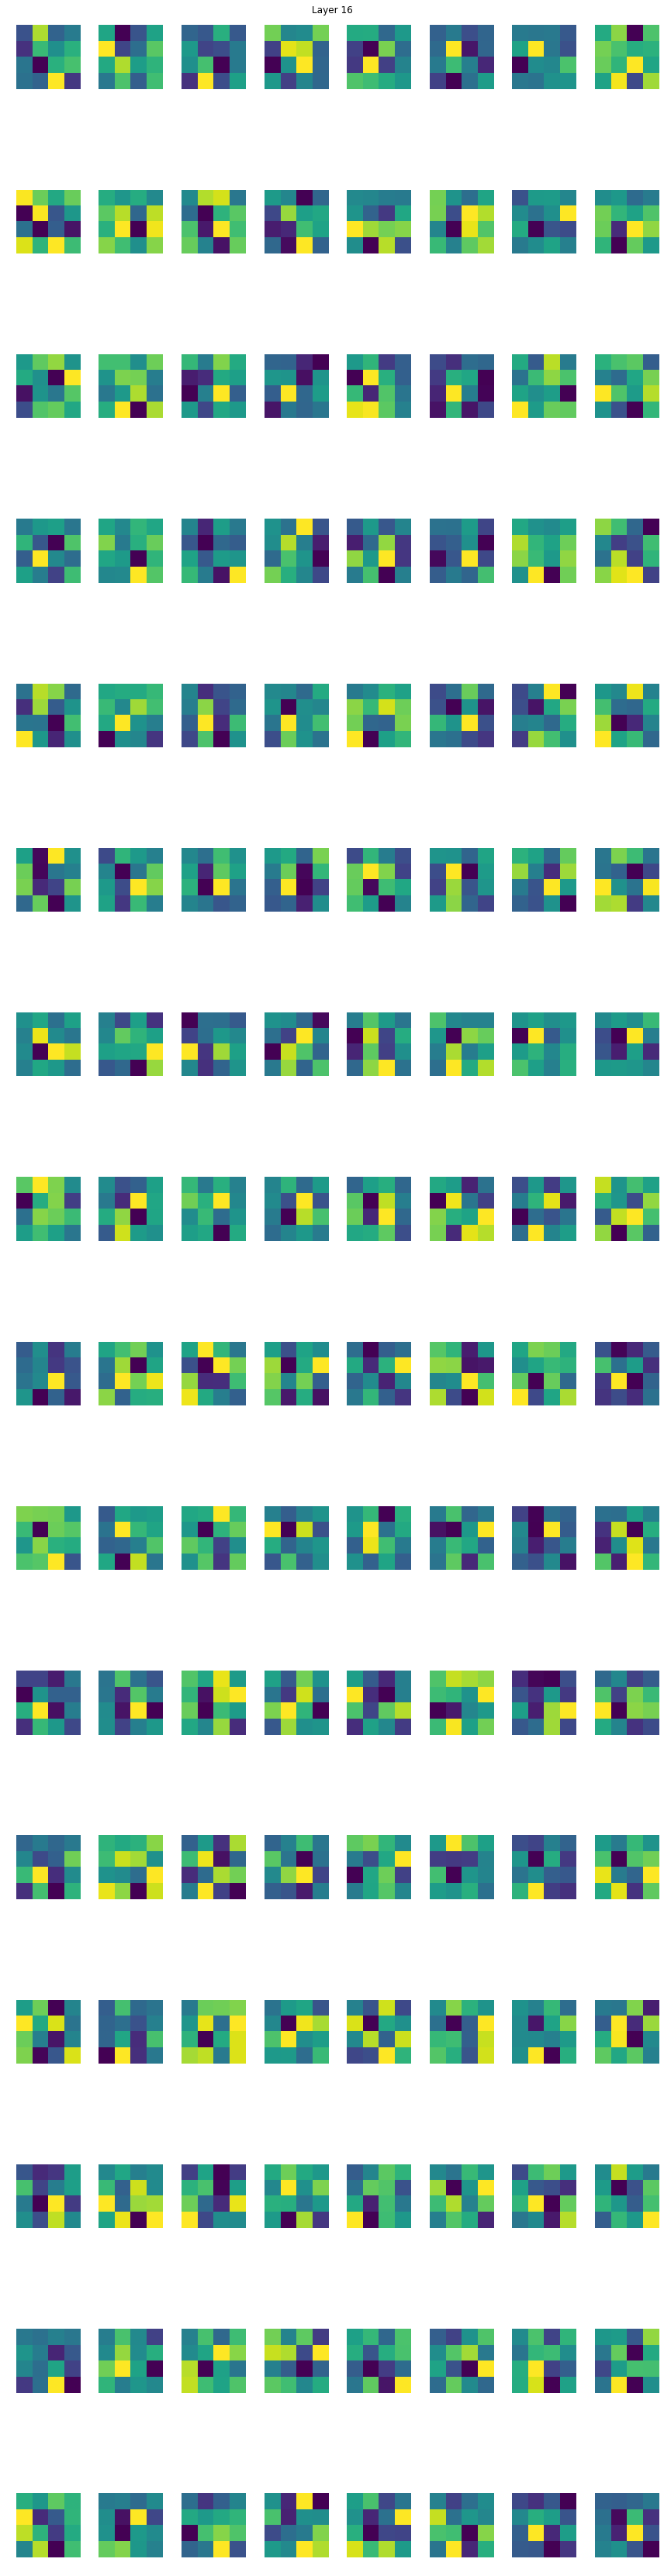

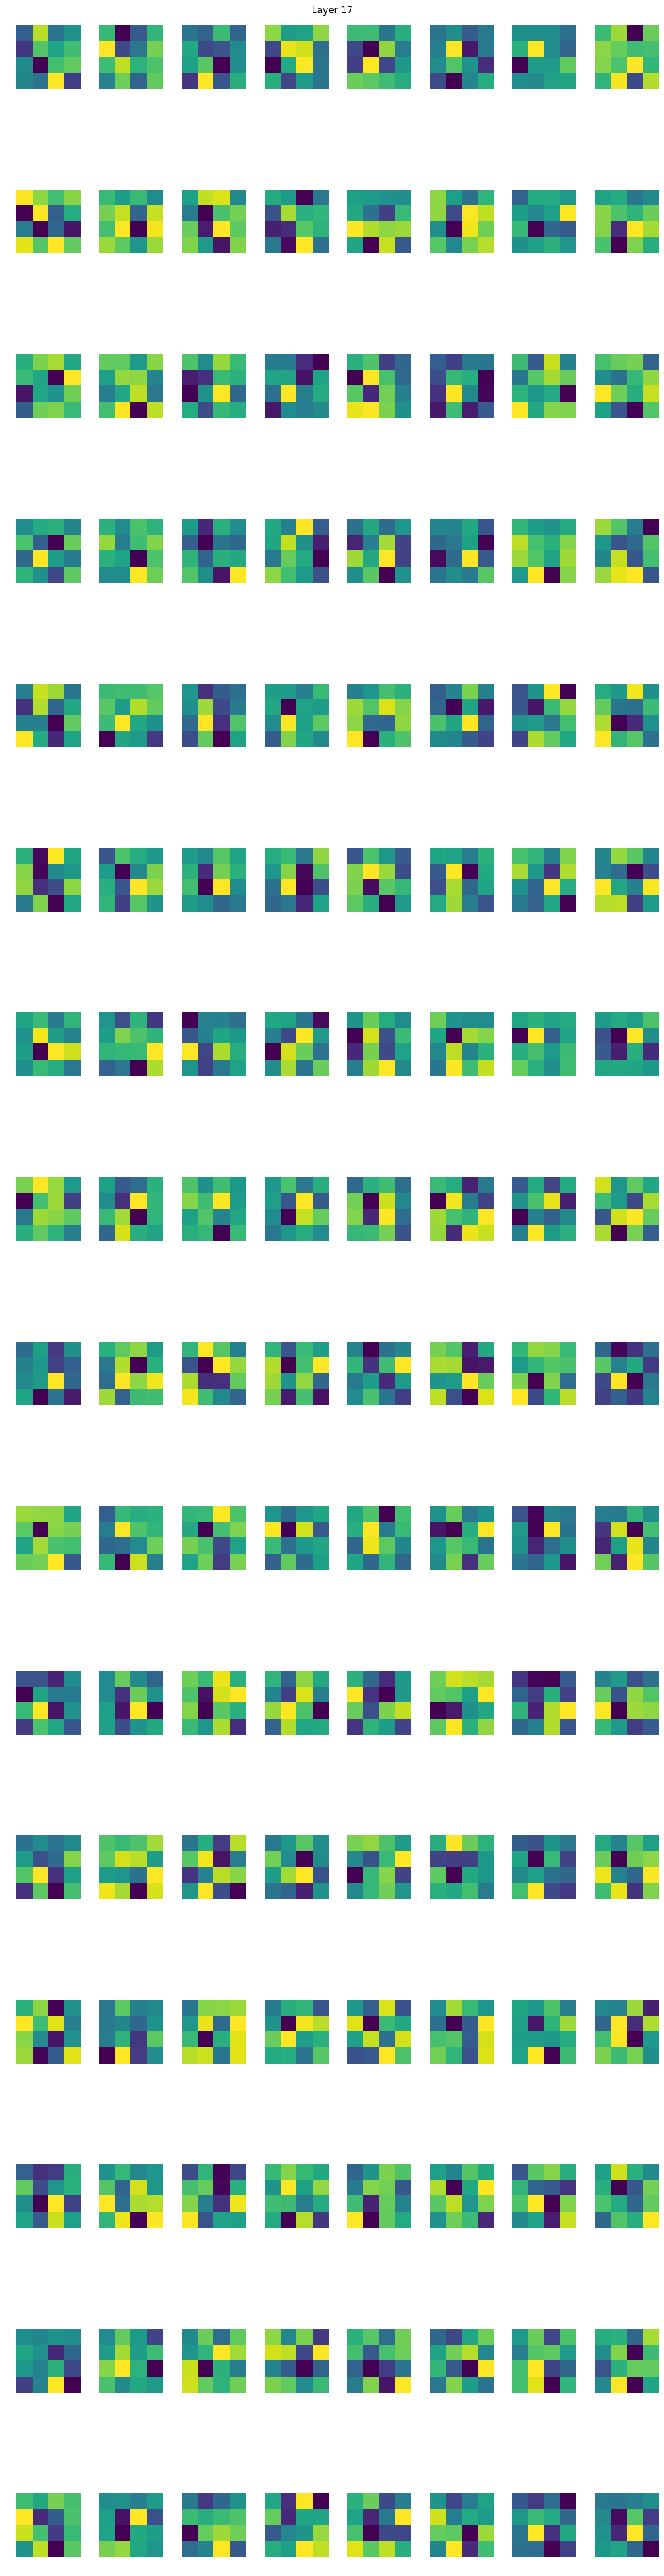

In [ ]:
Visualizer.show_all_activations(model_loader, frame_num=50)

### Save activations of layers 4, 8 and 12 in all frames

In [ ]:
path = Utils.get_path(["02_autoencoder", "results", "activations"], "")
Visualizer.save_activations_in_all_frames(model_loader, path)

Batch: 48

### Load all activations as time series

In [ ]:
activations = DataLoader.load_activations(model_loader)

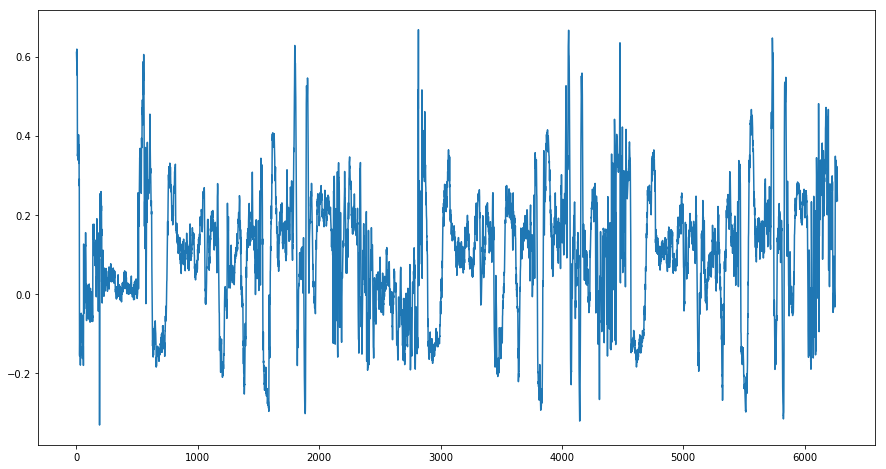

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(activations[2][5, 20, 20])  # layer 2, activation 5, row 20, column 20
plt.show()

### Load spike rate

In [ ]:
csv_file_path = Utils.get_path(['flights', 'flight_2018_09_03#1'],
                              '030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv')

neuro_spikes = DataLoader.load_neuro_data(model_loader, csv_file_path, spike_type_row = 8, start_frame = 600)

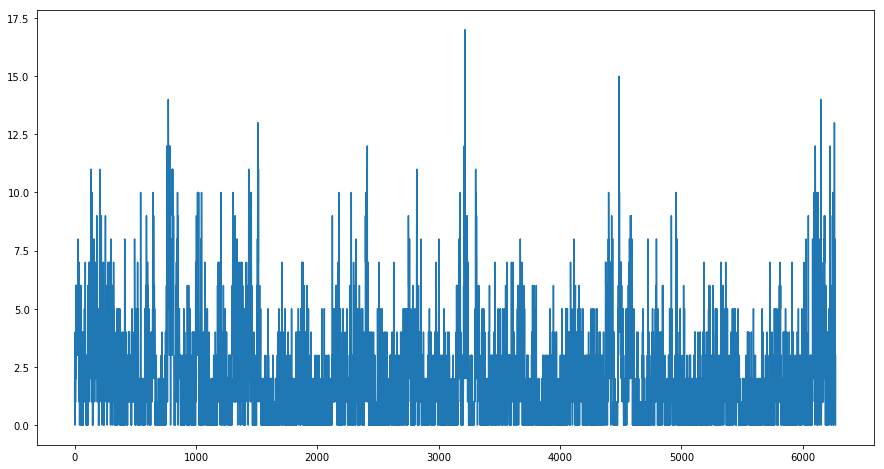

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(neuro_spikes)
plt.show()

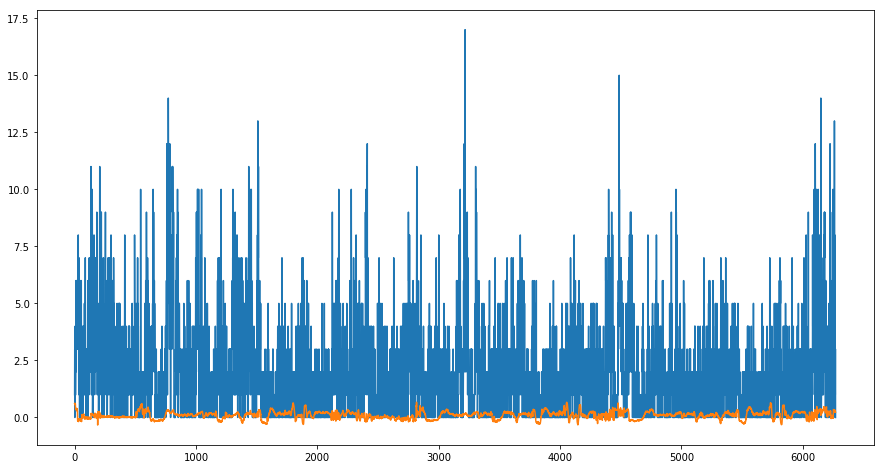

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(neuro_spikes)
plt.plot(activation_neurons[2][5, 20, 20])
plt.show()

# Correlate activations with neuro data

__Correlate neural spikes with activations of the autoencoder. First, activations with maximum pearson and spearman correlations are visualized over the whole flight. In subsequent sections, smaller sections of both series are correlated. 'Global analysis' examines correlations between neural spikes and activations during flight rounds while 'Local analysis' correlates in even smaller time windows.__

In [ ]:
corrs = Correlation.correlate(activations, neuro_spikes)
corrs_sorted_pearson = sorted(corrs, key=lambda x: x.pearson)
corrs_sorted_spearman = sorted(corrs, key=lambda x: x.spearman)

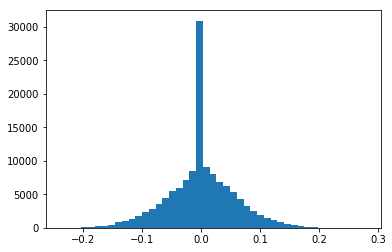

Pearson mean: 0.0010467610539401104, std: 0.056474402786705236


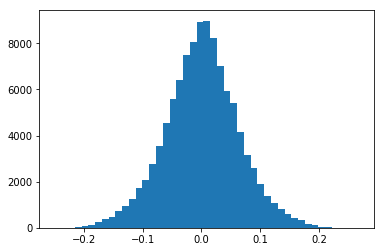

Spearman mean: 0.0009566976072764769, std: 0.06207629406048591


In [ ]:
corrs_pearson = [c.pearson for c in corrs if not math.isnan(c.pearson)]
corrs_spearman = [c.spearman for c in corrs if not math.isnan(c.spearman)]

plt.hist(corrs_pearson, bins=45)
plt.show()

print("Pearson mean: {}, std: {}".format(np.mean(corrs_pearson), np.std(corrs_pearson)))

plt.hist(corrs_spearman, bins=45)
plt.show()

print("Spearman mean: {}, std: {}".format(np.mean(corrs_spearman), np.std(corrs_spearman)))

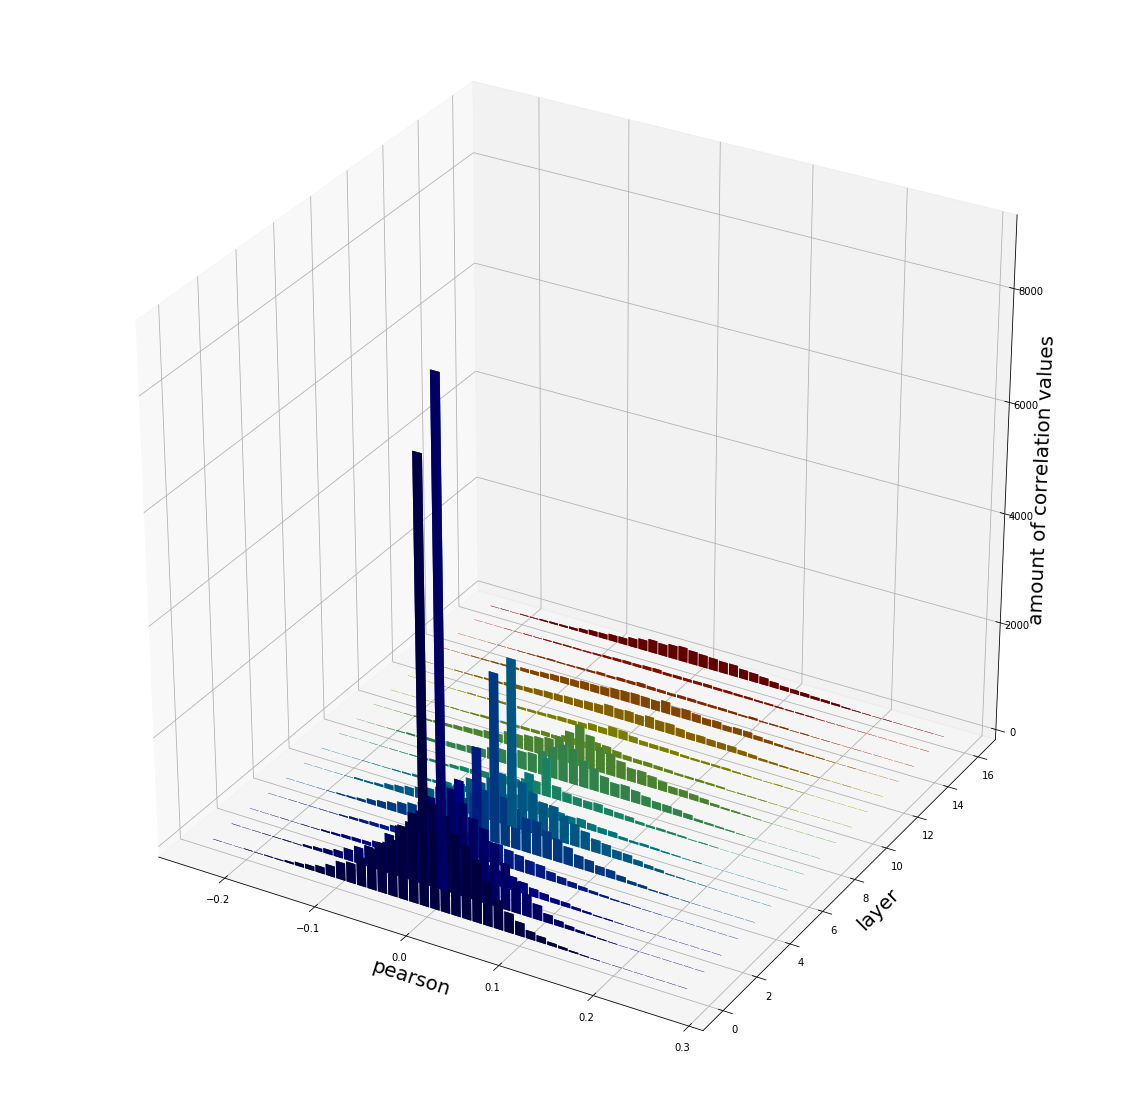

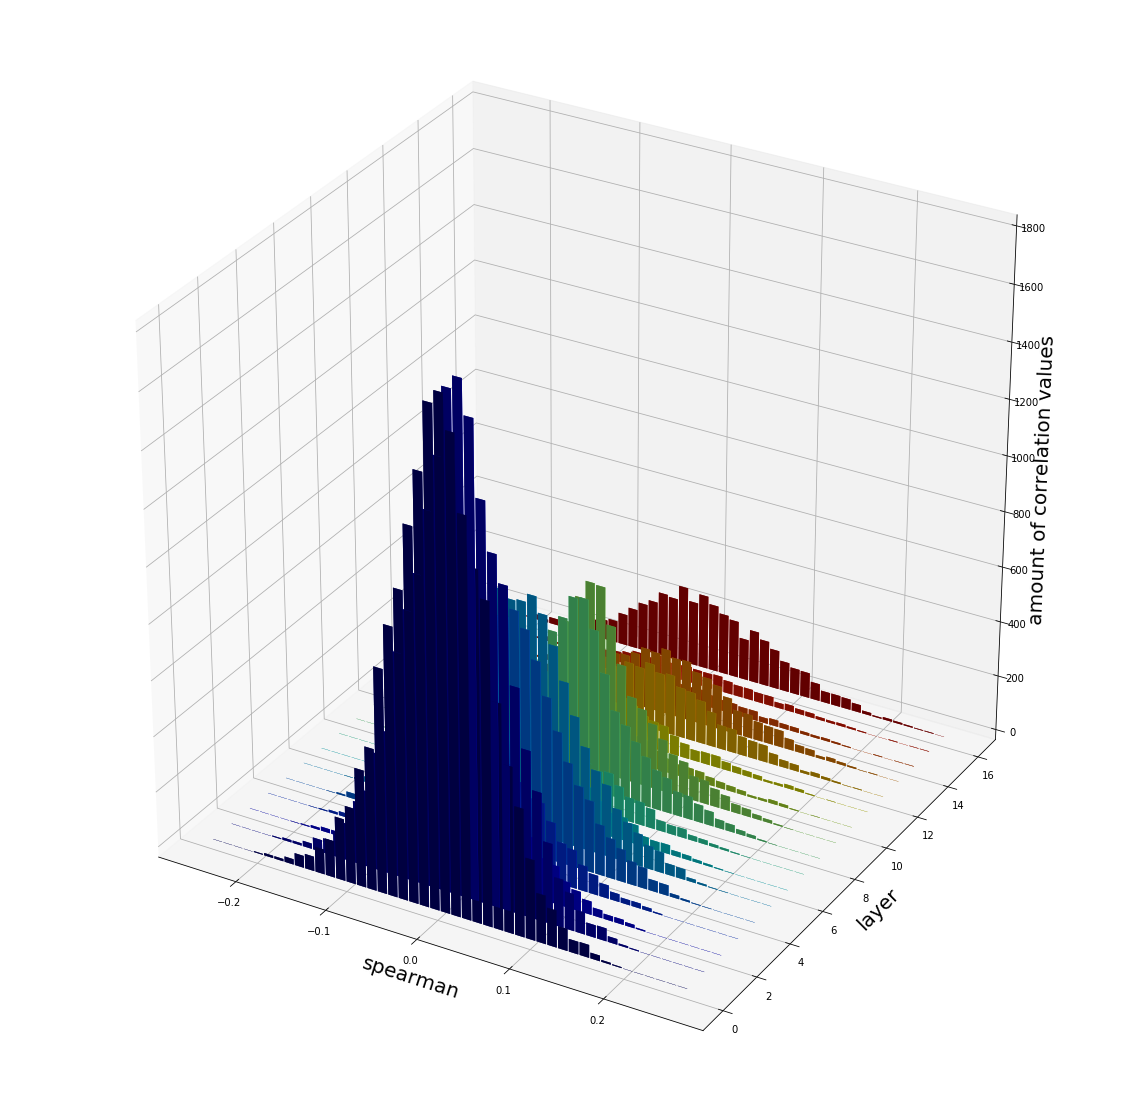

In [ ]:
h1 = Visualizer.hist3d(corrs, bins = 45, pearson = True)    
h2 = Visualizer.hist3d(corrs, bins = 45, pearson = False)

Utils.add_fig_to_image(h1)
Utils.add_fig_to_image(h2)
Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"], "3d_hist.png"), show_image = False,
                          combine_vertical = False)

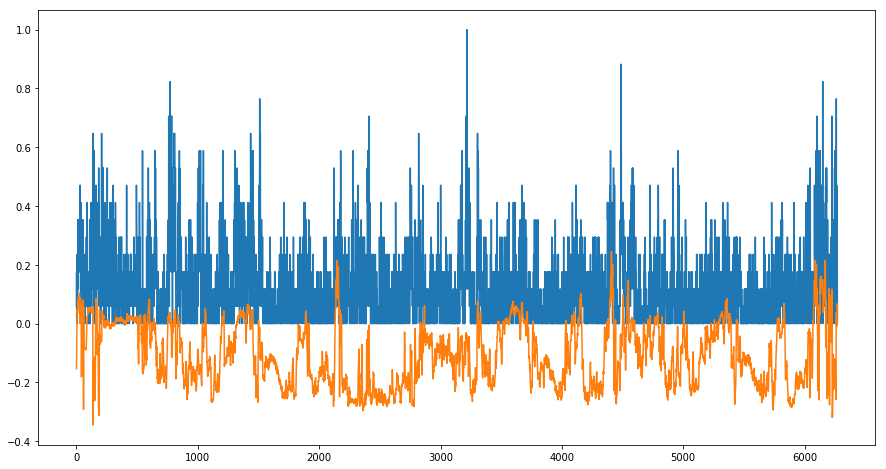

(0.2786243580424211, 3.4110929274170526e-112)


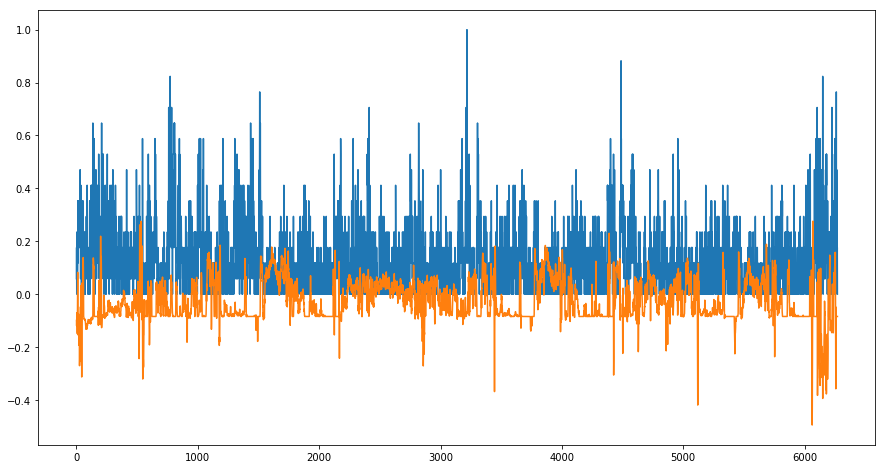

(-0.1987133374592666, 7.097199377796172e-57)


In [ ]:
max_activation = corrs_sorted_pearson[len(corrs_sorted_pearson) - 1].get_activation_series(activations)
min_activation = corrs_sorted_pearson[0].get_activation_series(activations)

neuro_spikes_norm = neuro_spikes / np.max(neuro_spikes)

Visualizer.plot([neuro_spikes_norm, max_activation])
print(Correlation.correlate_series(neuro_spikes_norm, max_activation))

Visualizer.plot([neuro_spikes_norm, min_activation])
print(Correlation.correlate_series(neuro_spikes_norm, min_activation))

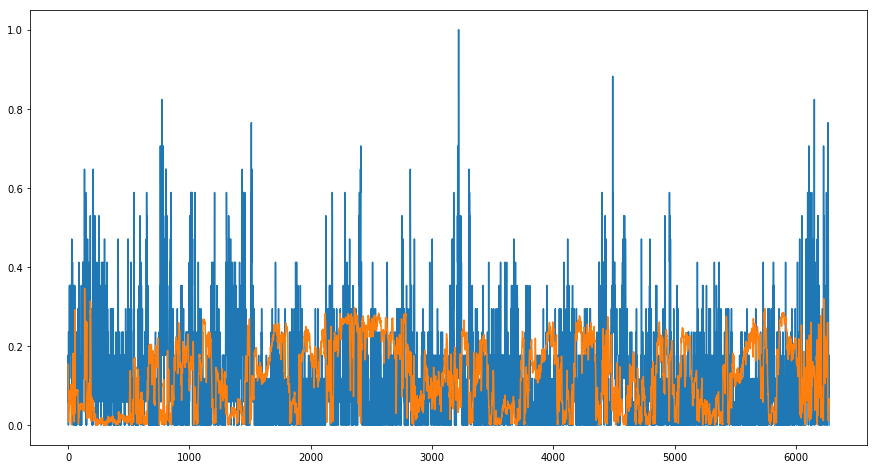

(-0.24001633144103549, 6.889563695842276e-83)


In [ ]:
Visualizer.plot([neuro_spikes_norm, np.abs(max_activation)])
print(Correlation.correlate_series(neuro_spikes_norm, np.abs(max_activation)))

## Global analysis (of each round)

__Correlate neuro spikes and activations per flight round. Shows a histogram of the distribution of correlations and the graph of activations with maximum correlation values.__

In [ ]:
start_round_frames = [630, 2900, 4580]
end_round_frames = [2120, 4370, 6050]

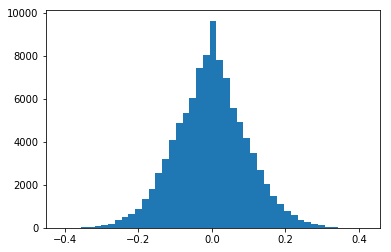

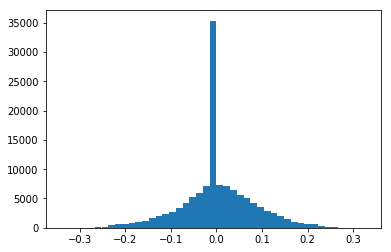

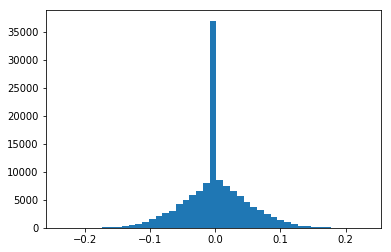

In [ ]:
corrs_round_1 = Correlation.correlate(activations, neuro_spikes, start_round_frames[0], end_round_frames[0])
corrs_round_2 = Correlation.correlate(activations, neuro_spikes, start_round_frames[1], end_round_frames[1])
corrs_round_3 = Correlation.correlate(activations, neuro_spikes, start_round_frames[2], end_round_frames[2])

corrs_round_1_without_nan = [c.pearson for c in corrs_round_1 if not math.isnan(c.pearson) and c.pearson != 0]
corrs_round_2_without_nan = [c.pearson for c in corrs_round_2 if not math.isnan(c.pearson) and c.pearson != 0]
corrs_round_3_without_nan = [c.pearson for c in corrs_round_3 if not math.isnan(c.pearson) and c.pearson != 0]

plt.hist(corrs_round_1_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_2_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_3_without_nan, bins=45)
plt.show()

In [ ]:
max_pearson_round_1 = max(corrs_round_1, key=attrgetter('pearson'))
max_pearson_round_2 = max(corrs_round_2, key=attrgetter('pearson'))
max_pearson_round_3 = max(corrs_round_3, key=attrgetter('pearson'))

max_pearson_round_1.get_infos(), max_pearson_round_2.get_infos(), max_pearson_round_3.get_infos()

('layer 15, activation 12, row 1, column 2, pearson 0.41732189192650576, spearman 0.39507808890705076',
 'layer 6, activation 4, row 7, column 11, pearson 0.32647217169595993, spearman 0.23258170105311662',
 'layer 5, activation 5, row 18, column 3, pearson 0.23011006345712523, spearman 0.2059451043979412')

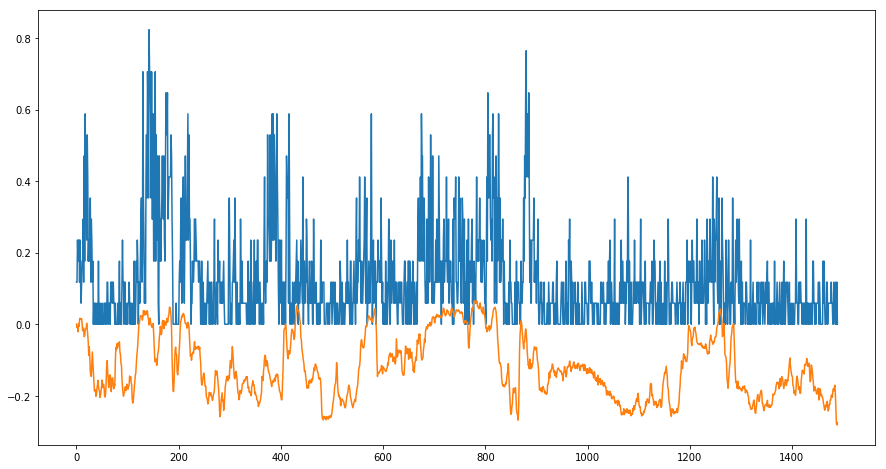

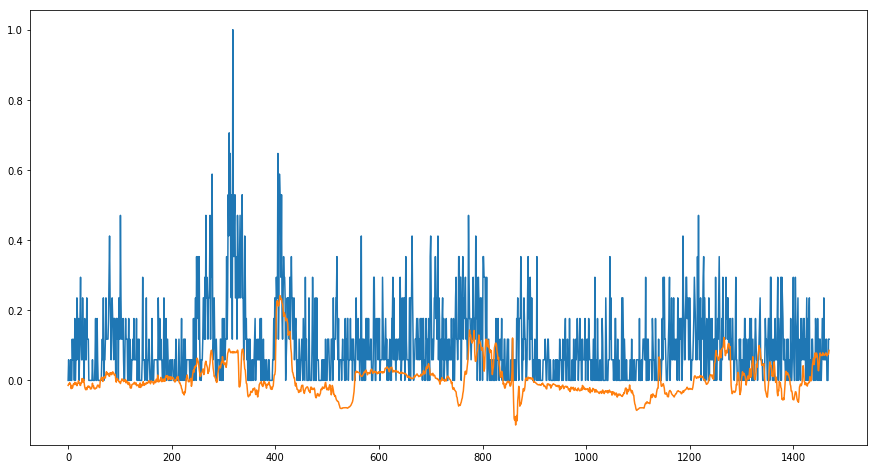

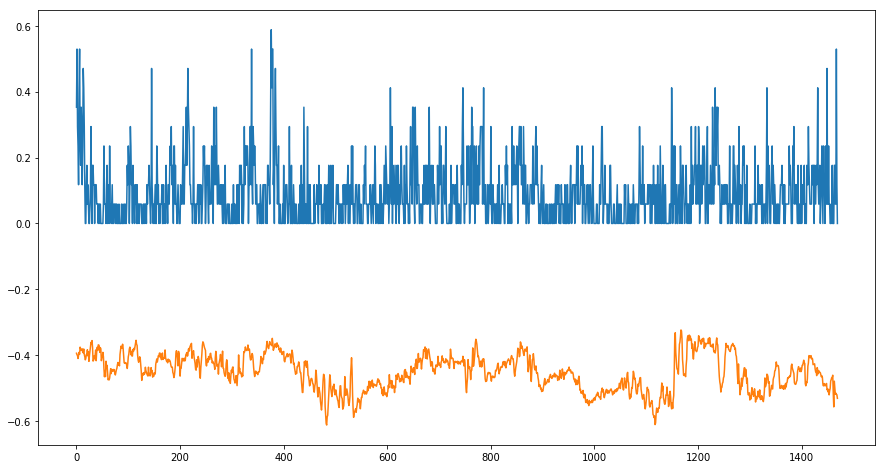

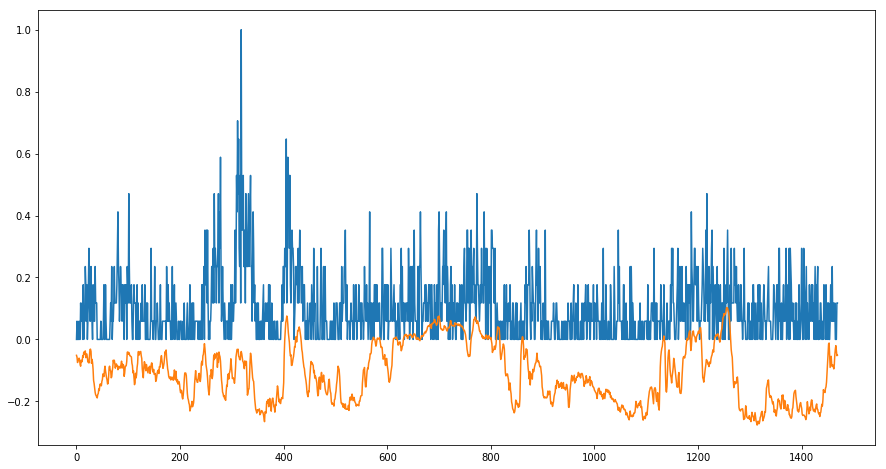

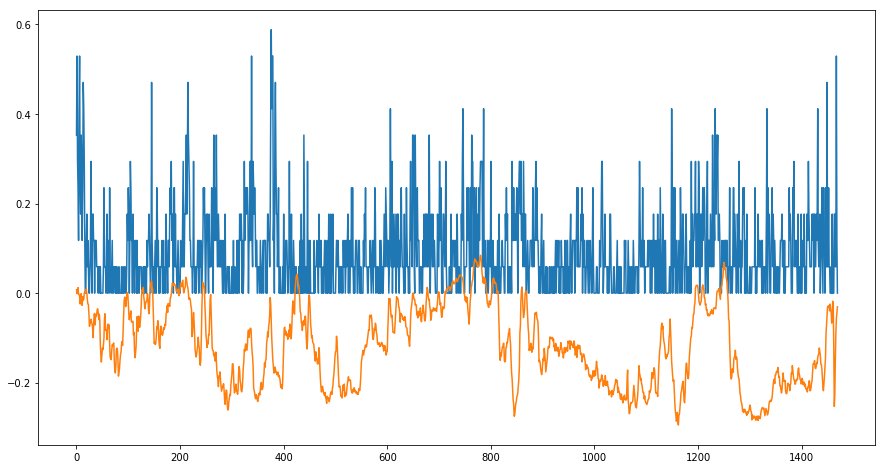

In [ ]:
max_activation_round_1 = max_pearson_round_1.get_activation_series(activations)
max_activation_round_2 = max_pearson_round_2.get_activation_series(activations)
max_activation_round_3 = max_pearson_round_3.get_activation_series(activations)

Visualizer.plot([neuro_spikes_norm, max_activation_round_1], start_round_frames[0], end_round_frames[0])
Visualizer.plot([neuro_spikes_norm, max_activation_round_2], start_round_frames[1], end_round_frames[1])
Visualizer.plot([neuro_spikes_norm, max_activation_round_3], start_round_frames[2], end_round_frames[2])

Visualizer.plot([neuro_spikes_norm, max_activation_round_1], start_round_frames[1], end_round_frames[1])
Visualizer.plot([neuro_spikes_norm, max_activation_round_1], start_round_frames[2], end_round_frames[2])

Visualize the location of high correlated activations in activation maps of the autoencoder during each round:

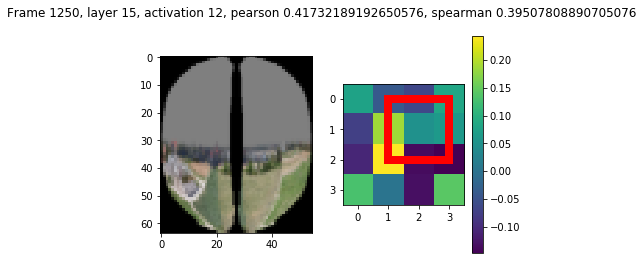

In [ ]:
fig = Visualizer.show_correlation(max_pearson_round_1, 1250, model_loader, model_loader.model.encoder)

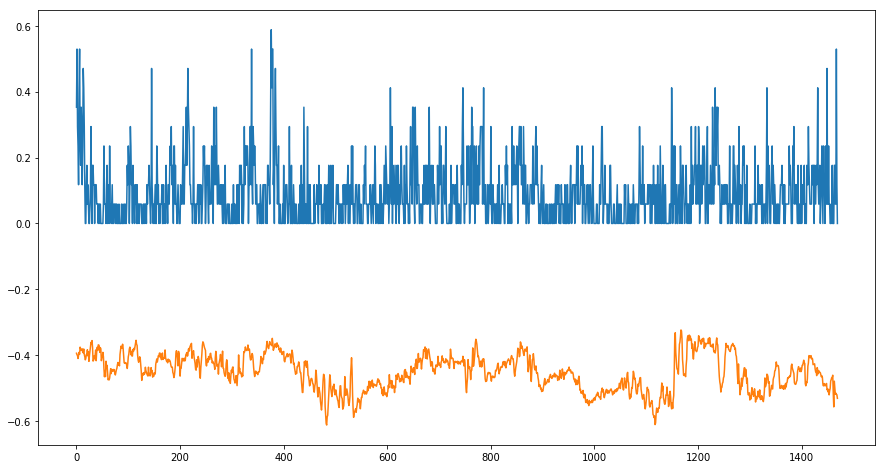

In [ ]:
Visualizer.plot([neuro_spikes_norm, max_activation_round_3], start_round_frames[2], end_round_frames[2])

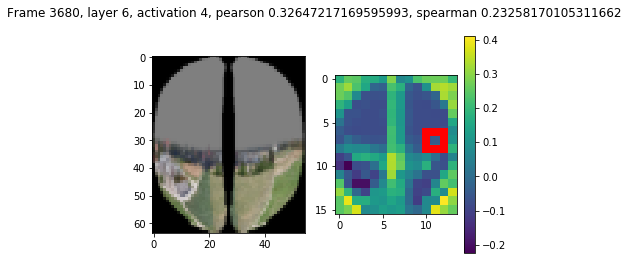

In [ ]:
fig = show_correlation(max_pearson_round_2, start_round_frames[1] + 780,
                       model_loader.data_loader, model_loader.model.encoder)

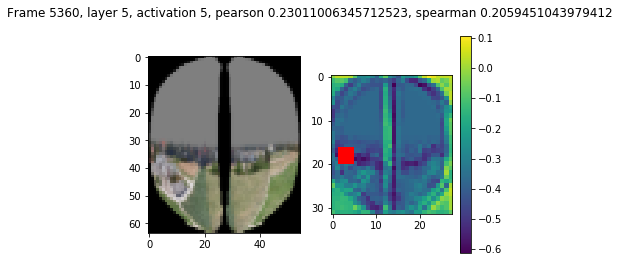

In [ ]:
fig = Visualizer.show_correlation(max_pearson_round_3, start_round_frames[2] + 780,
                                  model_loader, model_loader.model.encoder)

__Same calculations as above but now with Spearman instead of Pearson correlation:__

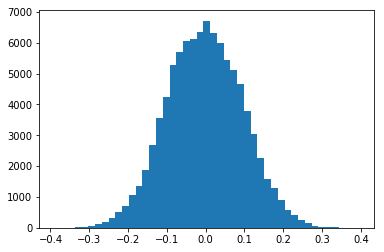

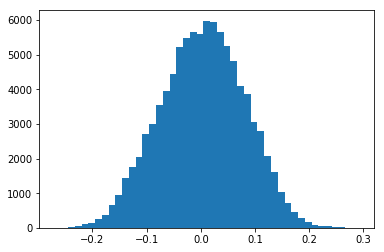

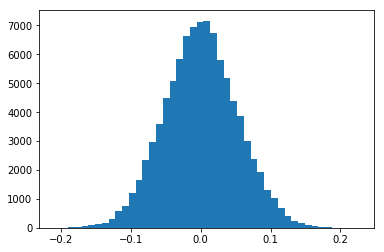

In [ ]:
corrs_round_1_spearman_without_nan = [c.spearman for c in corrs_round_1 if not math.isnan(c.spearman) and c.spearman != 0]
corrs_round_2_spearman_without_nan = [c.spearman for c in corrs_round_2 if not math.isnan(c.spearman) and c.spearman != 0]
corrs_round_3_spearman_without_nan = [c.spearman for c in corrs_round_3 if not math.isnan(c.spearman) and c.spearman != 0]

plt.hist(corrs_round_1_spearman_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_2_spearman_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_3_spearman_without_nan, bins=45)
plt.show()

In [ ]:
max_spearman_round_1 = max([c for c in corrs_round_1 if not math.isnan(c.spearman)], key=attrgetter('spearman'))
max_spearman_round_1.get_infos()

'layer 14, activation 12, row 1, column 2, pearson 0.4125450116802856, spearman 0.39507808890705076'

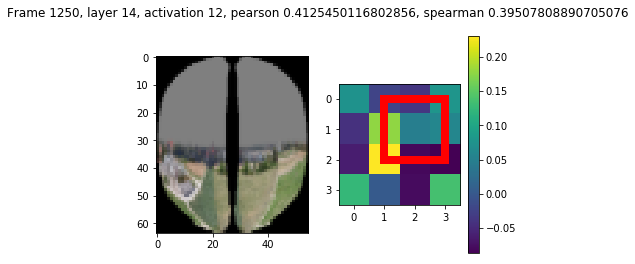

In [ ]:
fig = Visualizer.show_correlation(max_spearman_round_1, 1250, model_loader, model_loader.model.encoder)

In [ ]:
h1 = Visualizer.hist3d(corrs_round_1, bins = 45, pearson = True, title = "round 1", show = False)
h2 = Visualizer.hist3d(corrs_round_2, bins = 45, pearson = True, title = "round 2", show = False)
h3 = Visualizer.hist3d(corrs_round_3, bins = 45, pearson = True, title = "round 3", show = False)
h4 = Visualizer.hist3d(corrs_round_1, bins = 45, pearson = False, title = "round 1", show = False)
h5 = Visualizer.hist3d(corrs_round_2, bins = 45, pearson = False, title = "round 2", show = False)
h6 = Visualizer.hist3d(corrs_round_3, bins = 45, pearson = False, title = "round 3", show = False)

Utils.add_fig_to_image(h1)
Utils.add_fig_to_image(h2, append_horizontal = True)
Utils.add_fig_to_image(h3, append_horizontal = True)
Utils.add_fig_to_image(h4)
Utils.add_fig_to_image(h5, append_horizontal = True)
Utils.add_fig_to_image(h6, append_horizontal = True)
Utils.save_combined_image(get_path(["02_autoencoder", "results"], "3d_hist_per_round.png"), show_image = False)

### Correlation of all activations of an activation map

__Visualize all correlations of activations and neuro spikes during one round at the positions in their activation maps.__

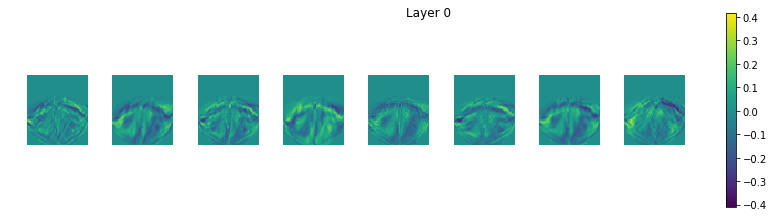

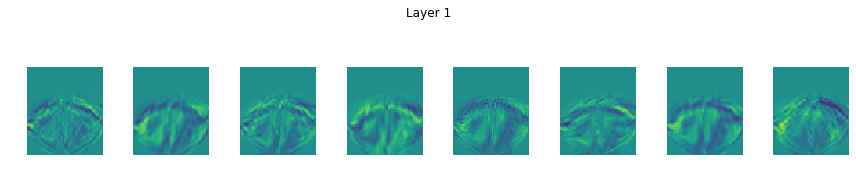

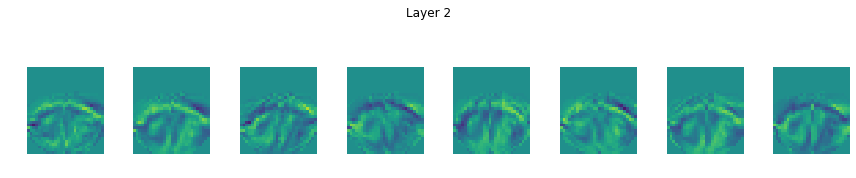

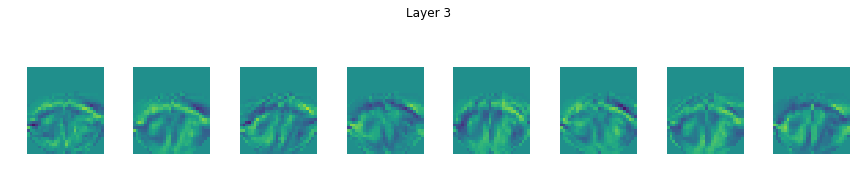

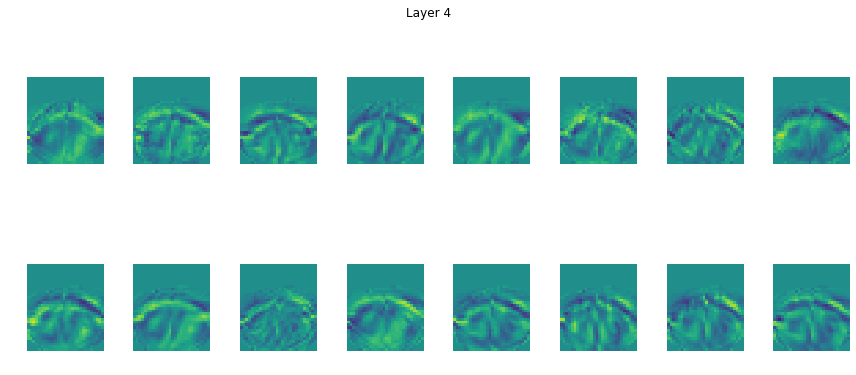

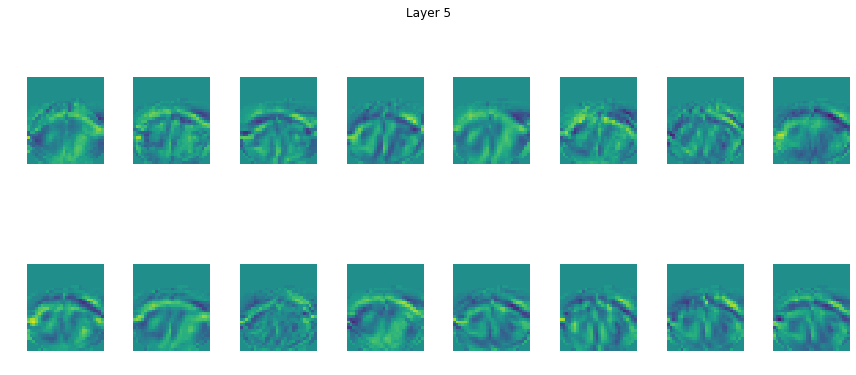

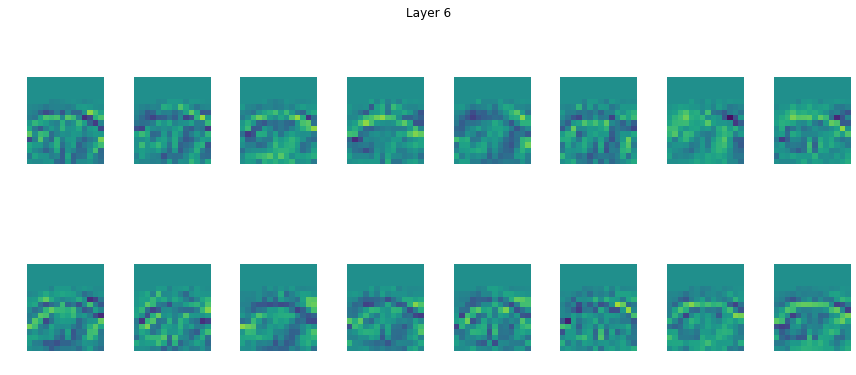

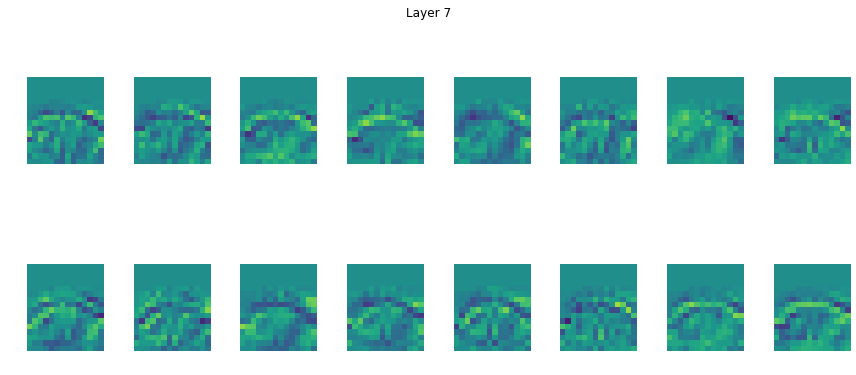

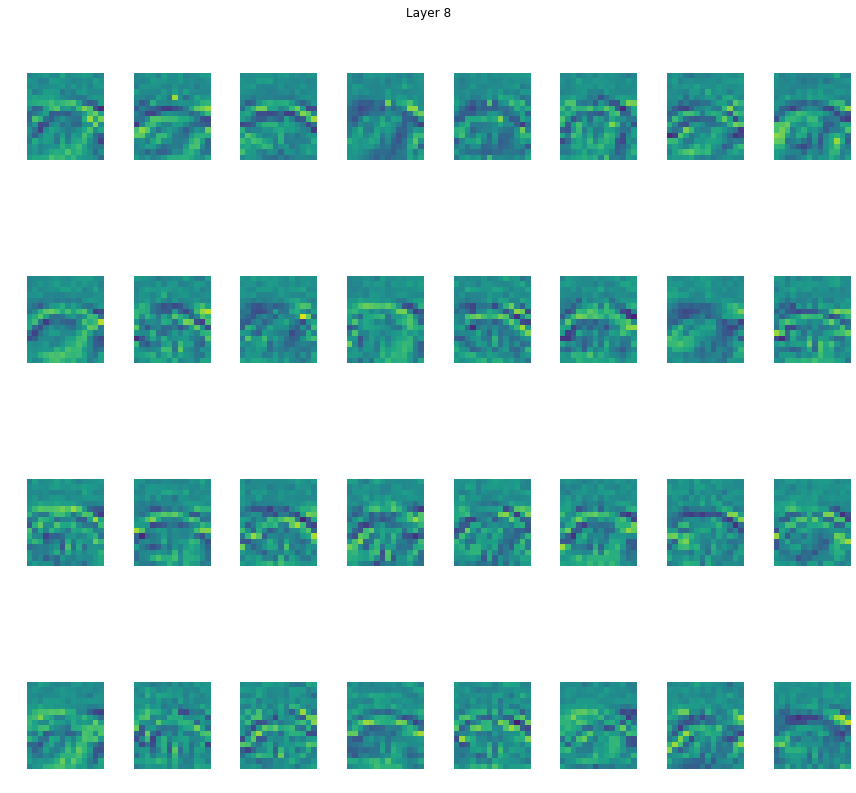

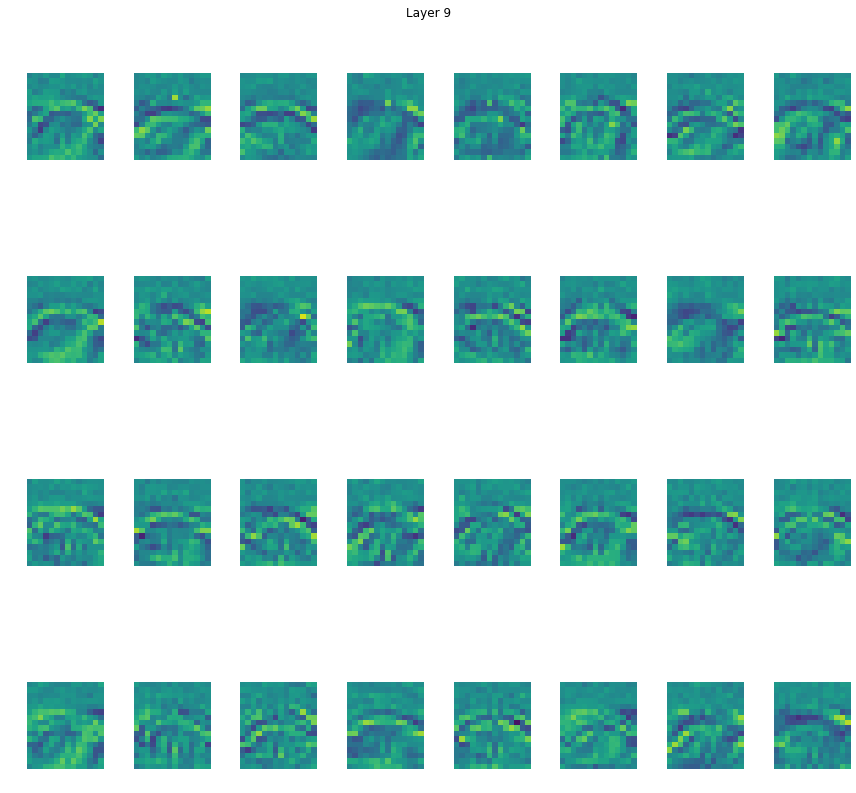

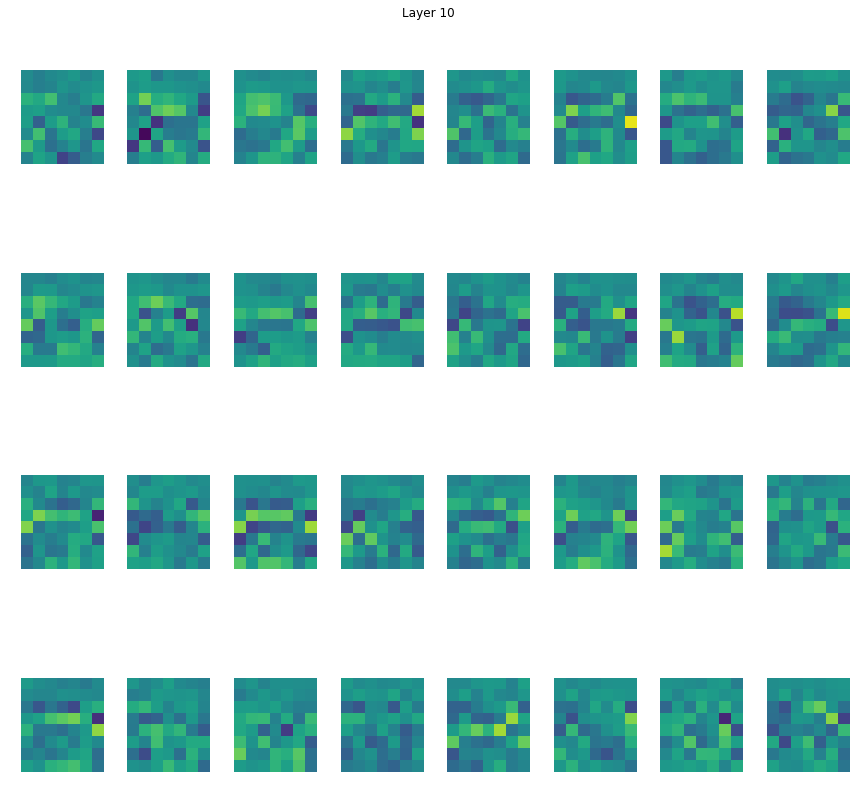

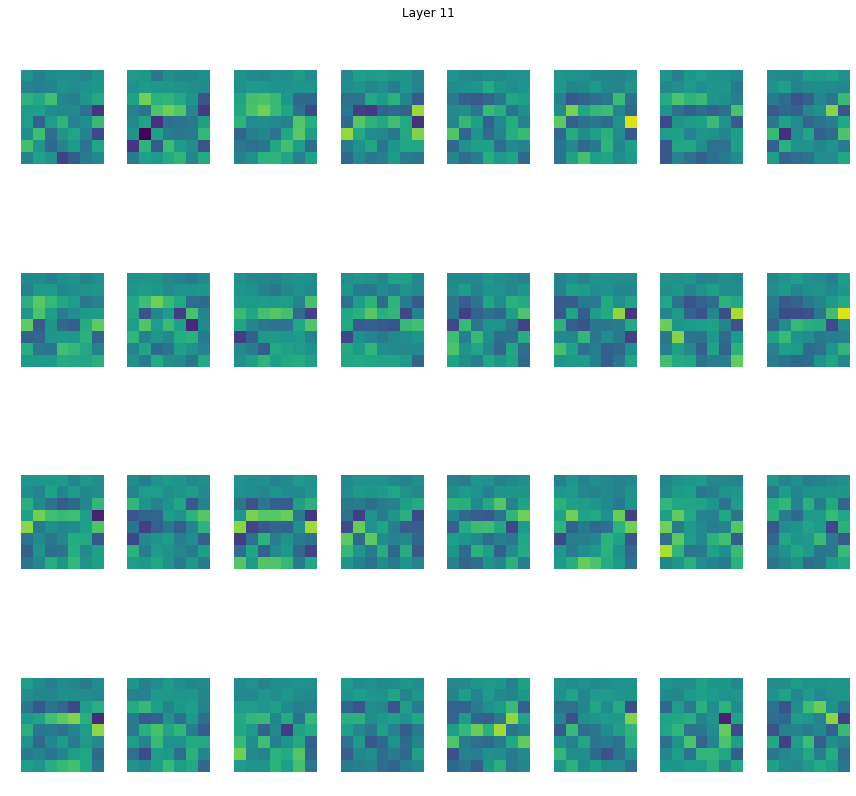

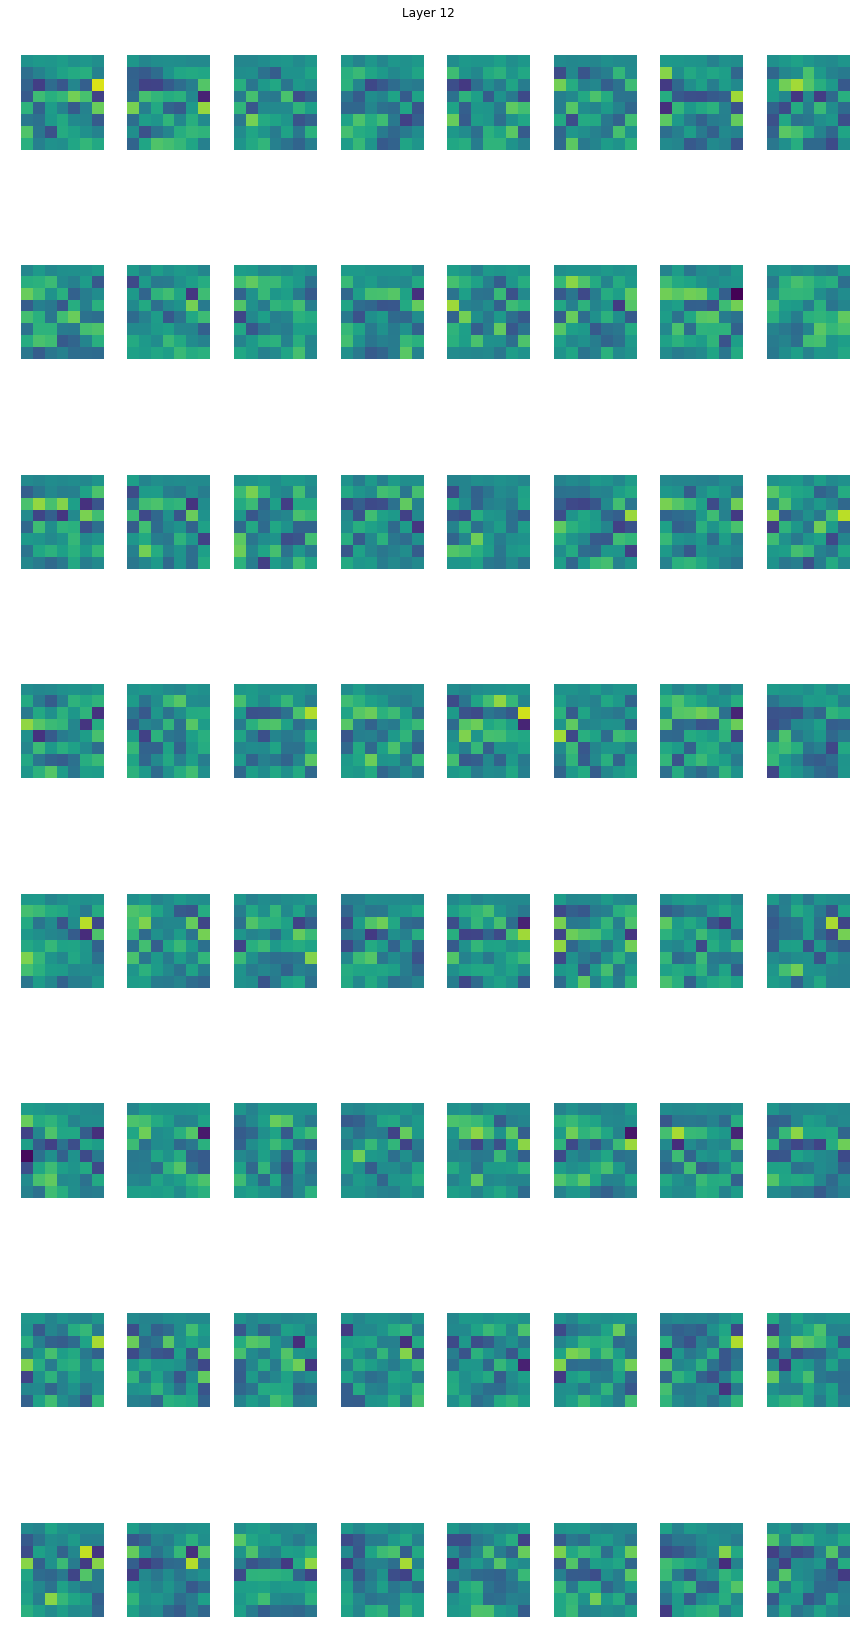

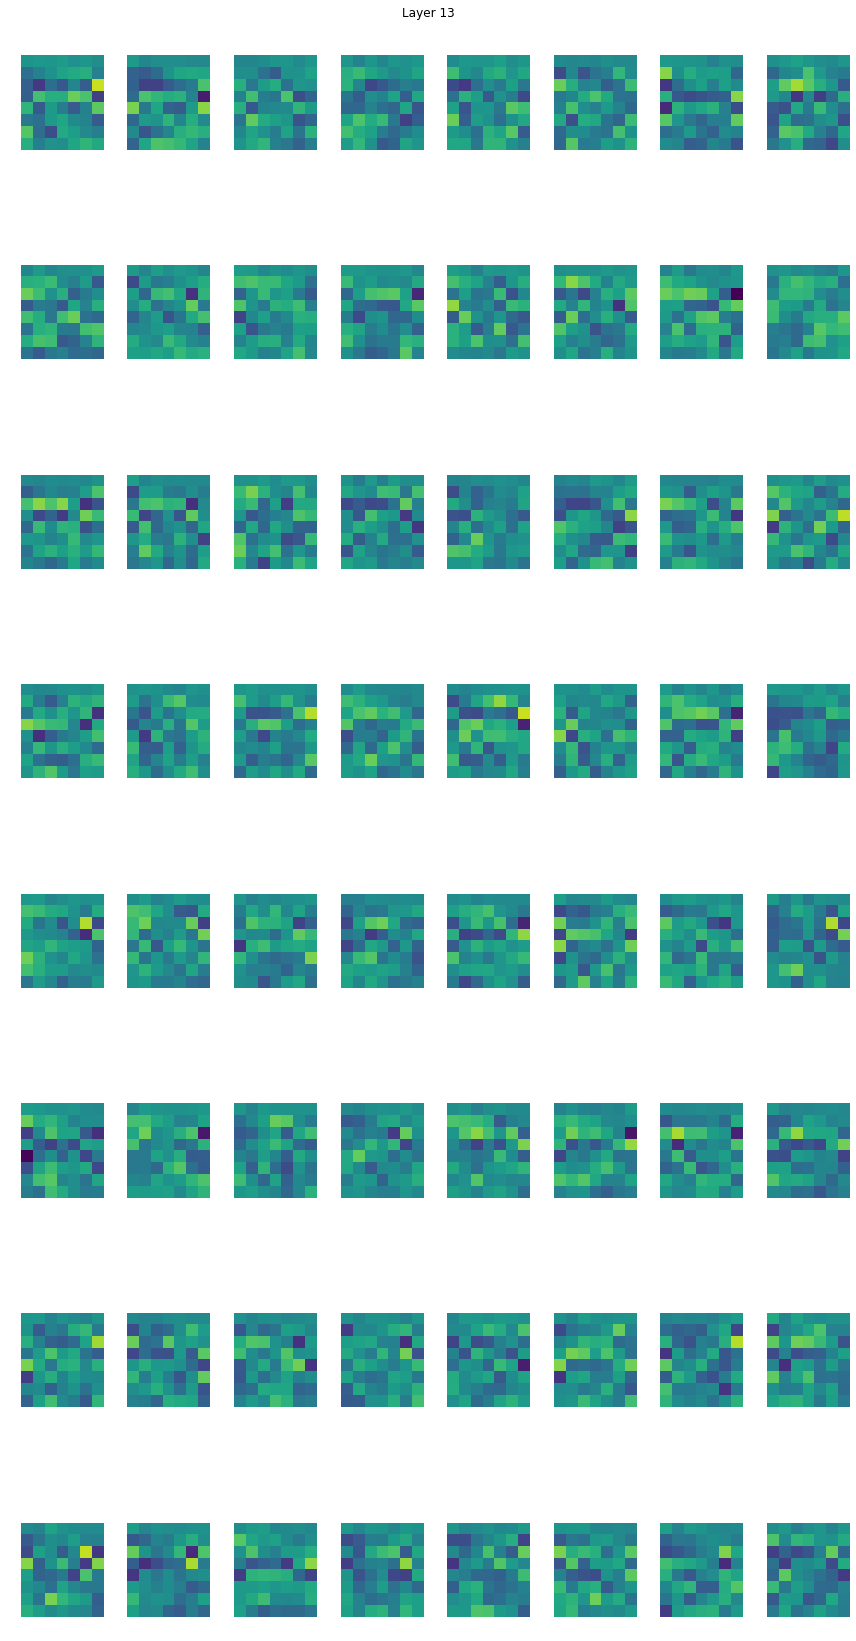

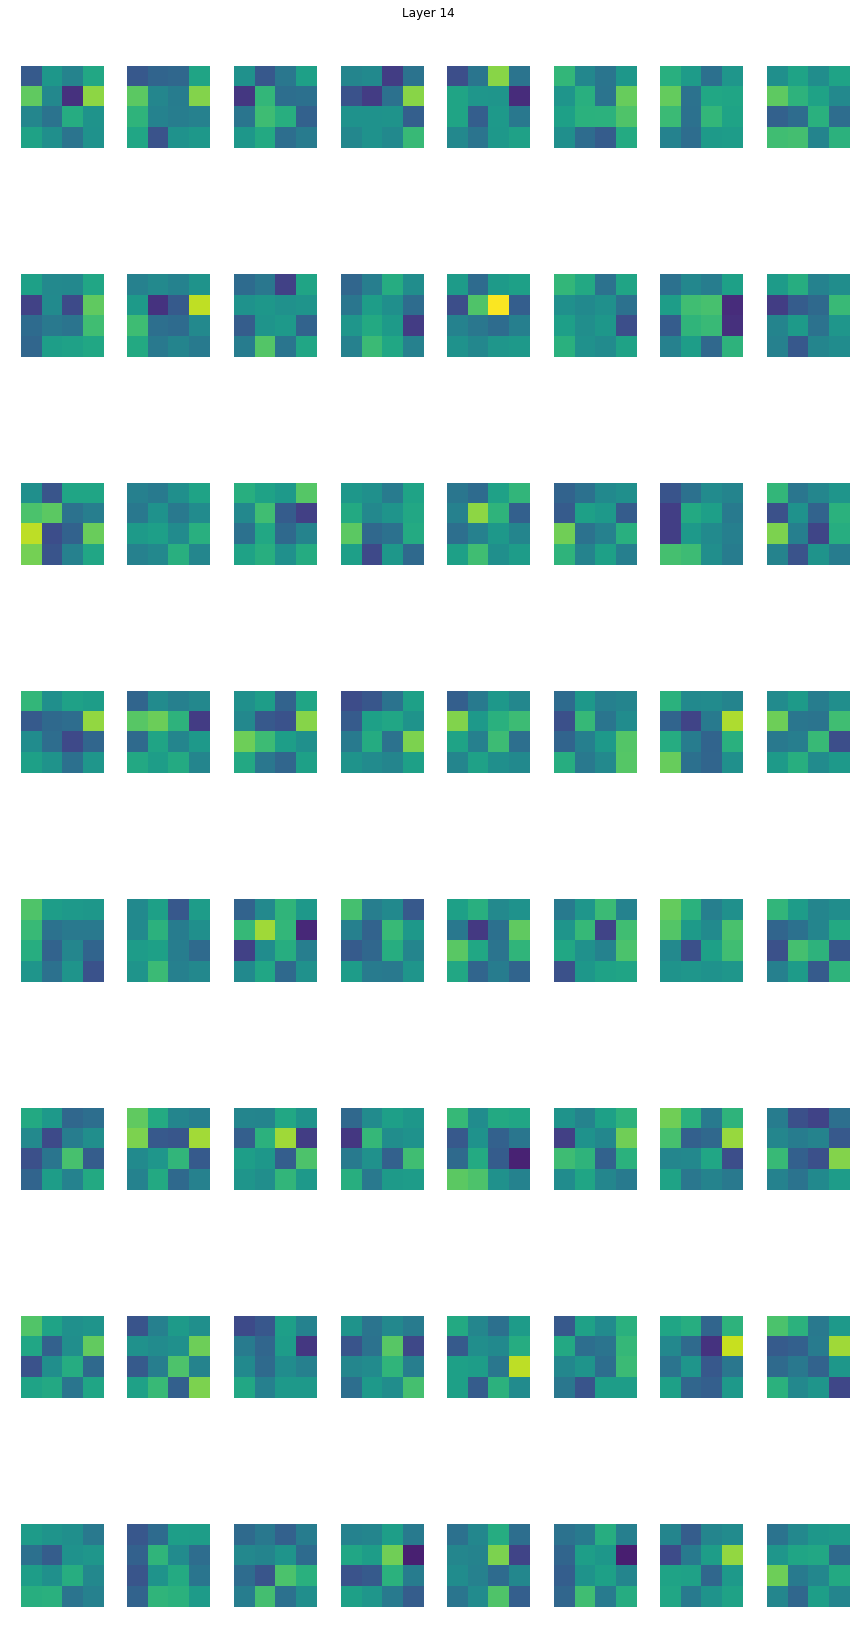

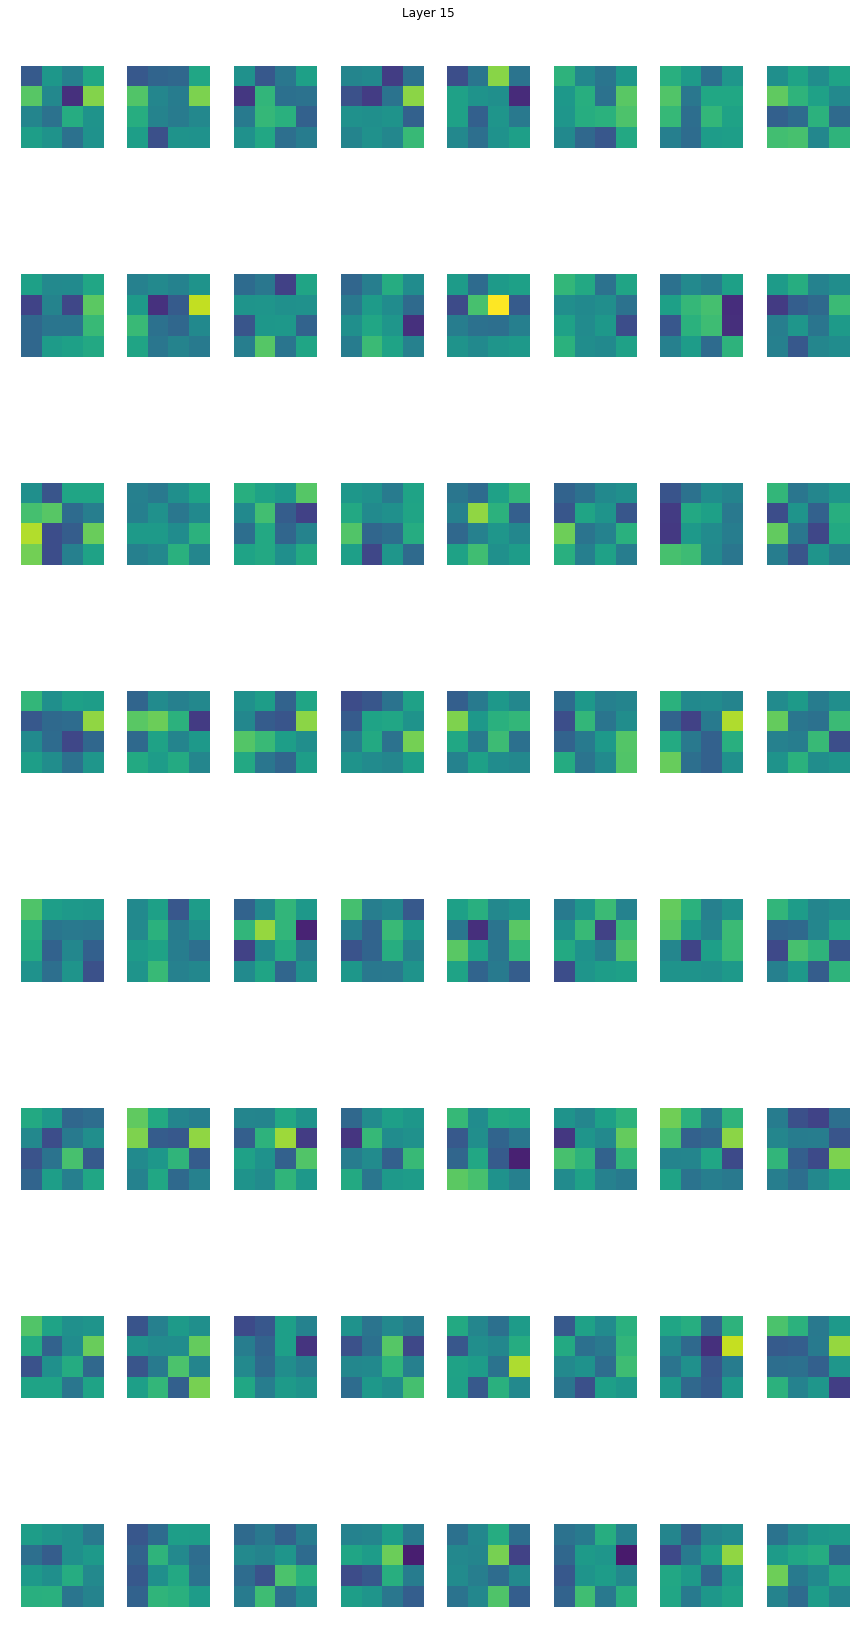

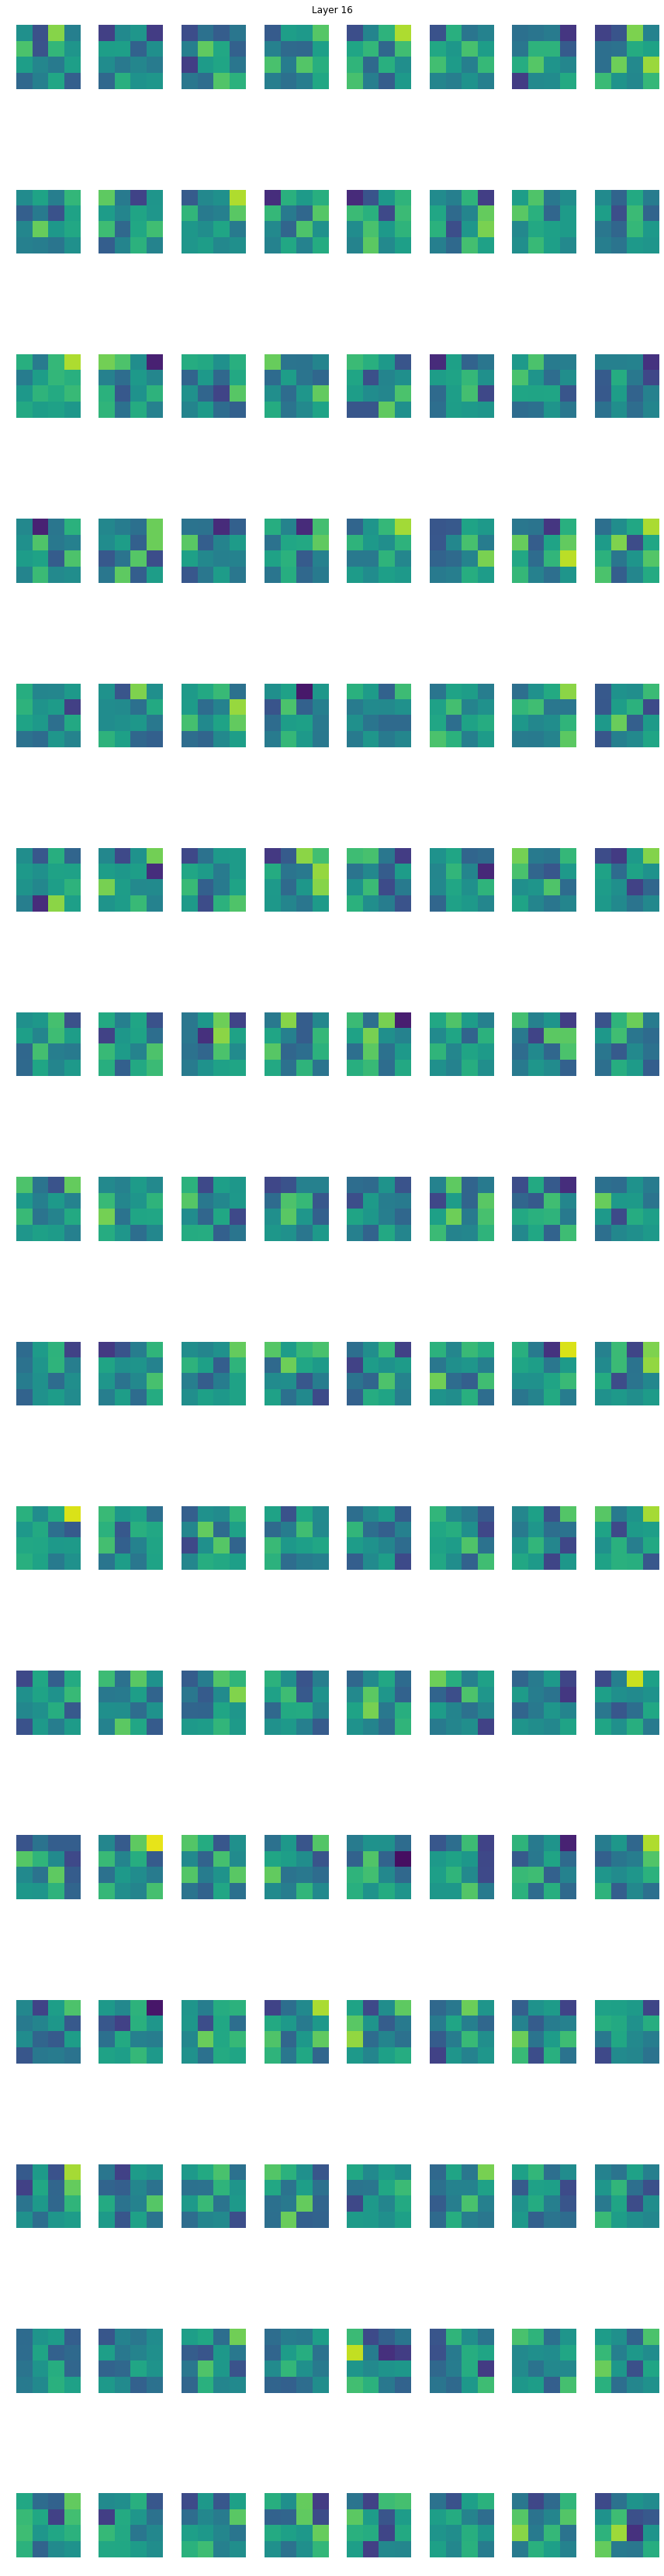

In [ ]:
Visualizer.show_all_correlation(corrs_round_1, pearson = True)

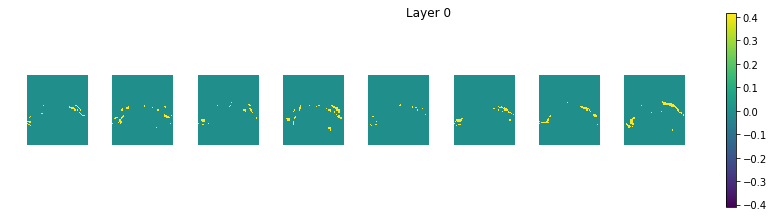

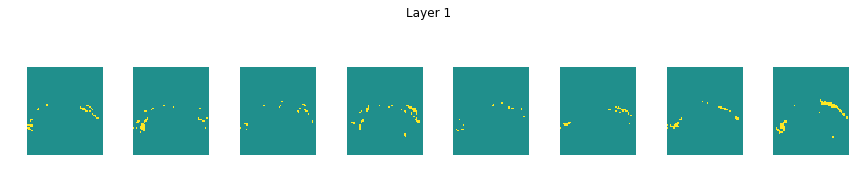

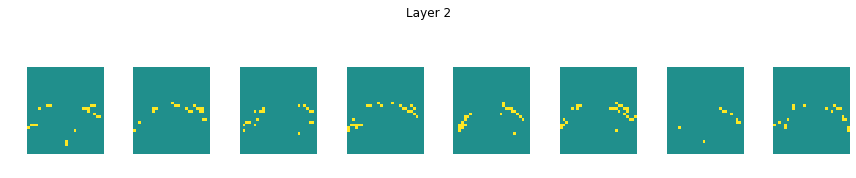

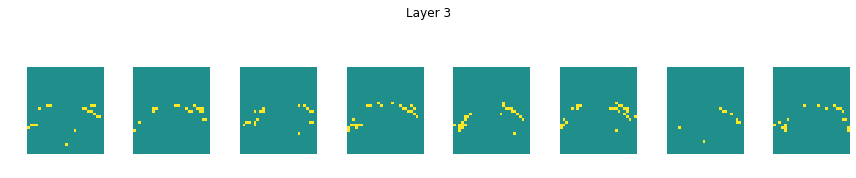

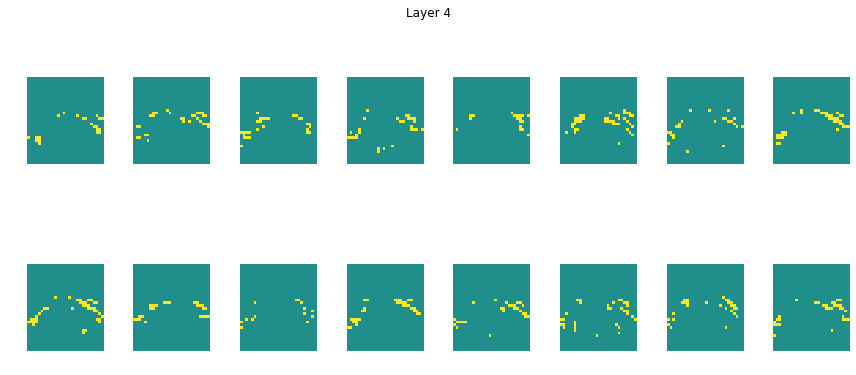

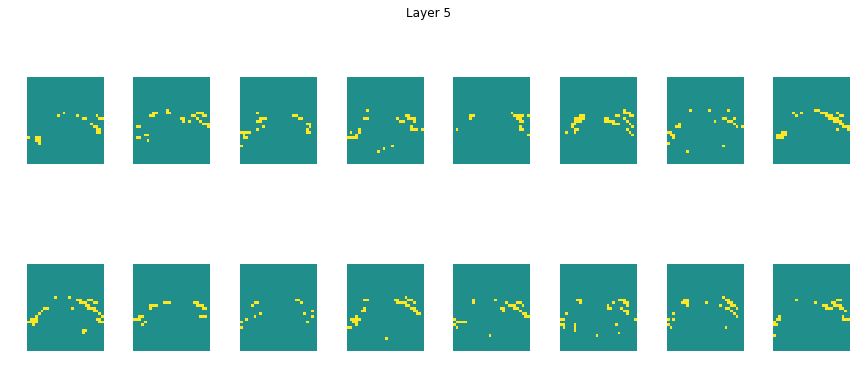

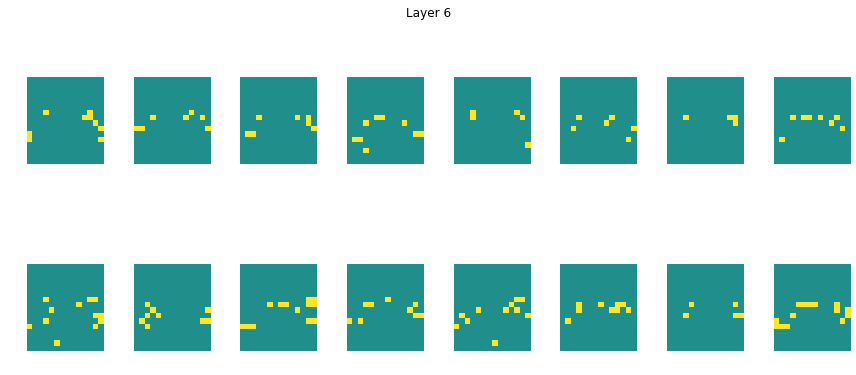

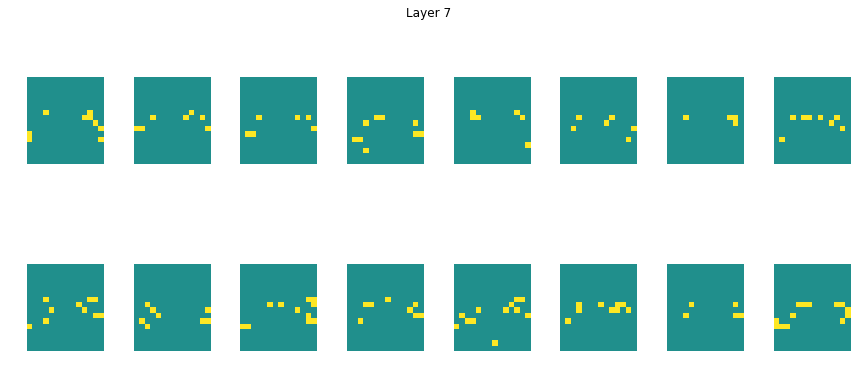

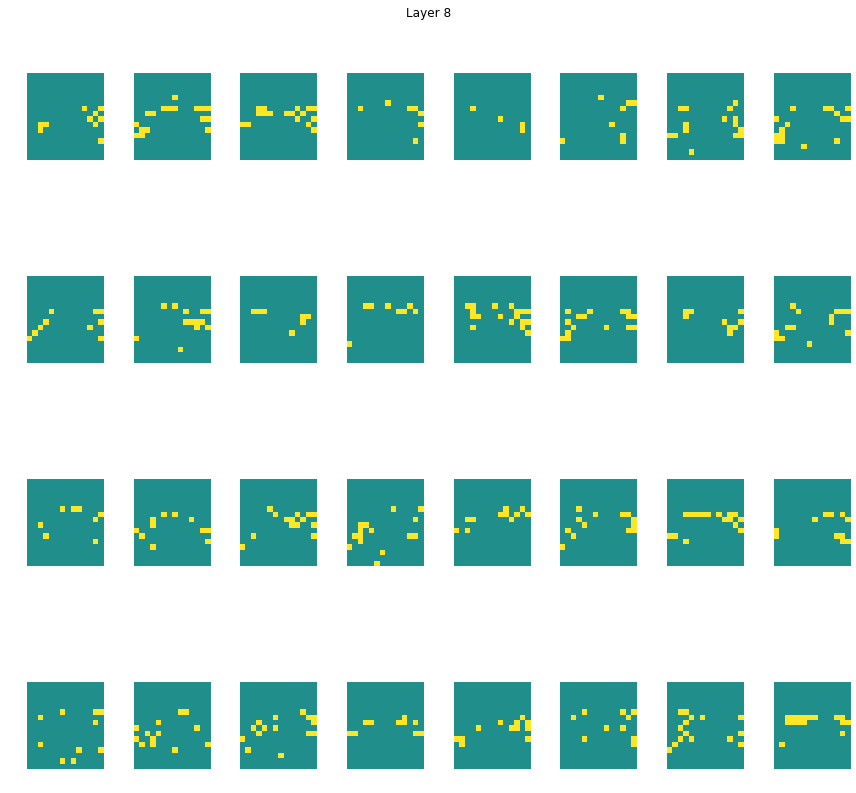

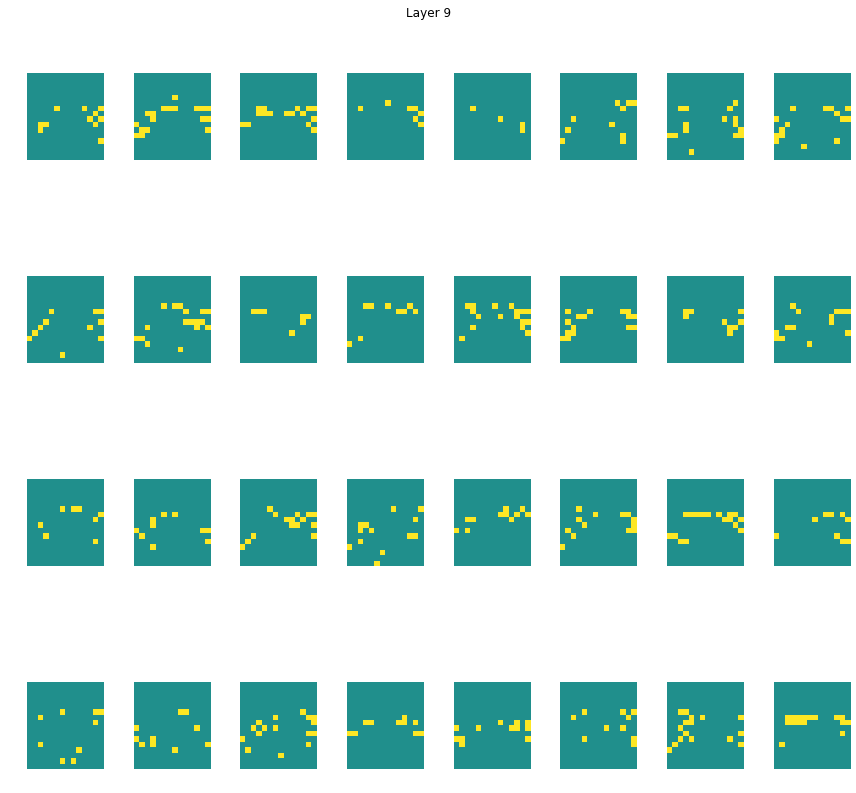

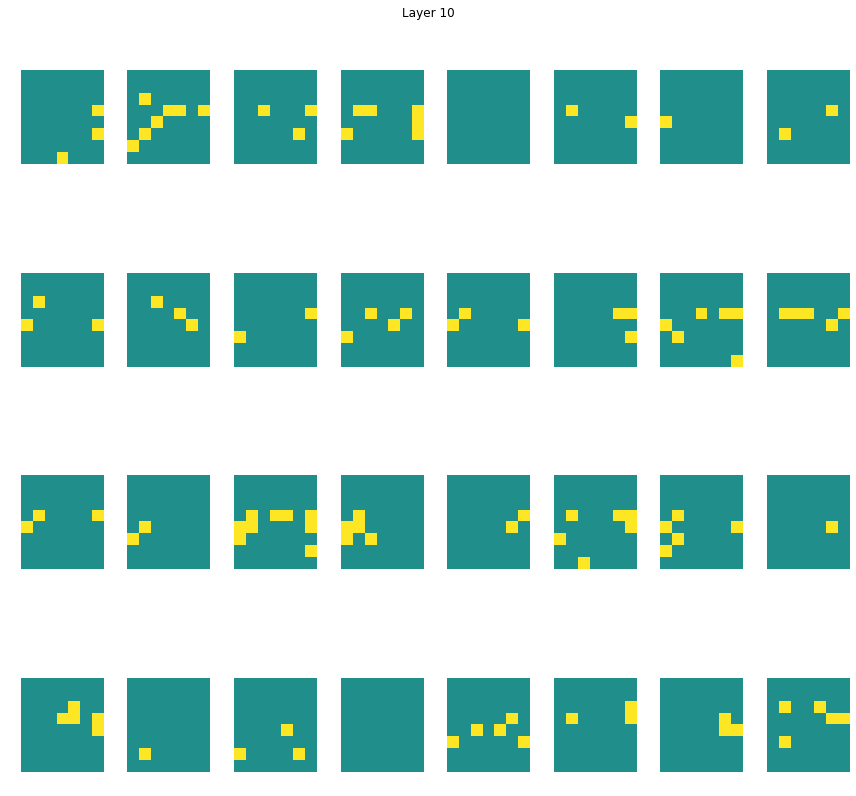

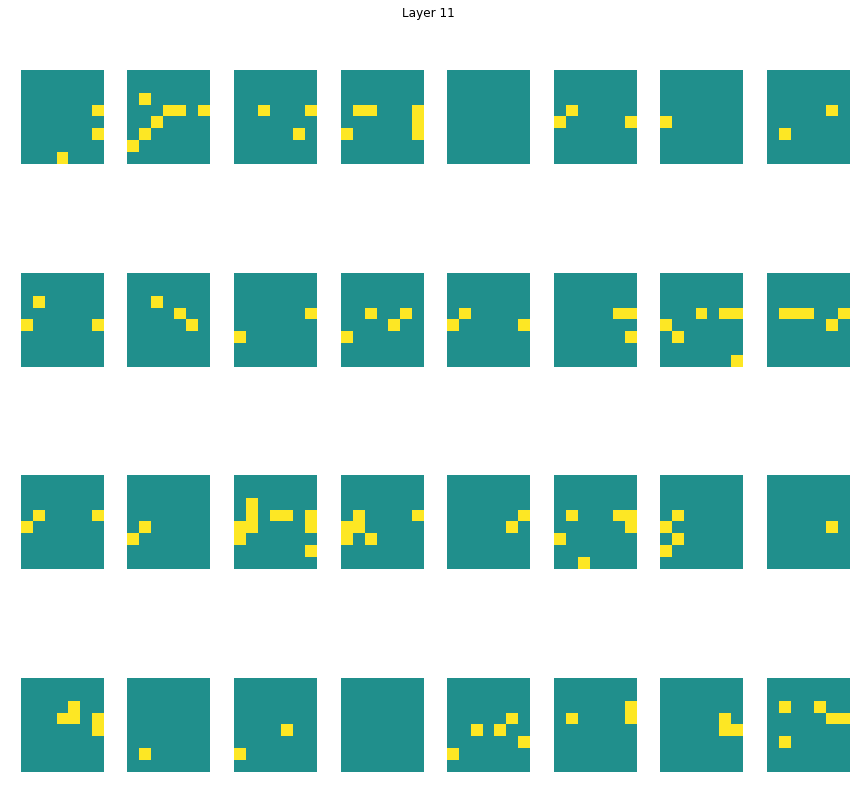

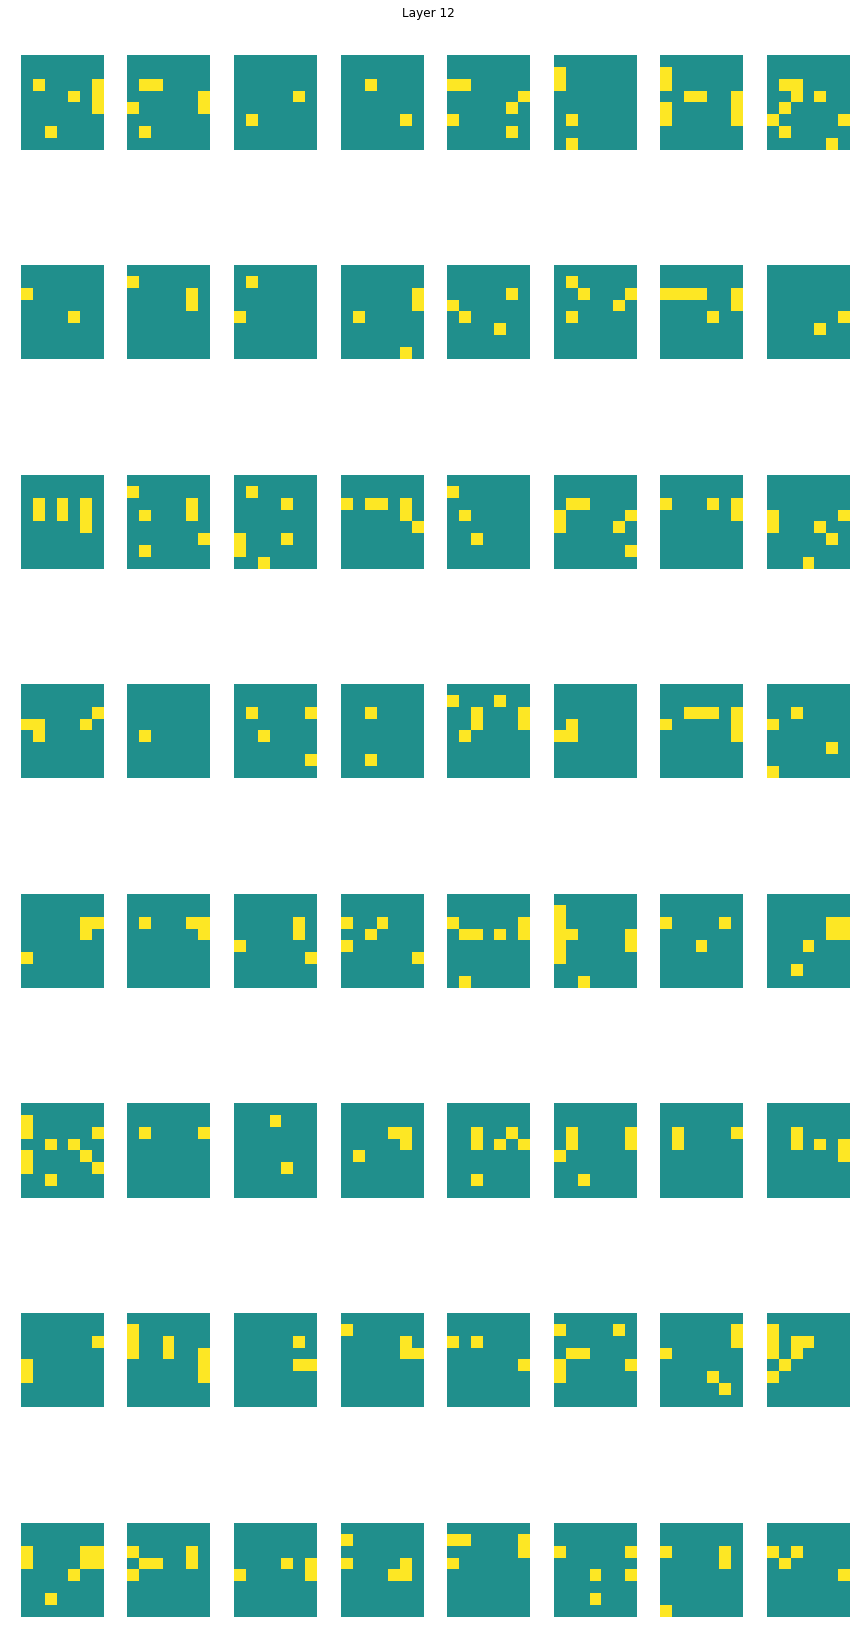

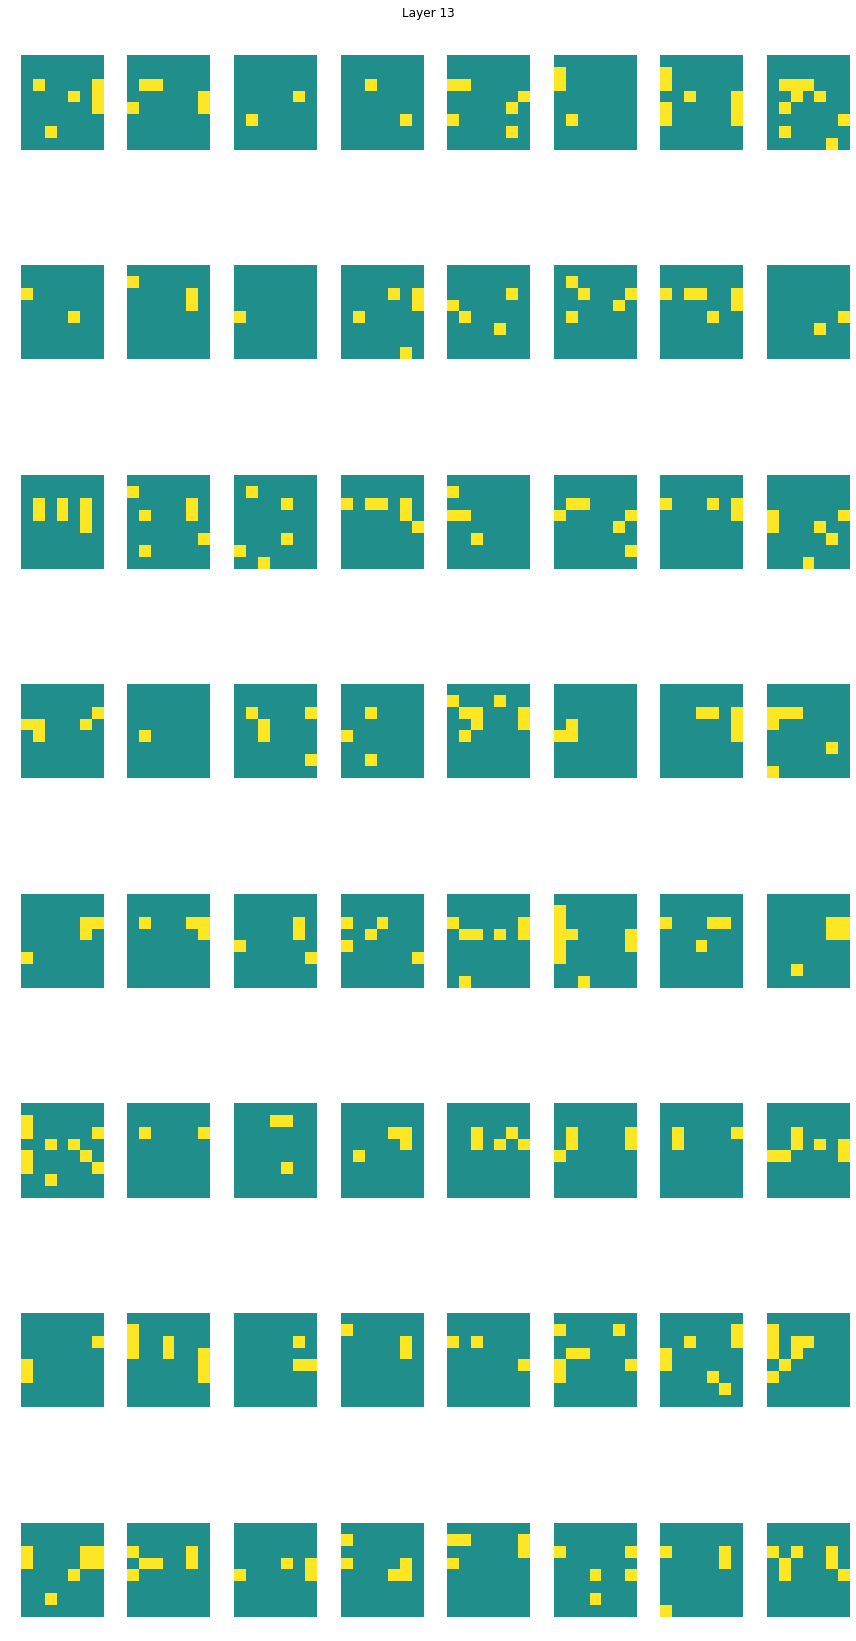

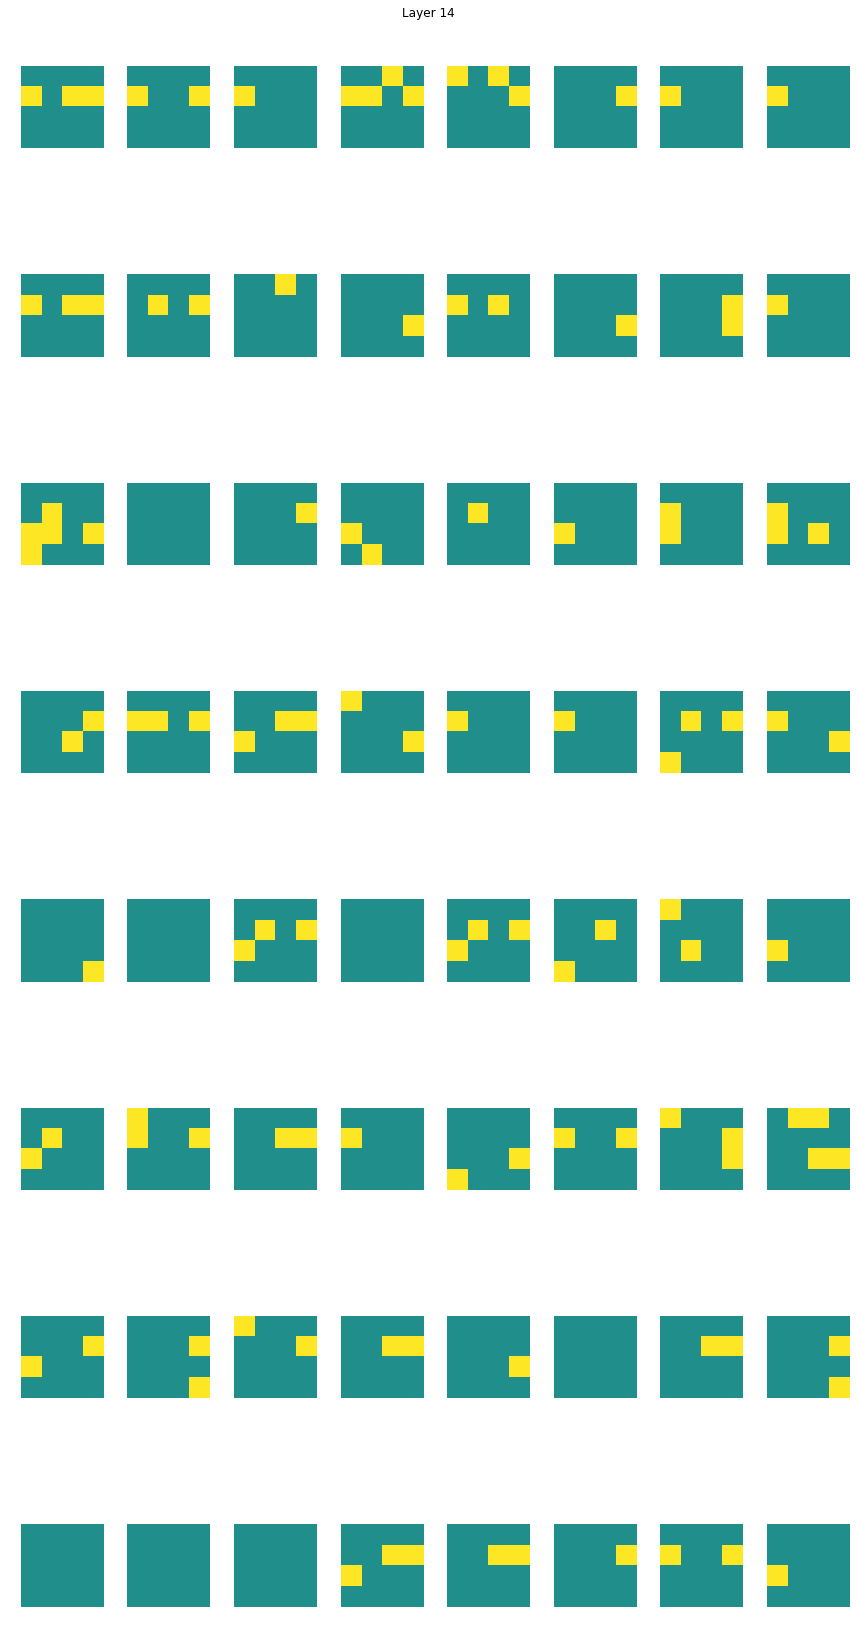

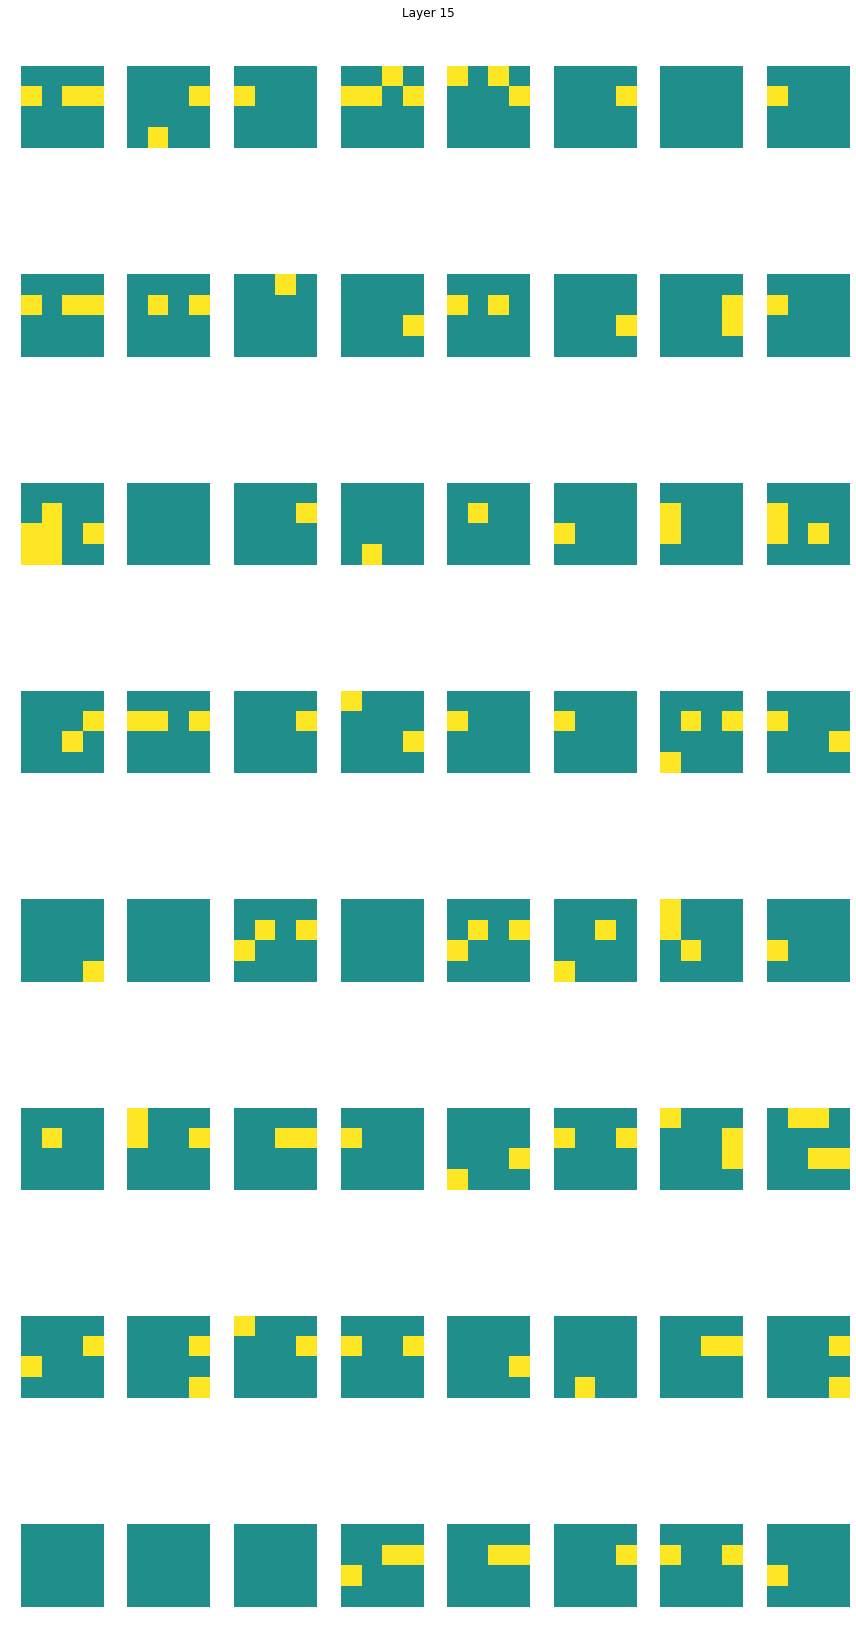

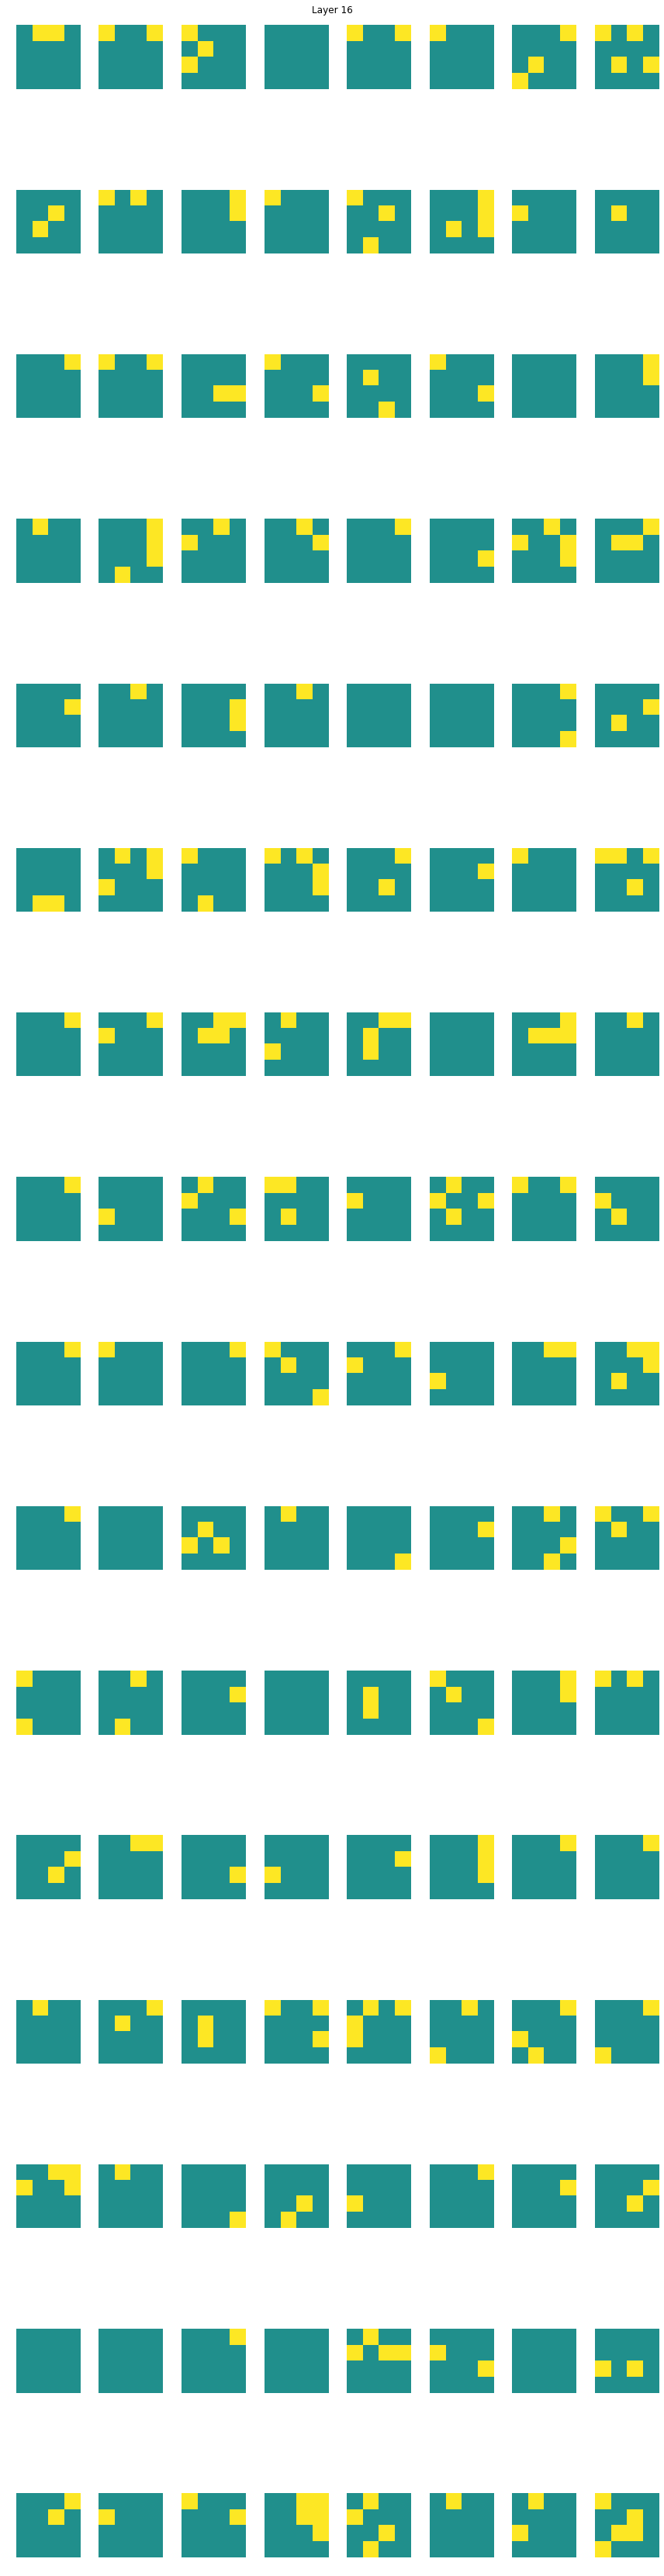

In [ ]:
Visualizer.show_all_correlation(corrs_round_1, pearson = True, threshold = 0.2)

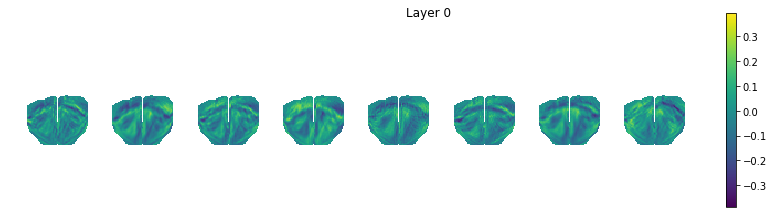

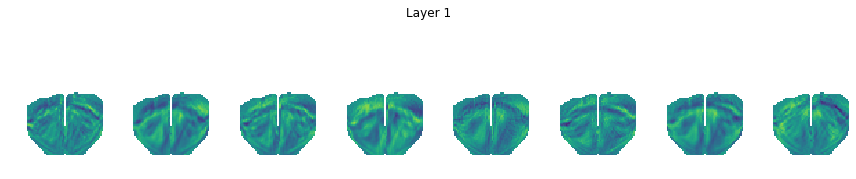

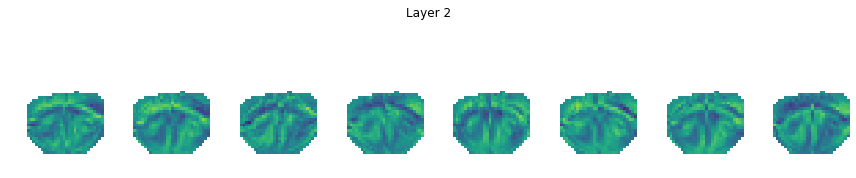

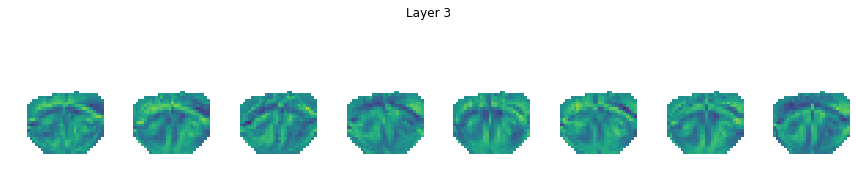

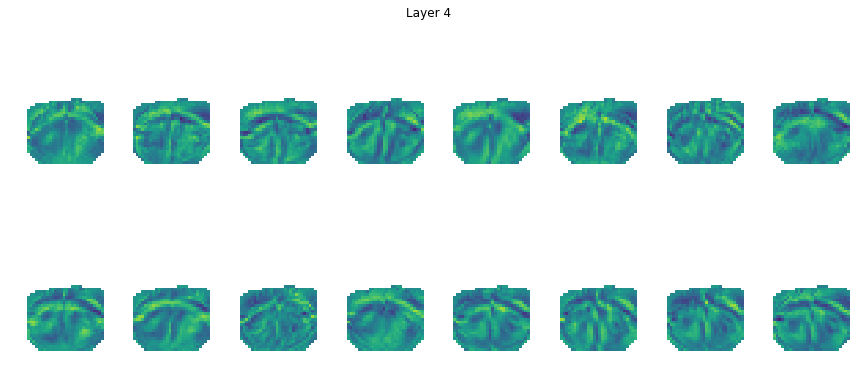

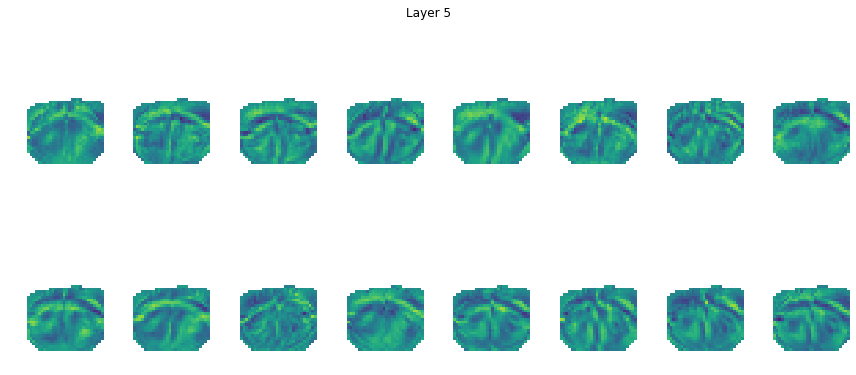

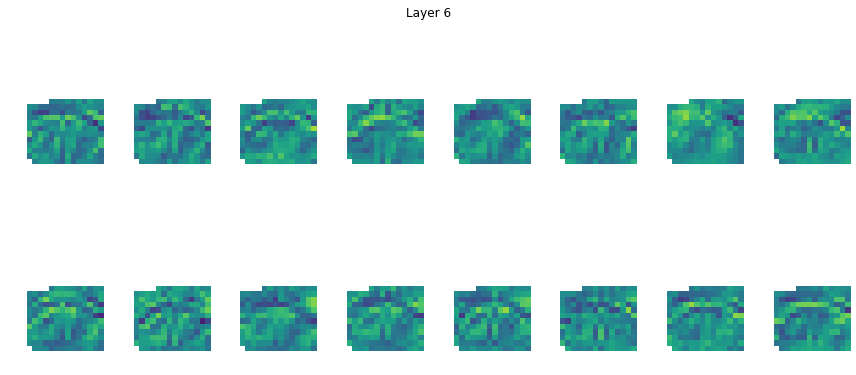

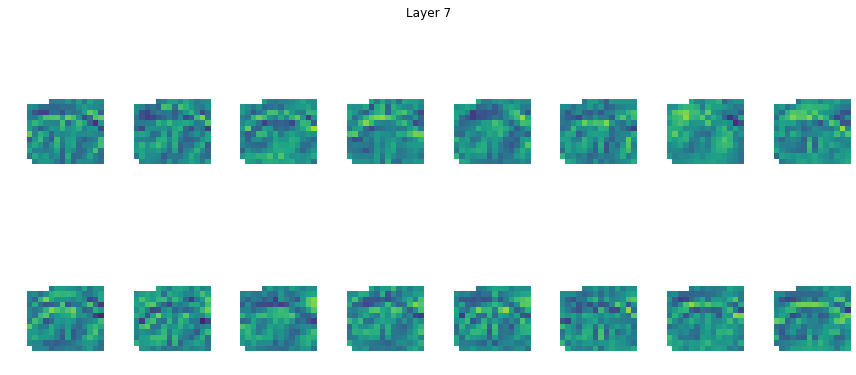

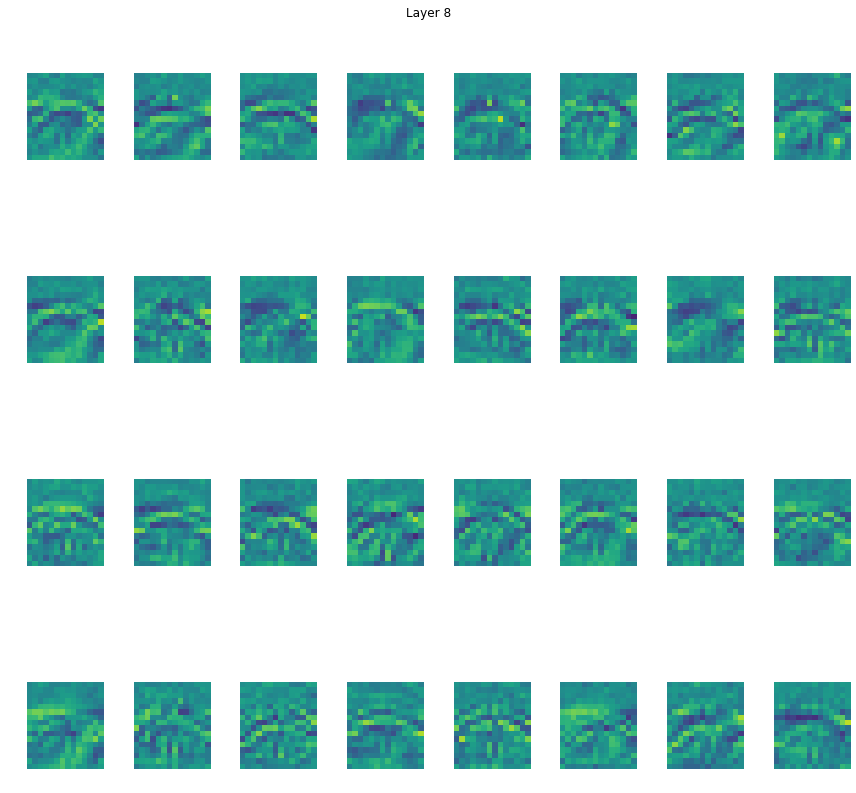

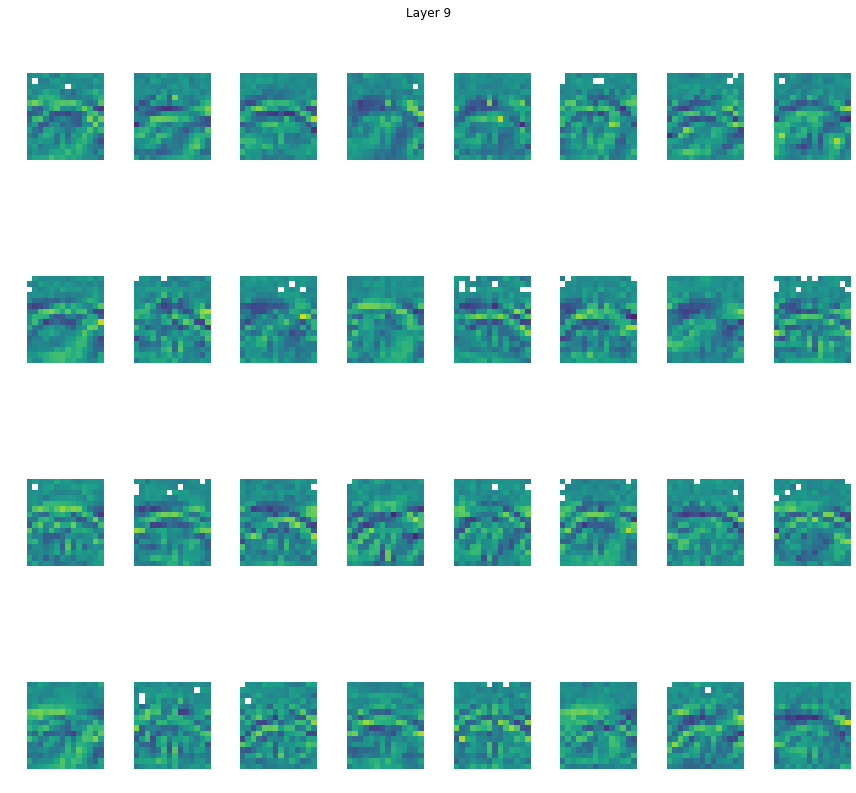

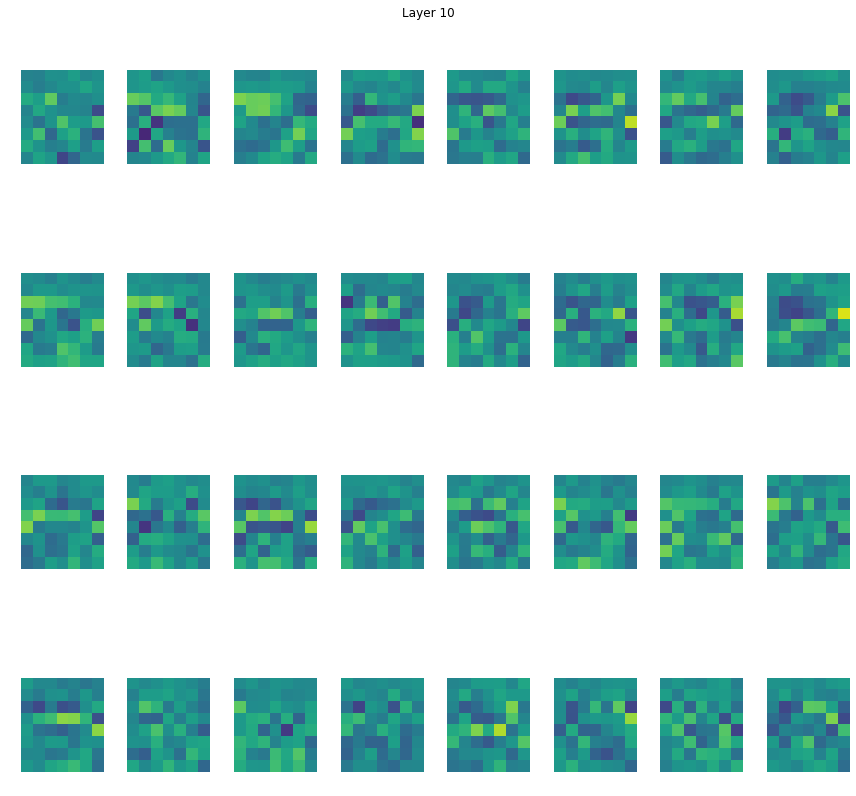

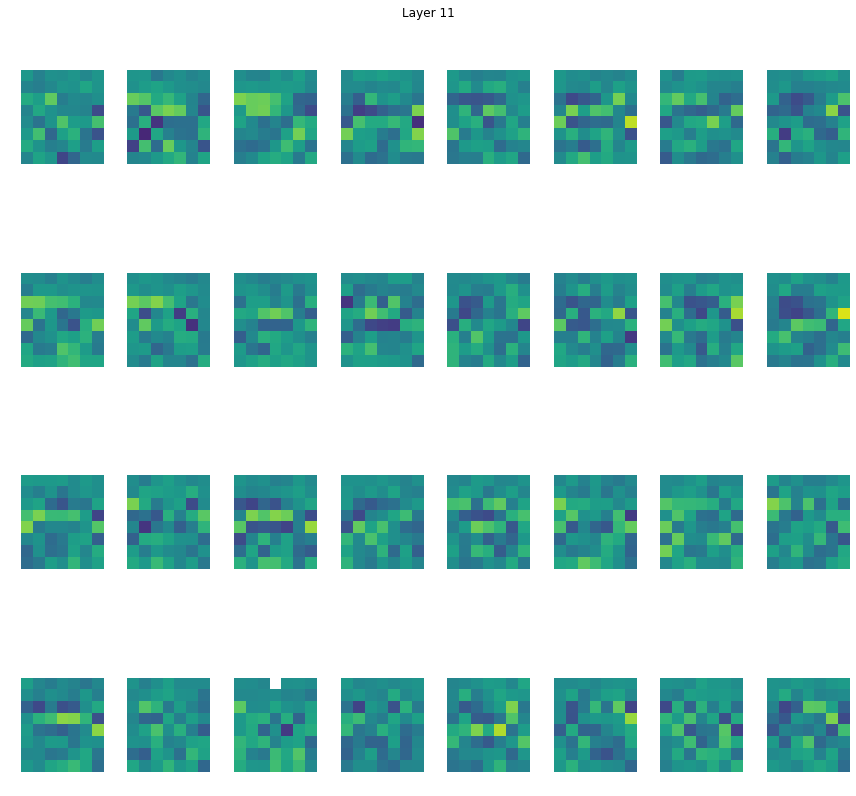

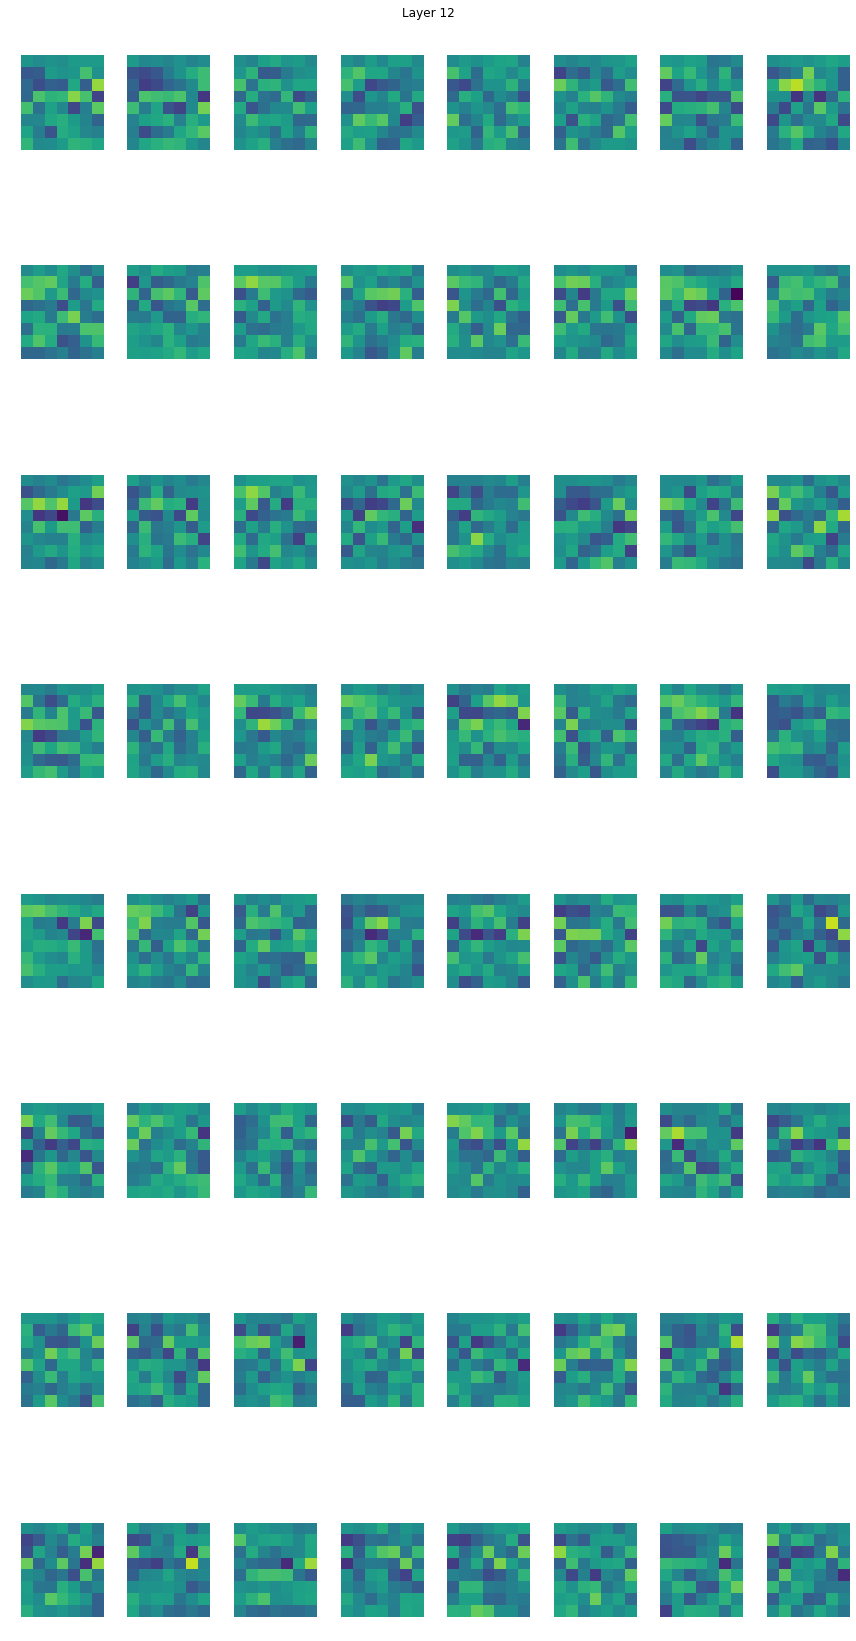

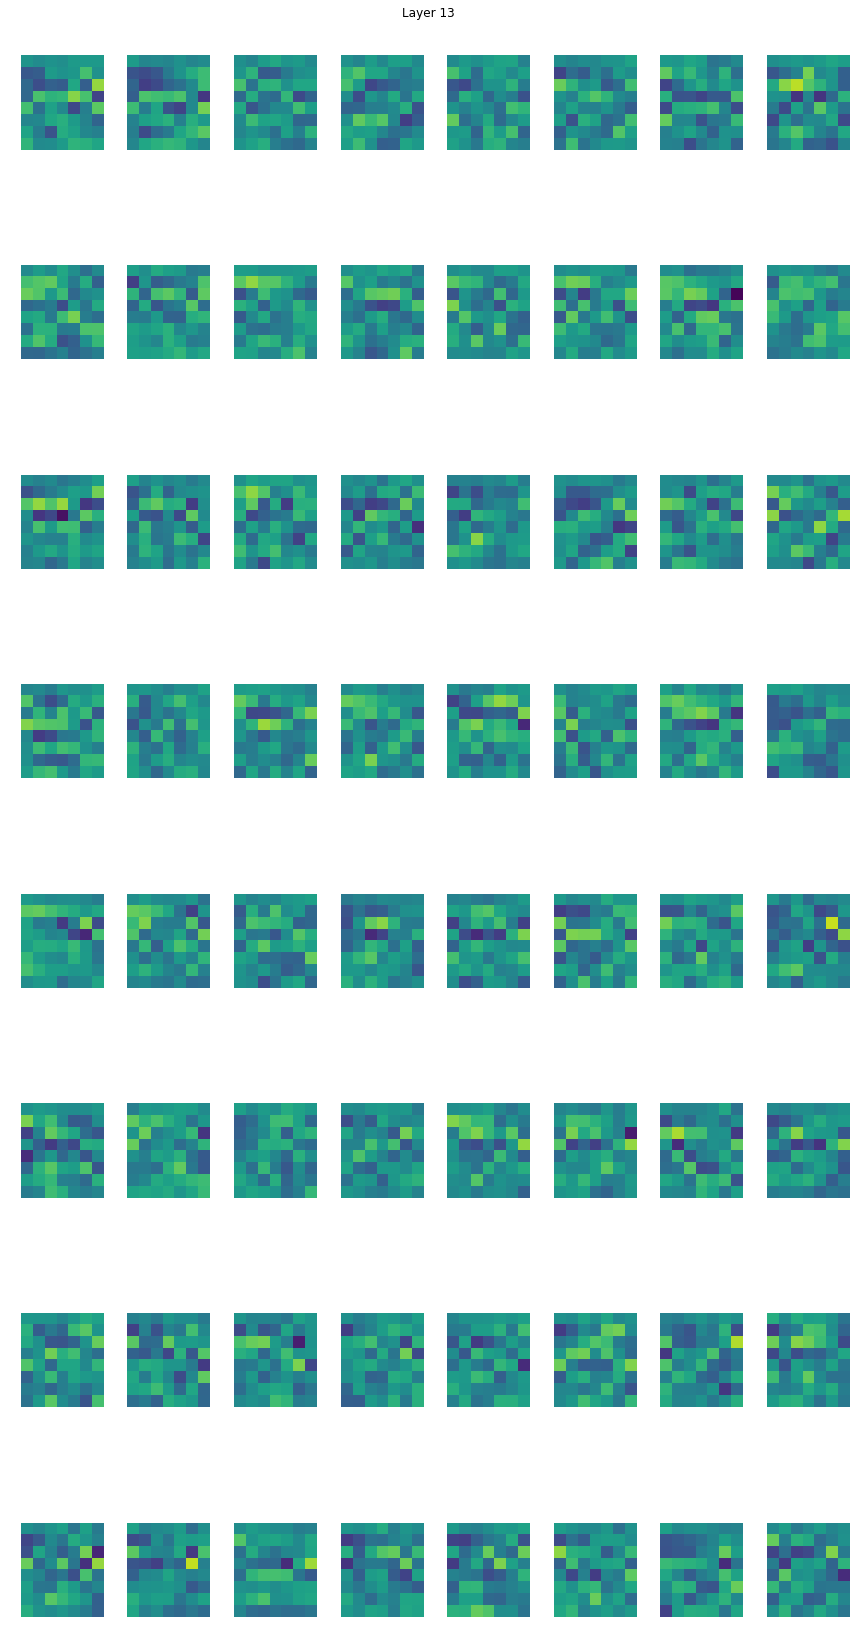

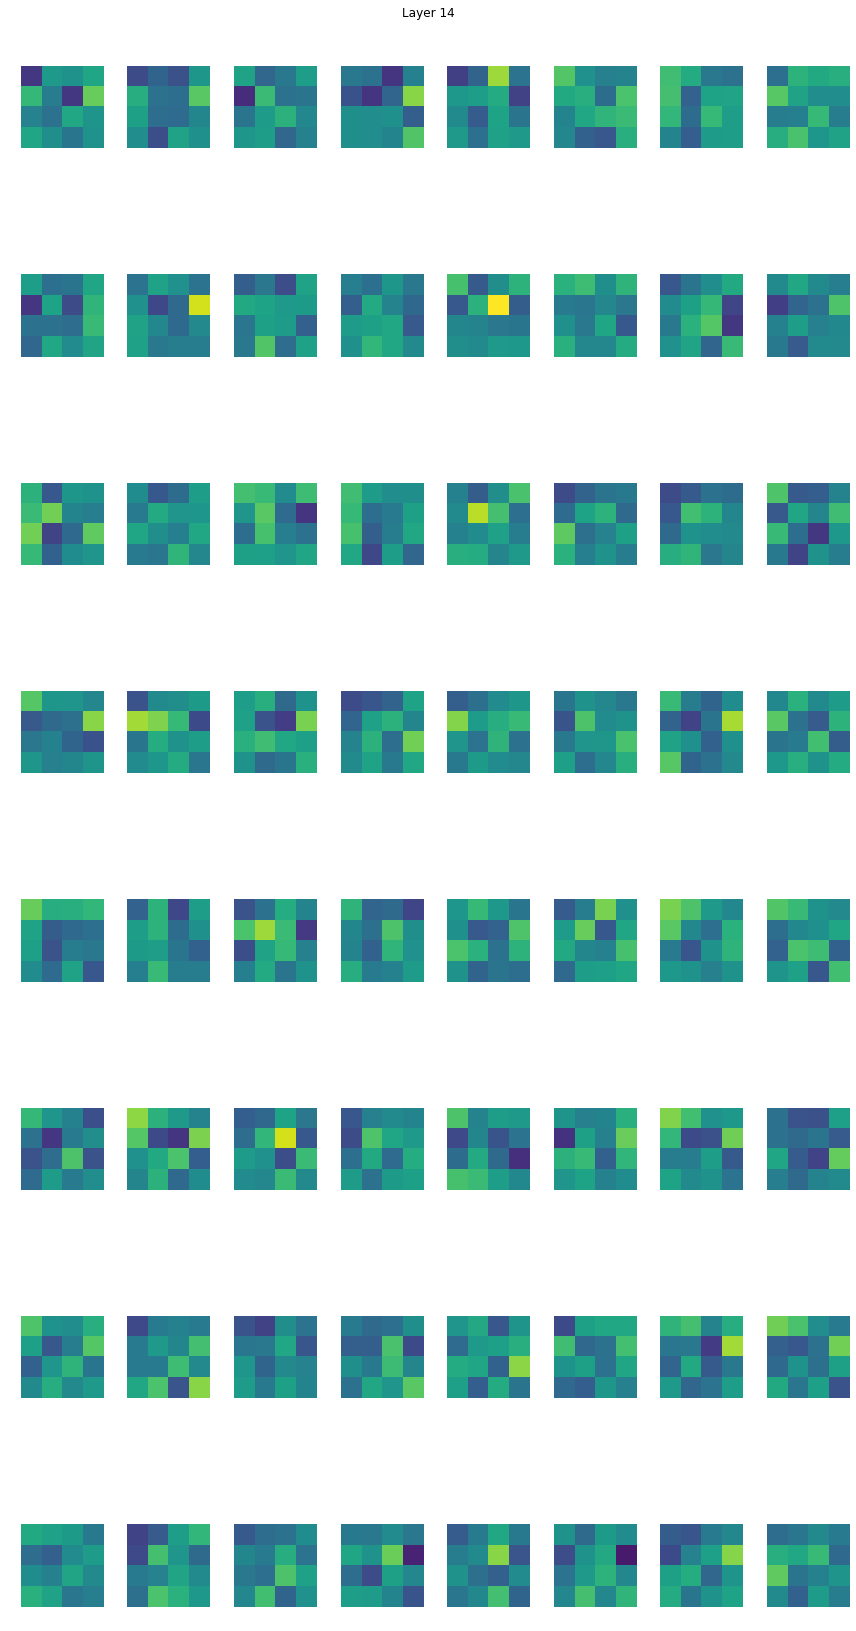

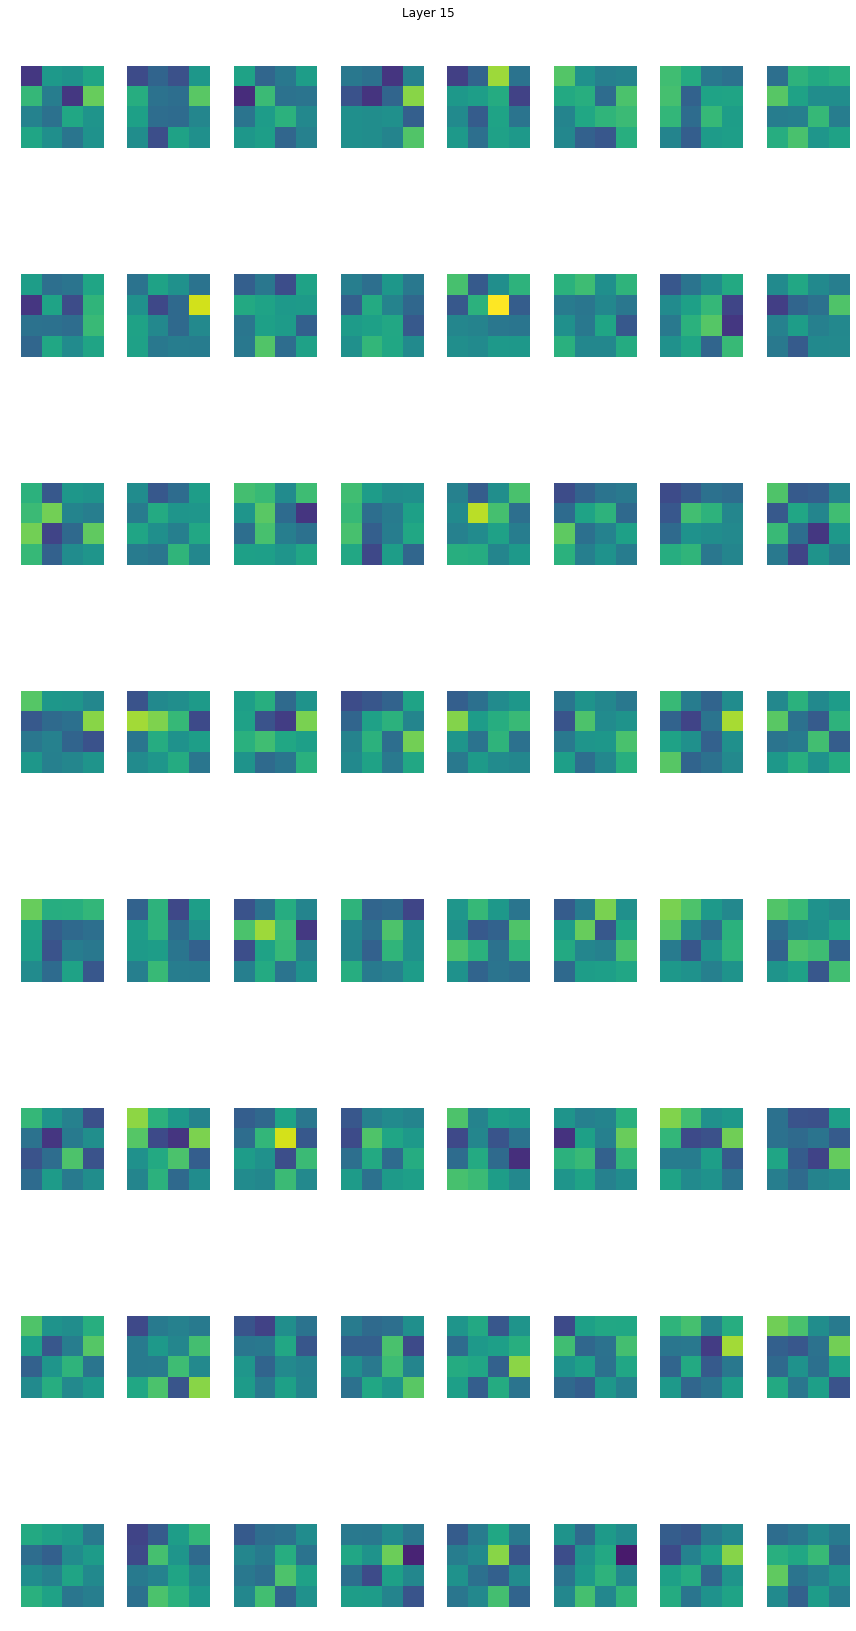

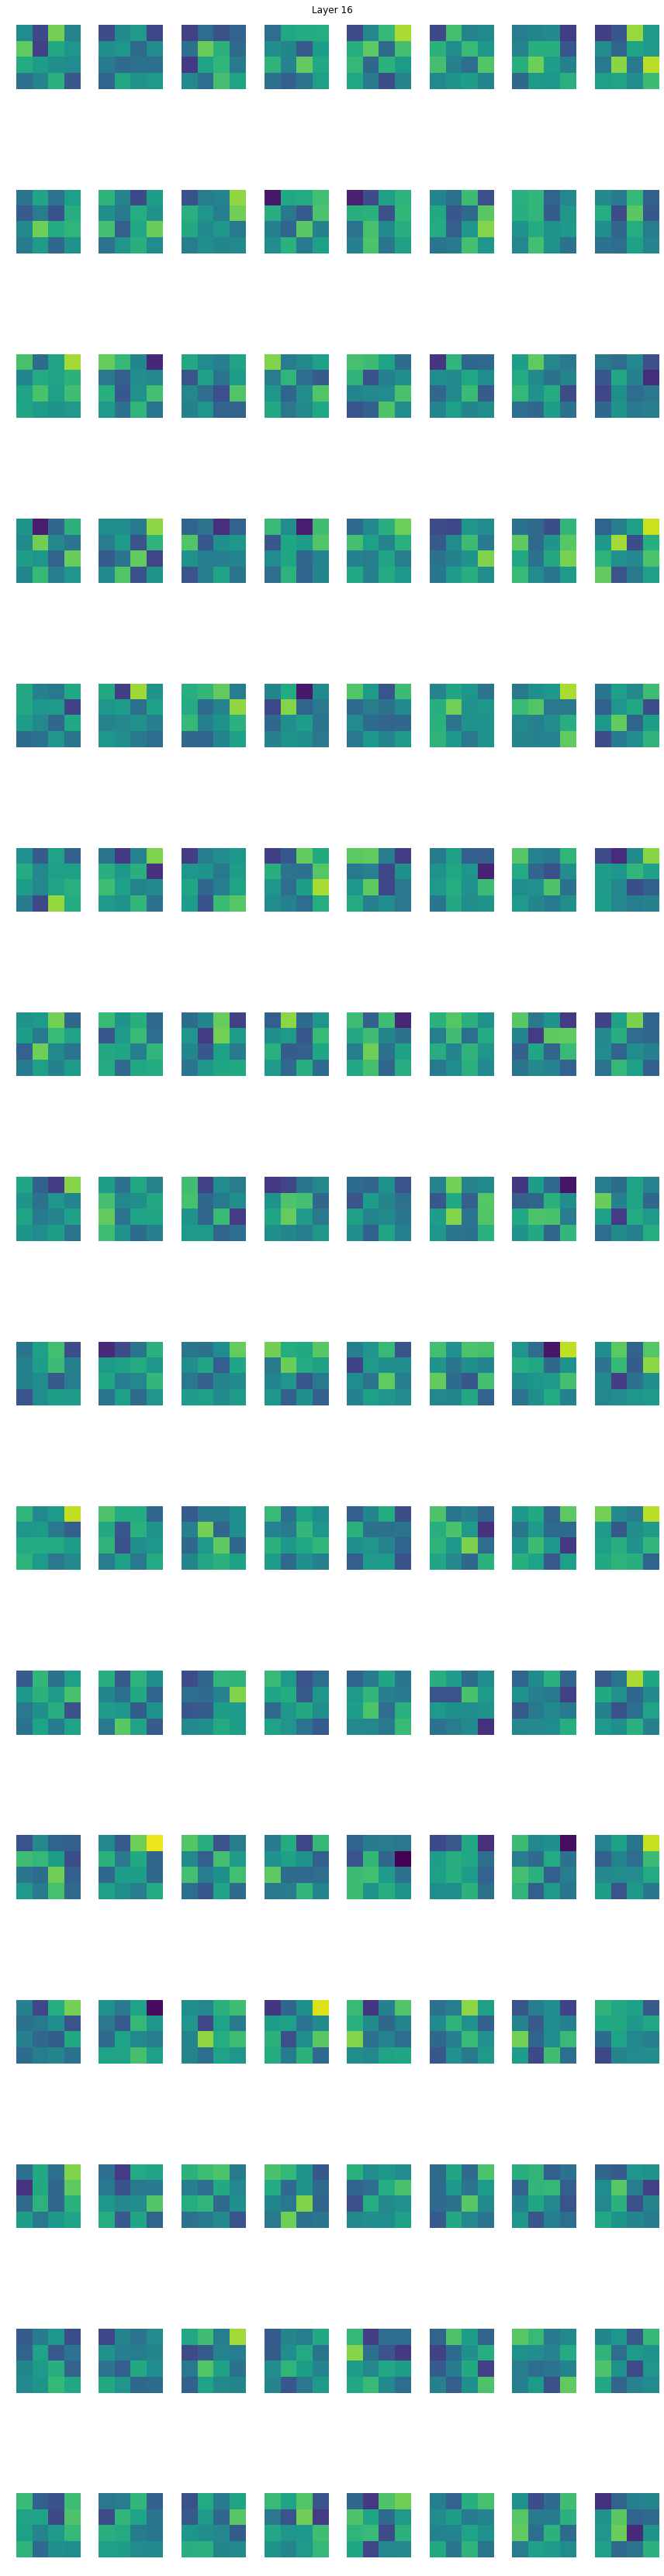

In [ ]:
Visualizer.show_all_correlation(corrs_round_1, pearson = False)

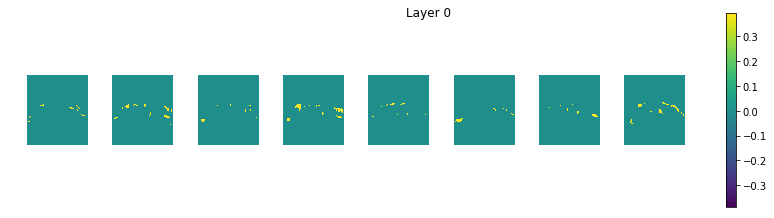

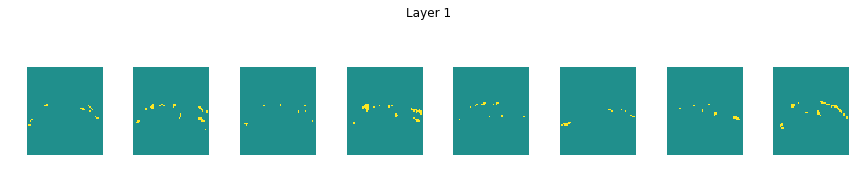

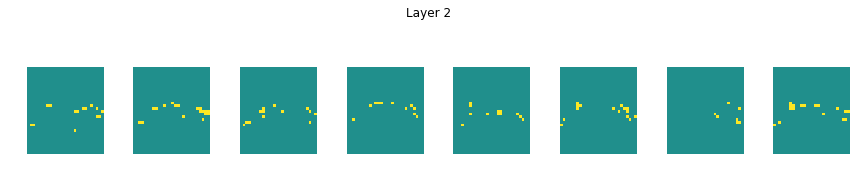

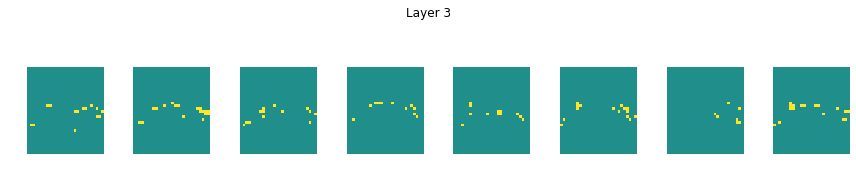

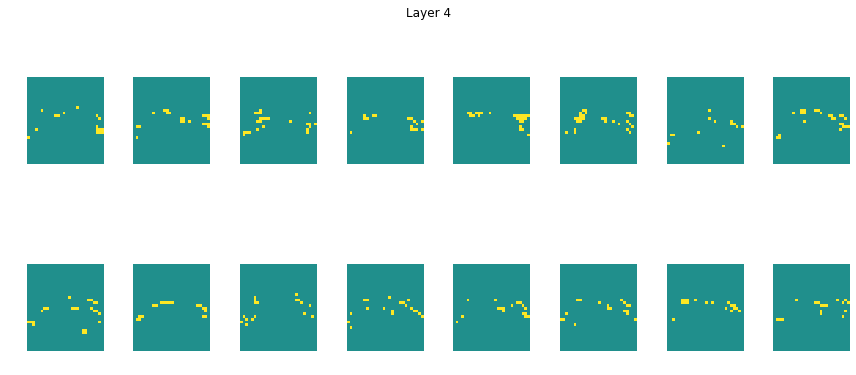

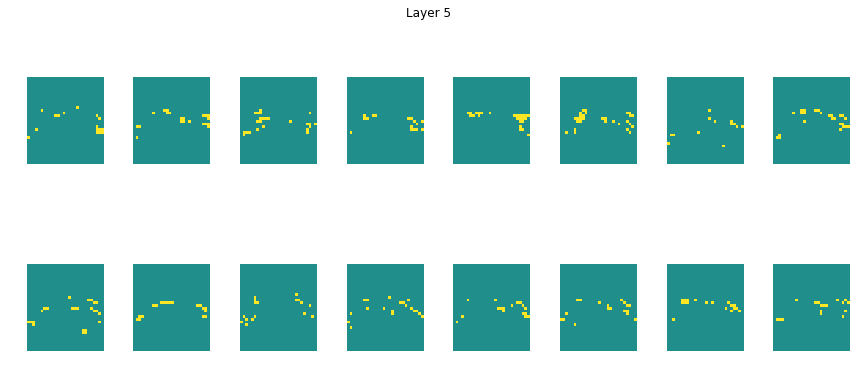

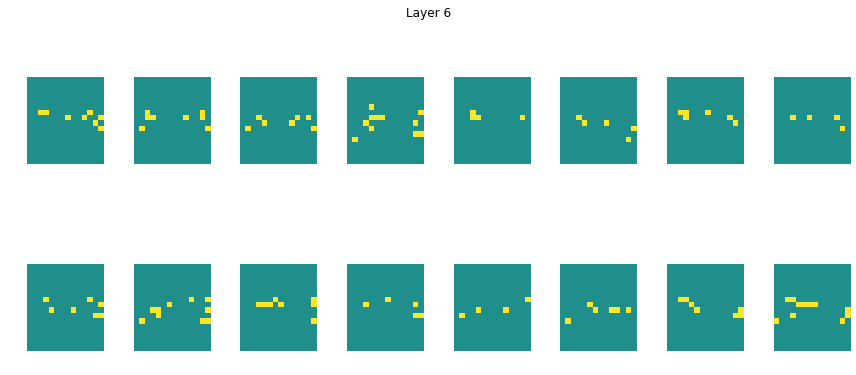

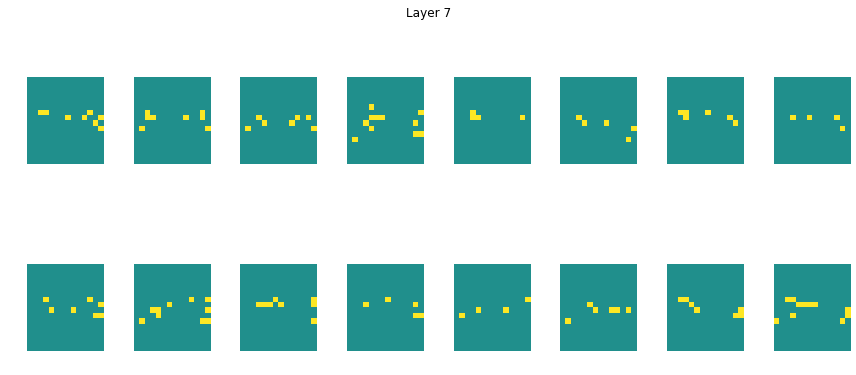

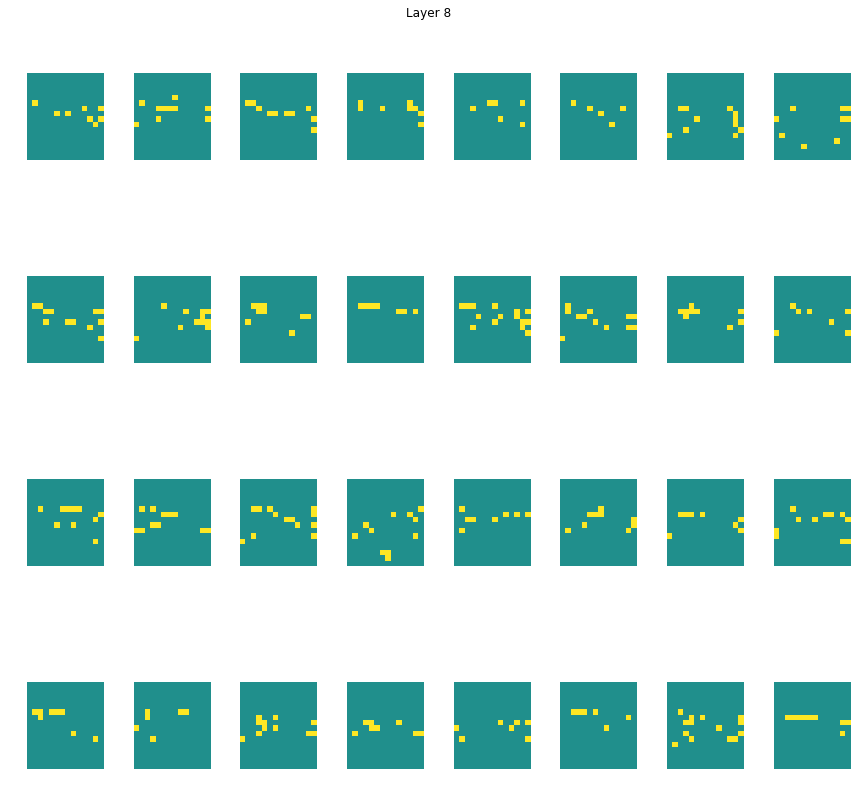

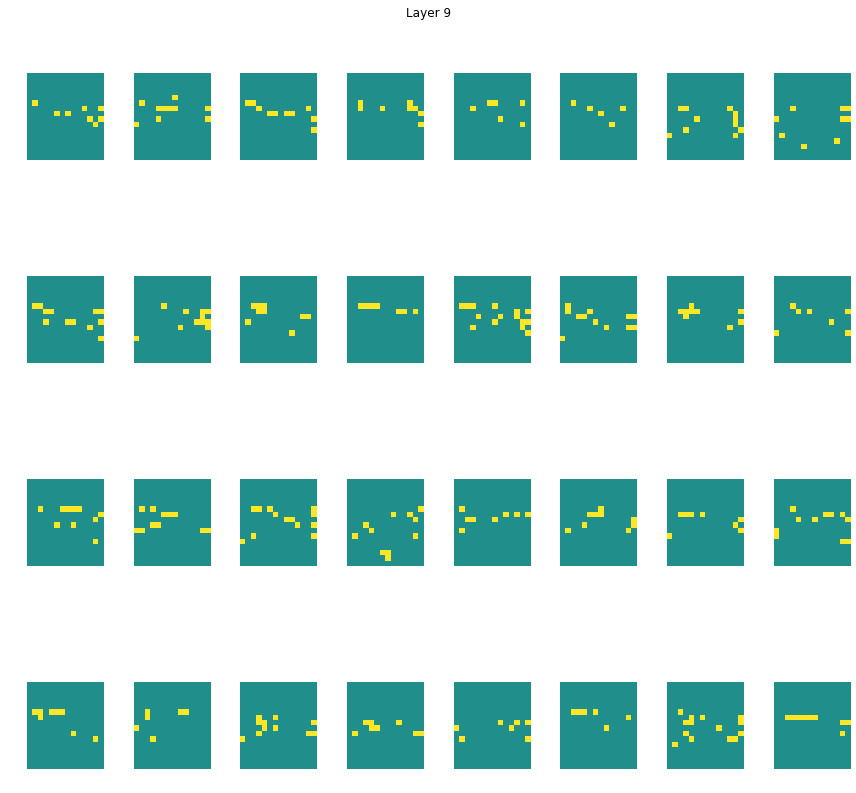

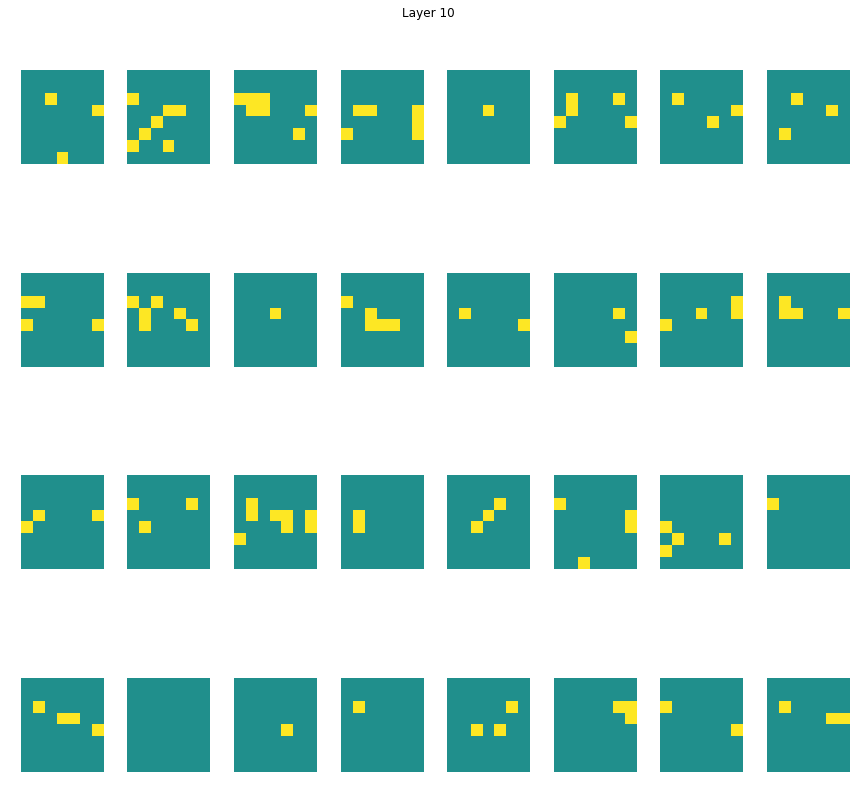

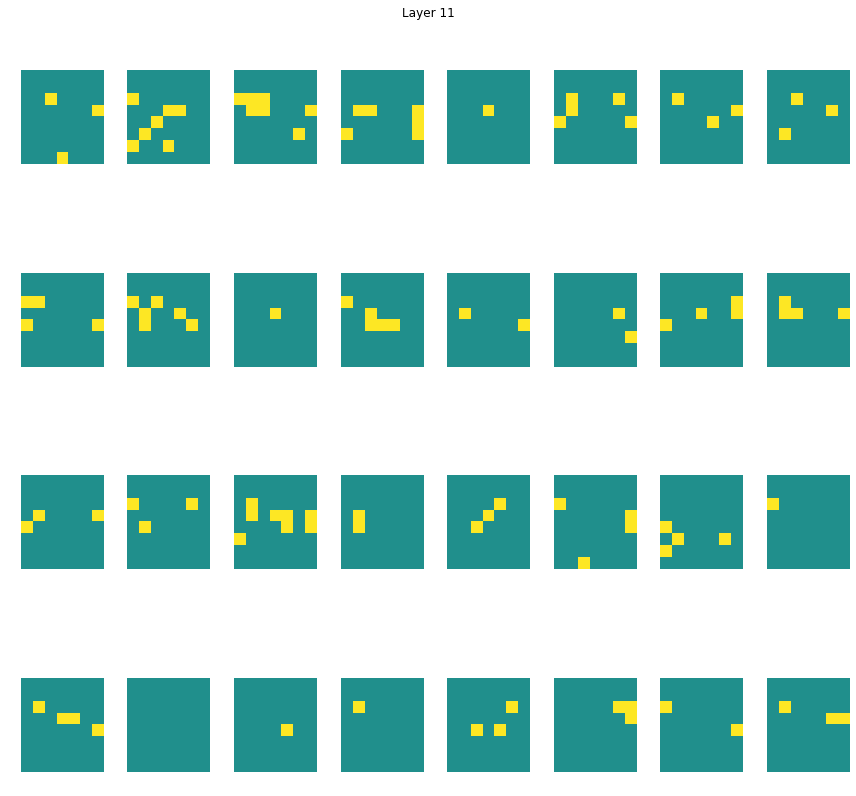

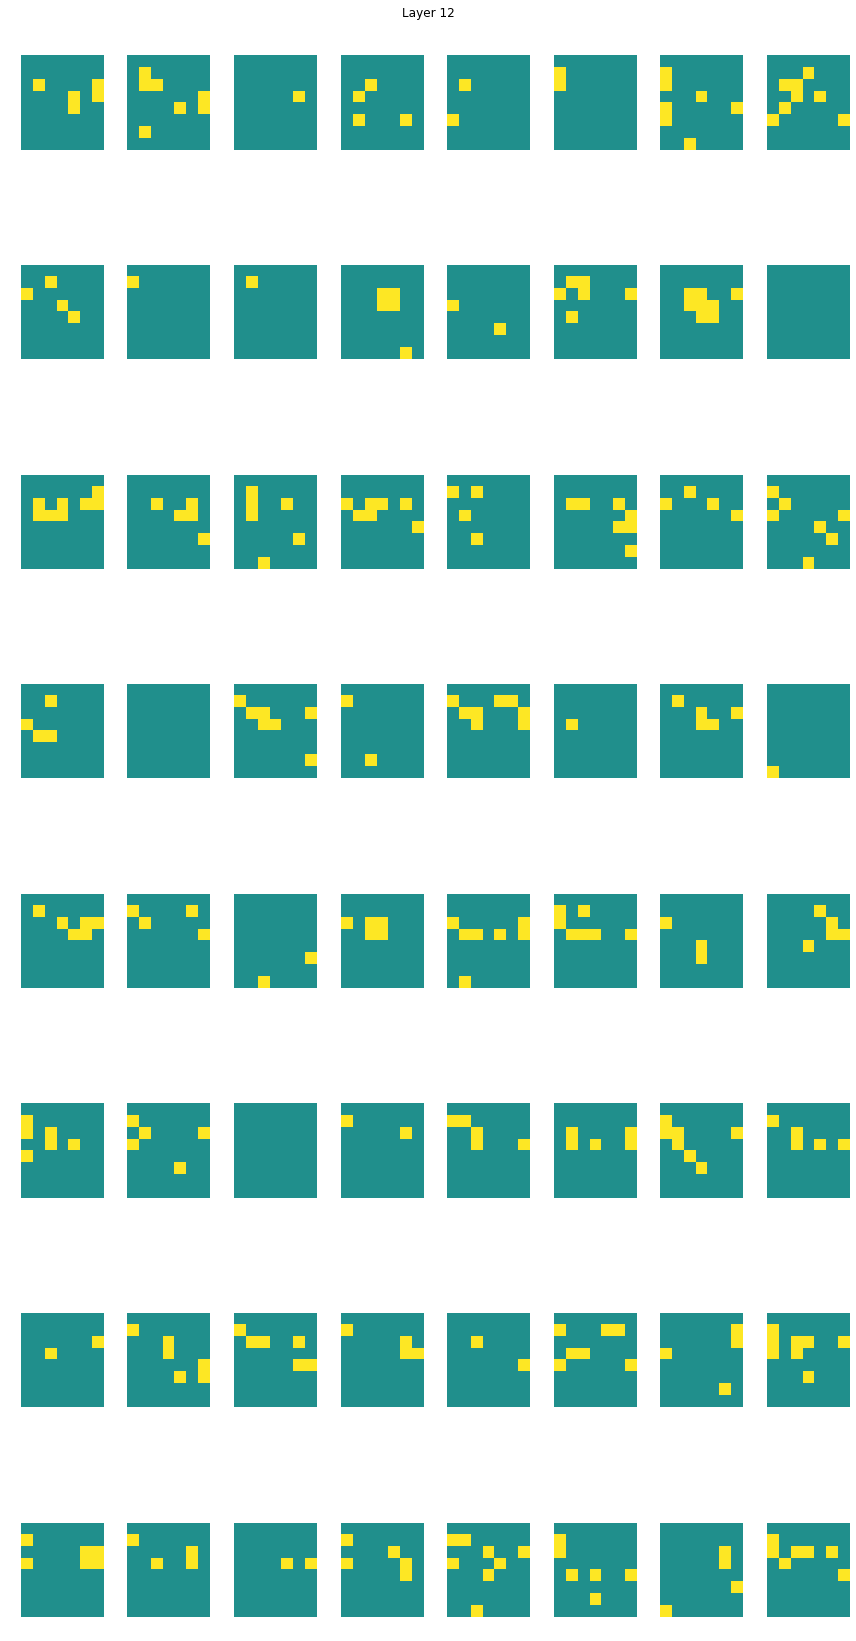

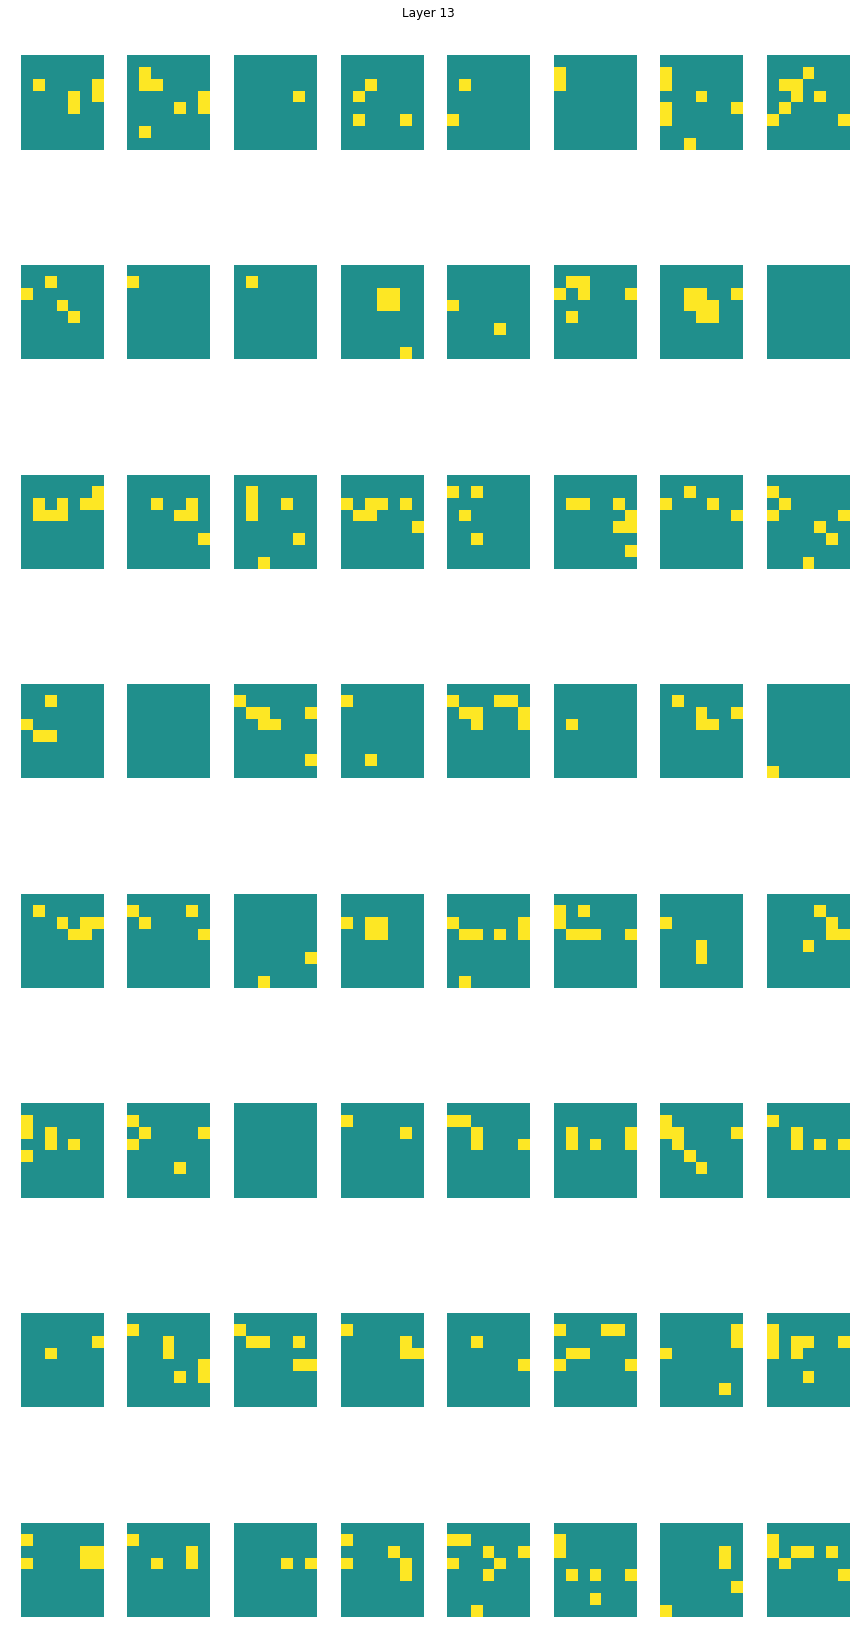

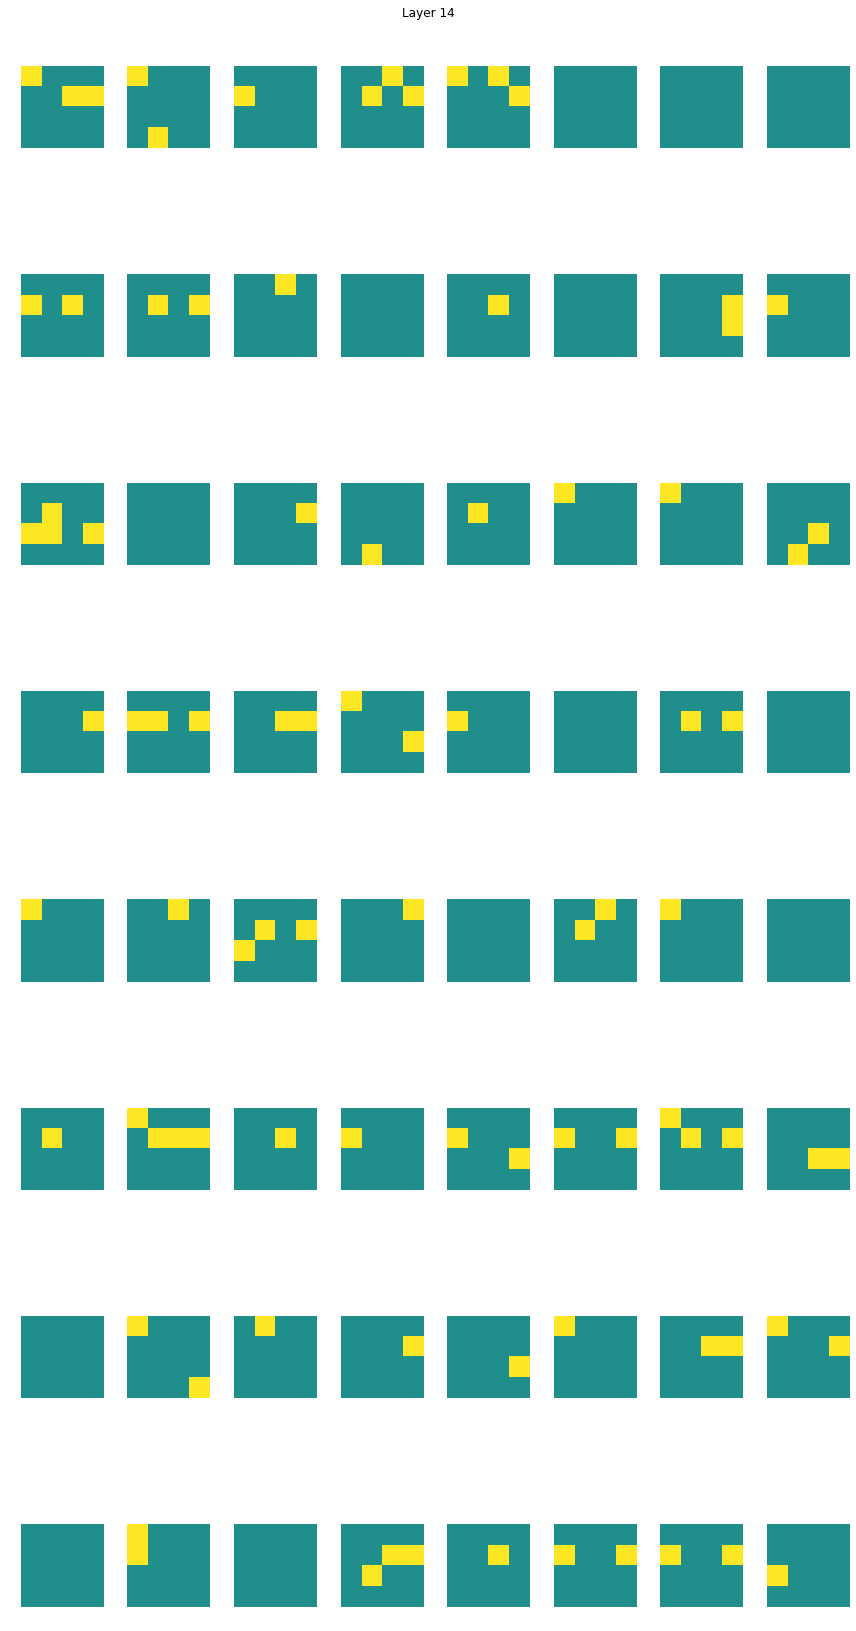

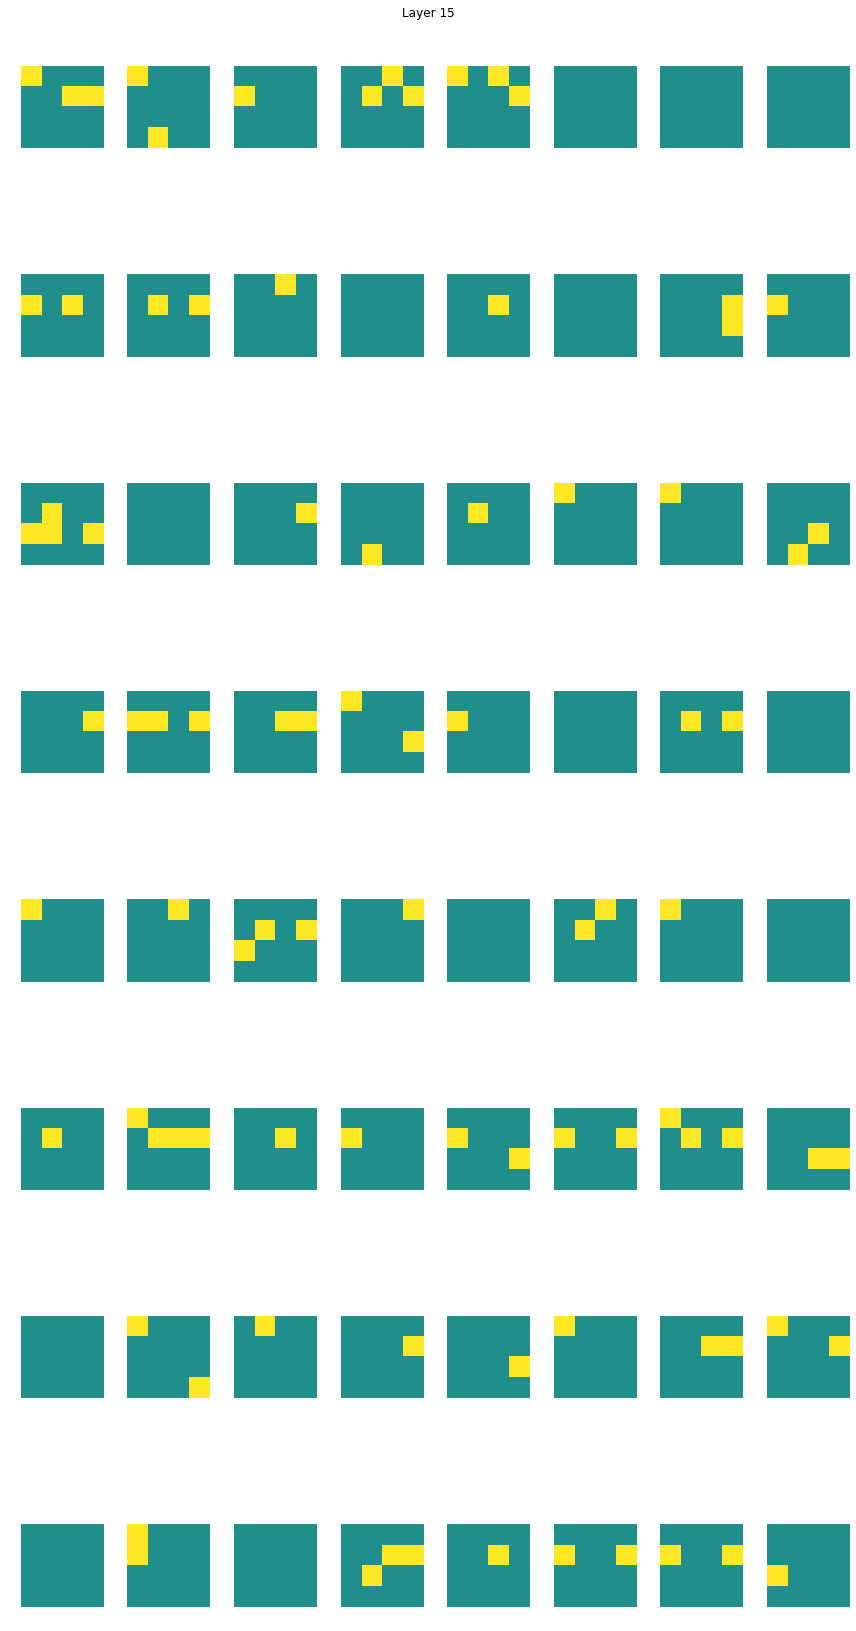

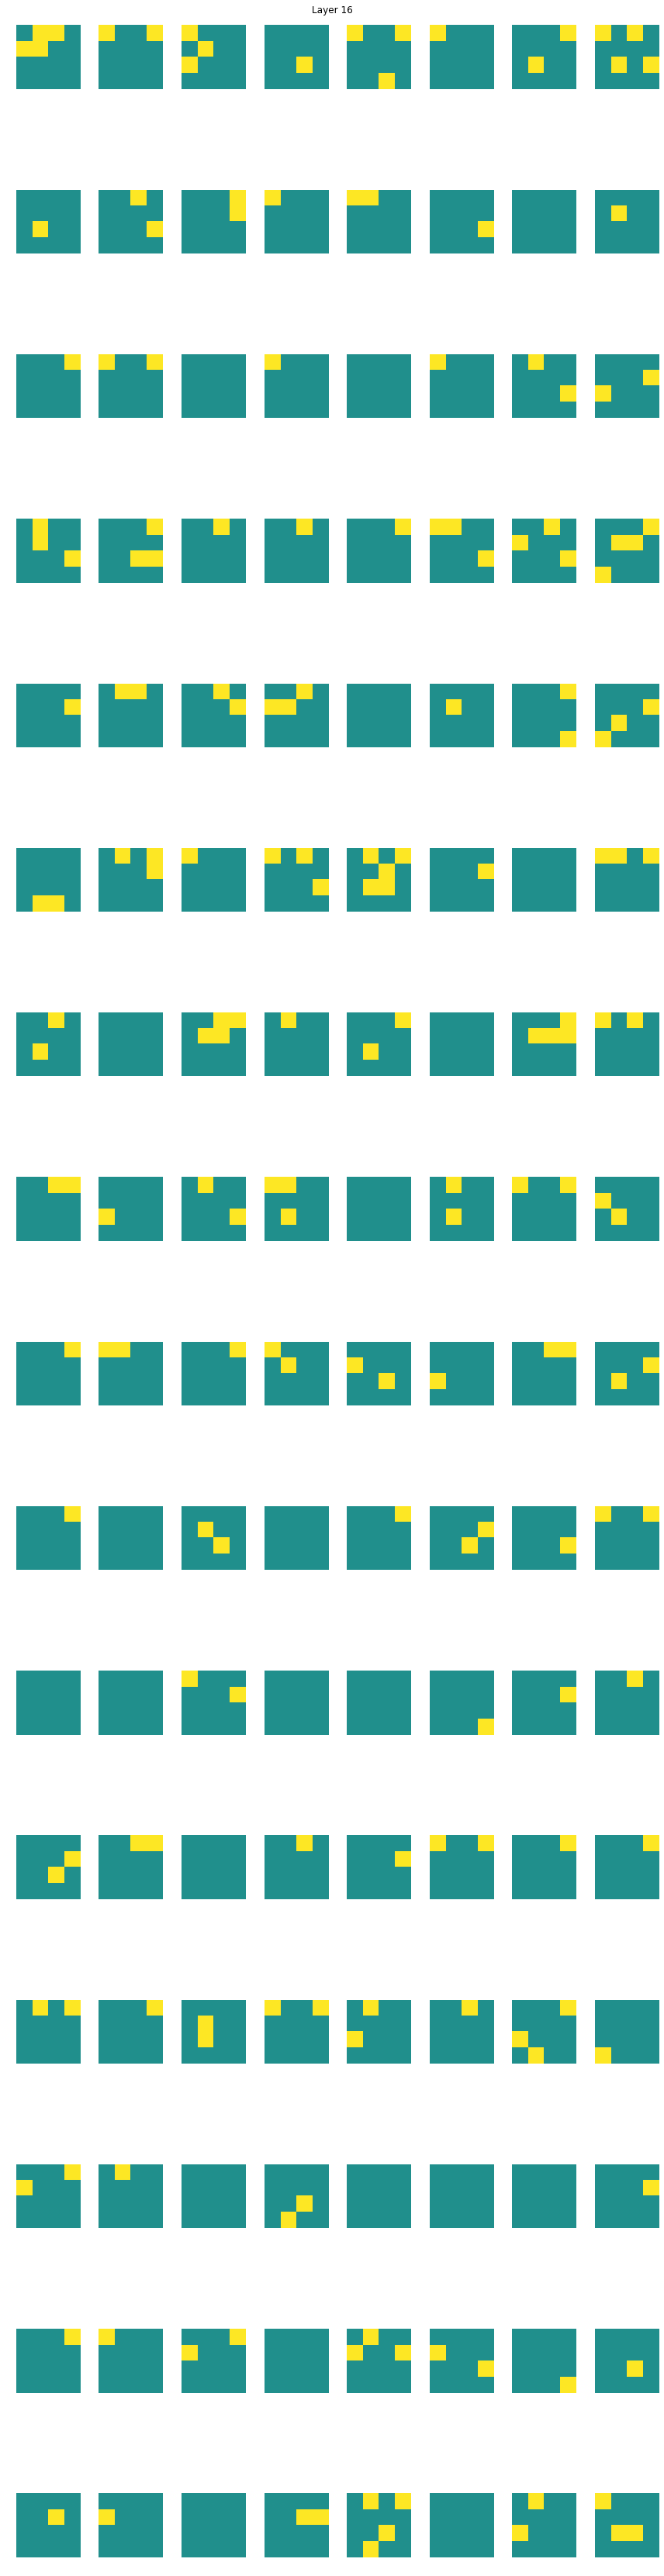

In [ ]:
Visualizer.show_all_correlation(corrs_round_1, pearson = False, threshold = 0.2)

In [ ]:
Visualizer.show_all_correlation(corrs_round_1, save_path = Utils.get_path(["02_autoencoder", "results"],
                                                        "correlation_activation_maps_pearson_round_1.jpg"))

Visualizer.show_all_correlation(corrs_round_1, threshold = 0.2,
                                save_path = Utils.get_path(["02_autoencoder", "results"],
                                            "correlation_activation_maps_pearson_round_1_threshold.jpg"))

Visualizer.show_all_correlation(corrs_round_1, pearson = False,
                                save_path = Utils.get_path(["02_autoencoder", "results"],
                                            "correlation_activation_maps_spearman_round_1.jpg"))

Visualizer.show_all_correlation(corrs_round_1, pearson = False, threshold = 0.2,
                                save_path = Utils.get_path(["02_autoencoder", "results"],
                                            "correlation_activation_maps_spearman_round_1_threshold.jpg"))

### Show activations of high correlations during all 3 rounds

__Find activations which have high correlations with the neuro spikes during all rounds.__

In [ ]:
def get_round_matches(rounds, threshold, pearson = True):
    first_round = [c for c in rounds[0] if abs(c.pearson if pearson else c.spearman) > threshold]
    first_round = sorted(first_round, key=lambda x: x.pearson if pearson else x.spearman)
    
    votes = [0 for i in range(len(first_round))]
    
    for round_num in range(1, len(rounds)):
        next_round = rounds[round_num]
        
        for corr_num in range(len(first_round)):
            corr = first_round[corr_num]
            
            if abs(next_round[corr.index].pearson if pearson else next_round[corr.index].spearman) > threshold:
                votes[corr_num] += 1
    
    matches = []
    for vote_num in range(len(votes)):
        if votes[vote_num] == len(rounds) - 1:
            matches.append(first_round[vote_num])
            
    return matches

In [ ]:
matches = get_round_matches([corrs_round_1, corrs_round_2, corrs_round_3], 0.19)

[m.get_infos() for m in matches]

['layer 1, activation 7, row 32, column 48, pearson -0.29832157181846547, spearman -0.2707389515253926',
 'layer 1, activation 7, row 26, column 40, pearson -0.2893064921615911, spearman -0.1764563594338806',
 'layer 0, activation 7, row 26, column 40, pearson -0.28294949093545585, spearman -0.1764563594338806',
 'layer 17, activation 59, row 0, column 1, pearson -0.20413026115423102, spearman -0.22443261480806168',
 'layer 15, activation 38, row 1, column 0, pearson 0.20243199399769352, spearman 0.19579469975630823']

In [ ]:
for match in matches:
    fig = Visualizer.show_correlation(match, start_round_frames[2] + 780, model_loader, model_loader.model.encoder)
    Utils.add_fig_to_image(fig)
    
Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"], "matches_pearson.jpg"))

In [ ]:
matches_spearman = get_round_matches([corrs_round_1, corrs_round_2, corrs_round_3], 0.18, pearson = False)

[m.get_infos() for m in matches_spearman]

['layer 8, activation 10, row 8, column 1, pearson -0.18215519039691727, spearman -0.2108503570484379',
 'layer 9, activation 10, row 8, column 1, pearson -0.19342941517704879, spearman -0.2108502923767016',
 'layer 10, activation 19, row 4, column 0, pearson -0.22208173894411345, spearman -0.1876640983494713',
 'layer 11, activation 19, row 4, column 0, pearson -0.2193570088194138, spearman -0.1876640983494713',
 'layer 4, activation 5, row 18, column 3, pearson 0.18255713083876005, spearman 0.18926761629925493',
 'layer 5, activation 5, row 18, column 3, pearson 0.18211817785352277, spearman 0.18926761629925493',
 'layer 14, activation 38, row 1, column 0, pearson 0.19715379718200024, spearman 0.19579469975630823',
 'layer 15, activation 38, row 1, column 0, pearson 0.20243199399769352, spearman 0.19579469975630823']

In [ ]:
for match in matches_spearman:
    fig = Visualizer.show_correlation(match, start_round_frames[2] + 780, model_loader, model_loader.model.encoder)
    Utils.add_fig_to_image(fig)

Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"], "matches_spearman.jpg"))

## Round analysis with flight lines only

__Exlude flight turns which always have high spike rate activity and high correlations.__

In [ ]:
start_flight_lines_round_1 = [630, 1190, 1570, 1921]
end_flight_lines_round_1 = [1034, 1385, 1720, 2117]

start_flight_lines_round_2 = [2900, 3462, 3786, 4183]
end_flight_lines_round_2 = [3300, 3651, 3979, 4368]

start_flight_lines_round_3 = [4580, 5135, 5481, 5866]
end_flight_lines_round_3 = [4981, 5327, 5646, 6050]

In [ ]:
neuro_spikes_round_1 = DataLoader.load_neuro_data(model_loader, csv_file_path, spike_type_row = 8,
                                                  start_frame = 600,
                                                  start_frames = start_flight_lines_round_1,
                                                  end_frames = end_flight_lines_round_1)

activations_round_1 = DataLoader.load_activations(model_loader, start_flight_lines_round_1,
                                                  end_flight_lines_round_1)

__Normalized histogram:__

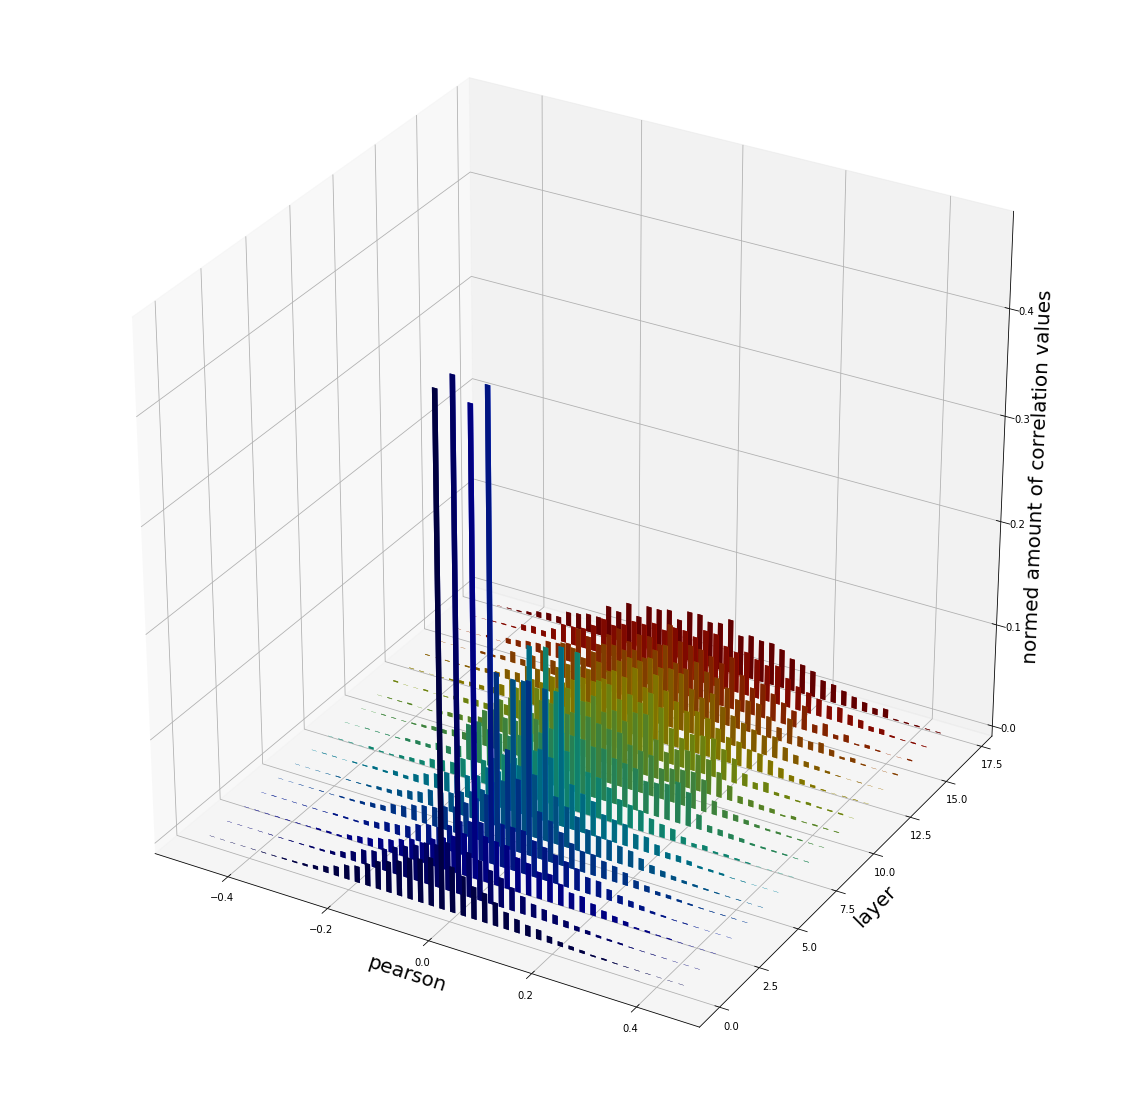

In [ ]:
Helper.global_hist(activations_round_1, neuro_spikes_round_1, norm = True)

## Autocorrelation

__Check if activation and neuro spike signals are recorded synchronously. One of those signals is slightly shifted back and forth to see if higher correlation values can be achieved.__

In [ ]:
def get_auto_corrs(activation_series, neuro_series, start_frame, end_frame, frame_margin):
    auto_corrs = []

    activation_time_series = activation_series[start_frame + (frame_margin // 2) : end_frame - (frame_margin // 2)]

    for i in range(frame_margin):    
        neuro_time_series = neuro_series[start_frame + i : end_frame - (frame_margin - i)]

        corr = Correlation.Correlation(-1, -1, -1, -1, -1)
        corr.calculate_pearson(activation_time_series, neuro_time_series)
        corr.calculate_spearman(activation_time_series, neuro_time_series)
        
        auto_corrs.append(corr)
        
    return auto_corrs

def plot_autocorrelation(activation_neurons, neuro_spikes, corr, round_num, frame_margin):
    activation_series = corr.get_activation_series(activation_neurons)

    auto_corrs = get_auto_corrs(activation_series, neuro_spikes, start_round_frames[round_num],
                                end_round_frames[round_num], frame_margin)

    auto_corrs_pearson = [c.pearson for c in auto_corrs]
    auto_corrs_spearman = [c.spearman for c in auto_corrs]

    Visualizer.plot([auto_corrs_pearson, auto_corrs_spearman], labels = ["pearson", "spearman"])

    print("Max index: ", auto_corrs_pearson.index(max(auto_corrs_pearson[25:])), ", max pearson: ",
          max(auto_corrs_pearson[25:-25]))

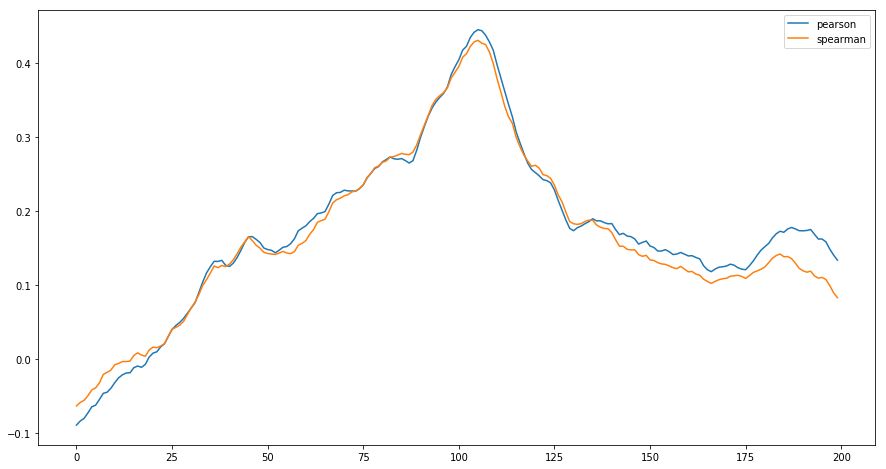

Max index:  105 , max pearson:  0.44480413216138476


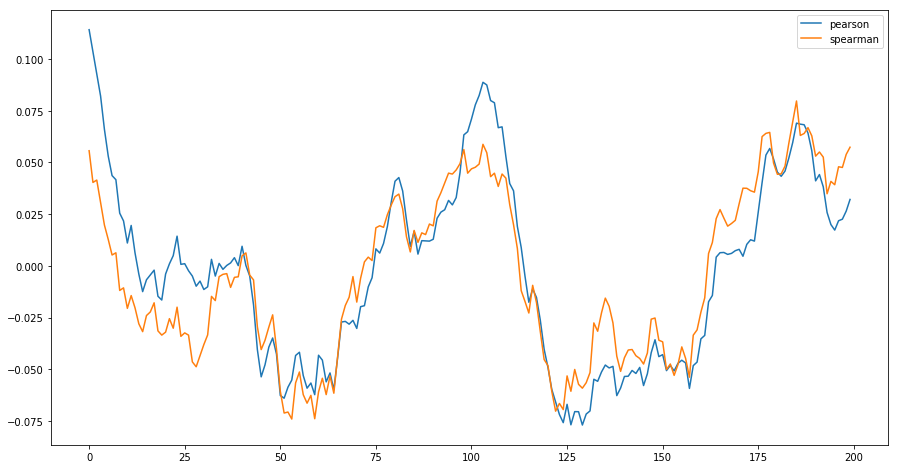

Max index:  103 , max pearson:  0.08874821015414508


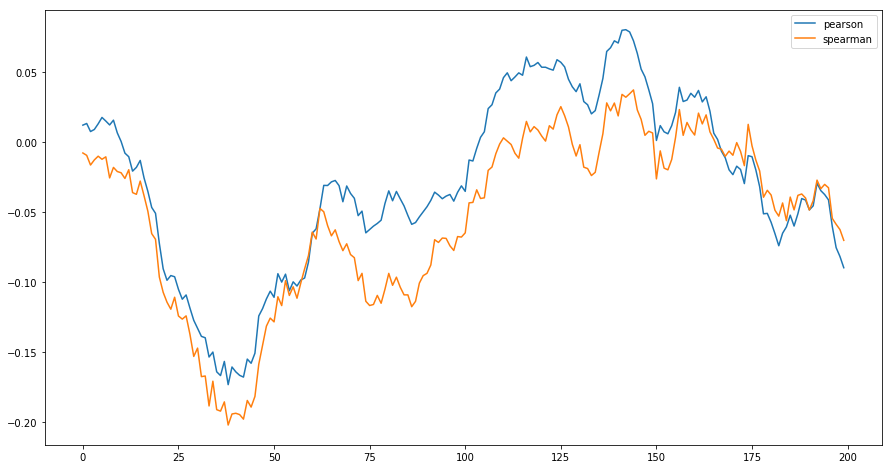

Max index:  142 , max pearson:  0.08040800695258263


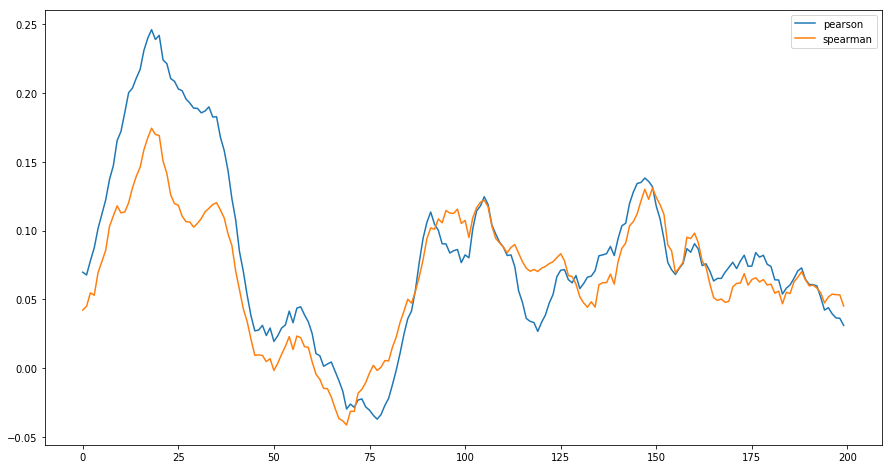

Max index:  25 , max pearson:  0.2031273685475277


In [ ]:
plot_autocorrelation(activations, neuro_spikes, max_pearson_round_1, 0, 200)
plot_autocorrelation(activations, neuro_spikes, corrs_round_1[3256], 0, 200)
plot_autocorrelation(activations, neuro_spikes, corrs_round_1[9728], 0, 200)
plot_autocorrelation(activations, neuro_spikes, corrs_round_1[13728], 0, 200)

__Shift neuro spike time series 5 frames back (5 * 0.1 seconds) as it shows a higher correlation in the graph above. Check if the shifted time series achieves higher correlations overall.__

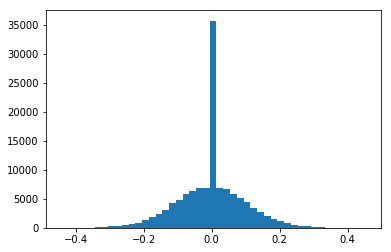

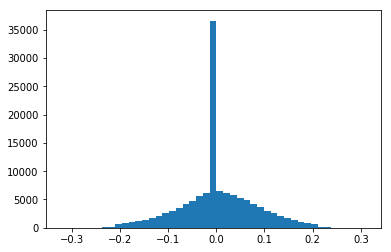

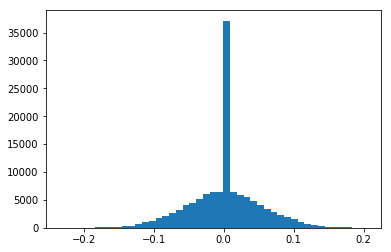

In [ ]:
neuro_spikes_shifted = np.array(neuro_spikes)
neuro_spikes_shifted = np.roll(neuro_spikes_shifted, -5)

corrs_auto_round_1 = Correlation.correlate(activations, neuro_spikes_shifted,
                                           start_round_frames[0], end_round_frames[0])

corrs_auto_round_2 = Correlation.correlate(activations, neuro_spikes_shifted,
                                           start_round_frames[1], end_round_frames[1])

corrs_auto_round_3 = Correlation.correlate(activations, neuro_spikes_shifted,
                                           start_round_frames[2], end_round_frames[2])

corrs_auto_round_1_without_nan = [c.pearson for c in corrs_auto_round_1
                                  if not math.isnan(c.pearson) and c.pearson != 0]

corrs_auto_round_2_without_nan = [c.pearson for c in corrs_auto_round_2
                                  if not math.isnan(c.pearson) and c.pearson != 0]

corrs_auto_round_3_without_nan = [c.pearson for c in corrs_auto_round_3
                                  if not math.isnan(c.pearson) and c.pearson != 0]

plt.hist(corrs_auto_round_1_without_nan, bins=45)
plt.show()

plt.hist(corrs_auto_round_2_without_nan, bins=45)
plt.show()

plt.hist(corrs_auto_round_3_without_nan, bins=45)
plt.show()

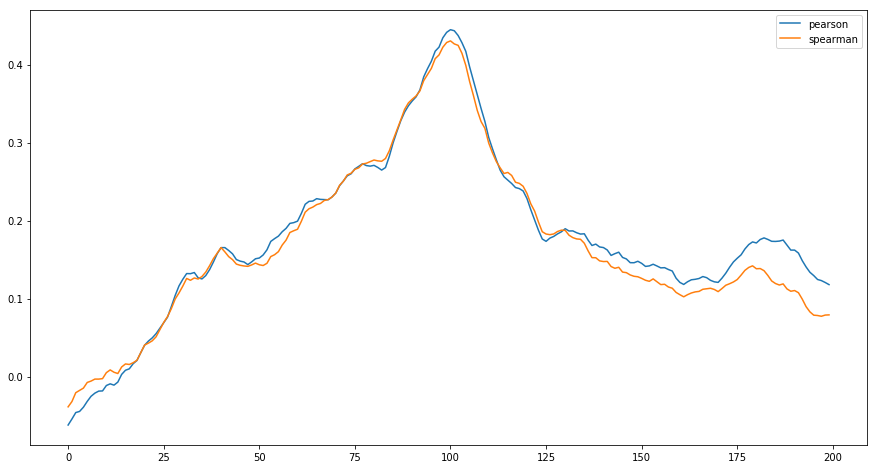

Max index:  100 , max pearson:  0.44480413216138476


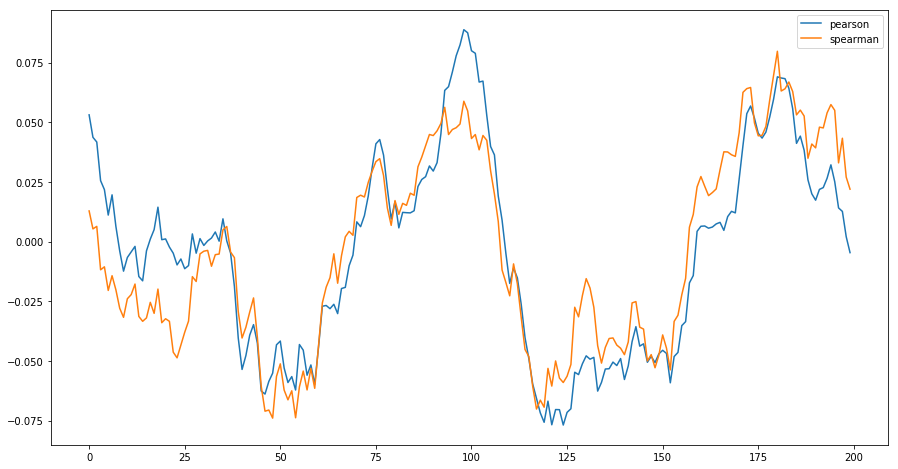

Max index:  98 , max pearson:  0.08874821015414508


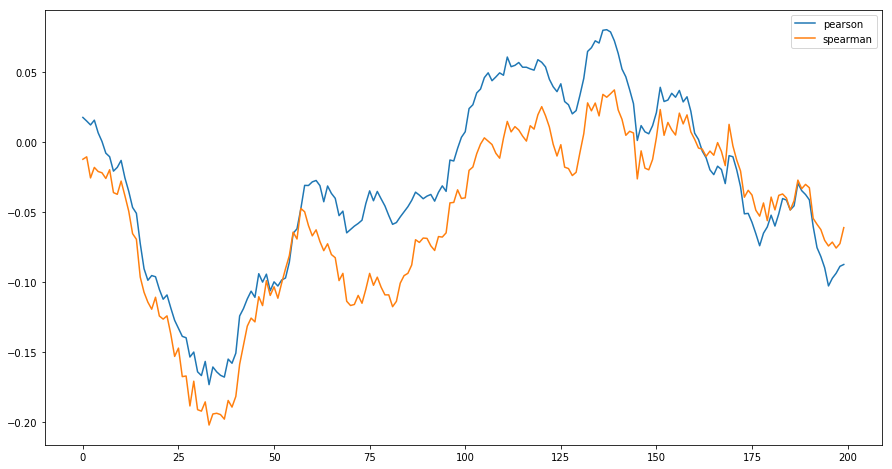

Max index:  137 , max pearson:  0.08040800695258263


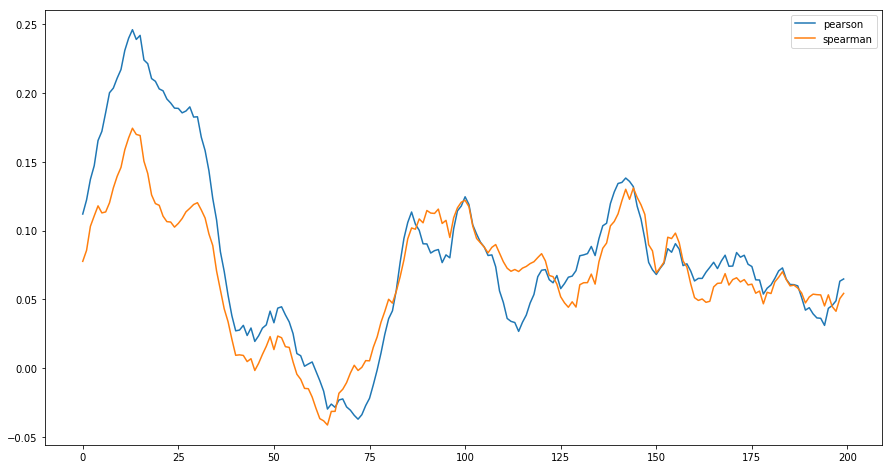

Max index:  28 , max pearson:  0.19005834351964038


In [ ]:
max_pearson_auto_round_1 = max(corrs_auto_round_1, key=attrgetter('pearson'))

plot_autocorrelation(activations, neuro_spikes_shifted, max_pearson_auto_round_1, 0, 200)
plot_autocorrelation(activations, neuro_spikes_shifted, corrs_round_1[3256], 0, 200)
plot_autocorrelation(activations, neuro_spikes_shifted, corrs_round_1[9728], 0, 200)
plot_autocorrelation(activations, neuro_spikes_shifted, corrs_round_1[13728], 0, 200)

__The shifted signal is correlated in smaller sub-sequences in the following section and compared to the non-shifted version.__

## Local analysis (time-slices)

__Correlate activations and neuro spikes in small time windows instead of whole rounds, e.g. in 5 second slices. First, compare the autocorrelation signal with shifted and non shifted neuro spikes.__

In [ ]:
max_corr_windowed = []
max_corr_shifted_windowed = []
window_size = 50

max_activation_pearson_auto_round_1 = max_pearson_auto_round_1.get_activation_series(activations)

for i in range(0, len(max_activation_pearson_auto_round_1), window_size):
    max_corr_windowed.append(Correlation.correlate_series(neuro_spikes, max_activation_pearson_auto_round_1,
                                                          start_frame = i, end_frame = i + window_size))
    
    max_corr_shifted_windowed.append(Correlation.correlate_series(neuro_spikes_shifted,
                                                                  max_activation_pearson_auto_round_1,
                                                                  start_frame = i, end_frame = i + window_size))
    
max(max_corr_windowed), max(max_corr_shifted_windowed)

(0.8258648327104826, 0.6890592050323915)

Correlation of max pearson value of round 1, 5 second slices, whole flight


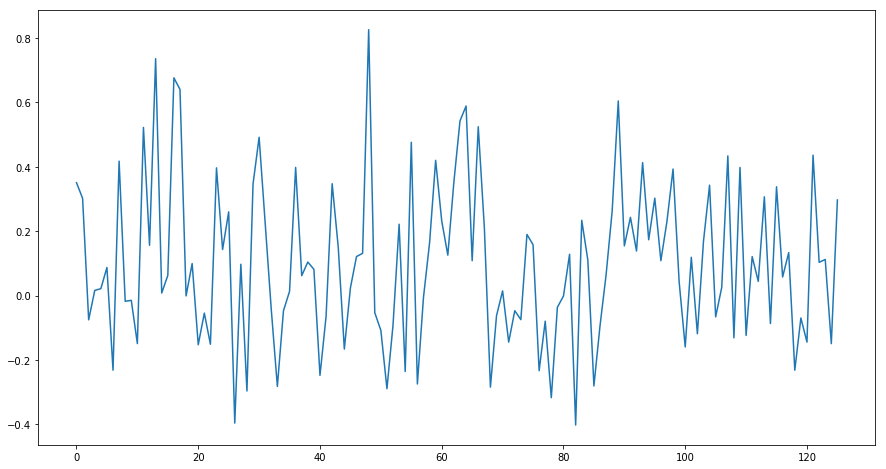

Same with sifted values of autocorrelation


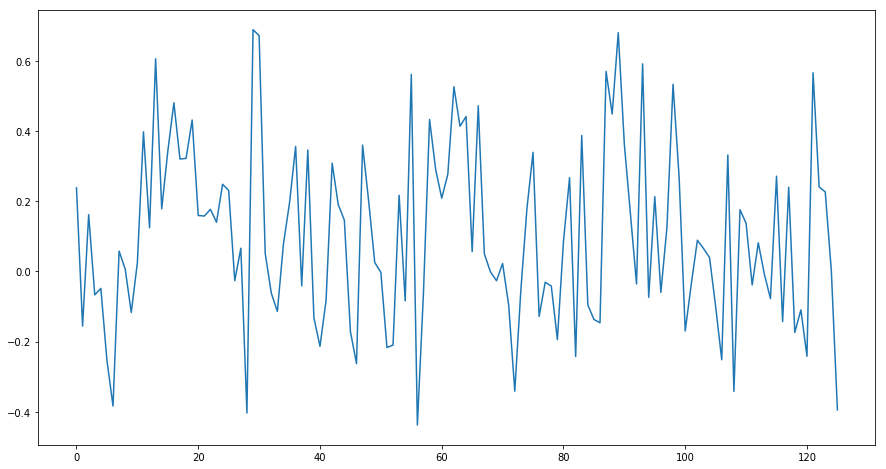

In [ ]:
print("Correlation of max pearson value of round 1, 5 second slices, whole flight")
Visualizer.plot([max_corr_windowed])

print("Same with sifted values of autocorrelation")
Visualizer.plot([max_corr_shifted_windowed])

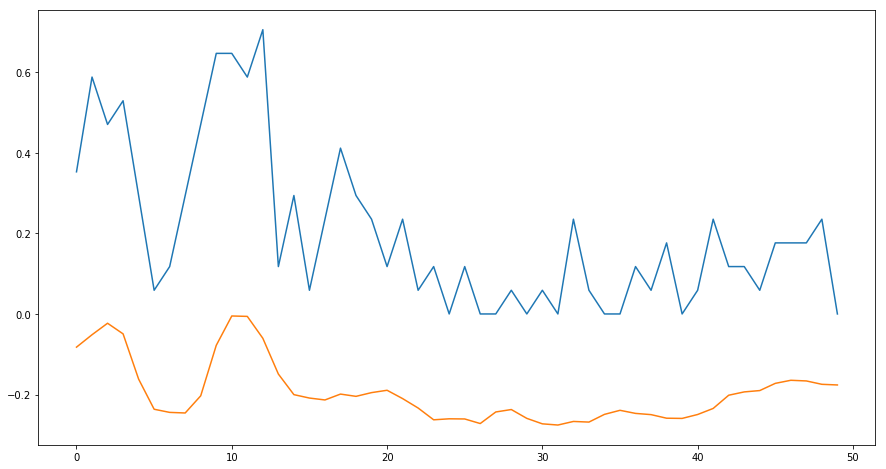

In [ ]:
index = max_corr_windowed.index(max(max_corr_windowed))

Visualizer.plot([neuro_spikes_norm, max_activation], index * window_size, (index * window_size) + window_size)

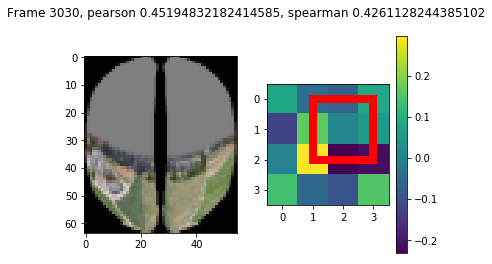

In [ ]:
fig = Visualizer.show_correlation(max_pearson_auto_round_1, start_round_frames[0] + (index * window_size),
                            model_loader, model_loader.model.encoder)

Comparison of max person (of round 1) during each round


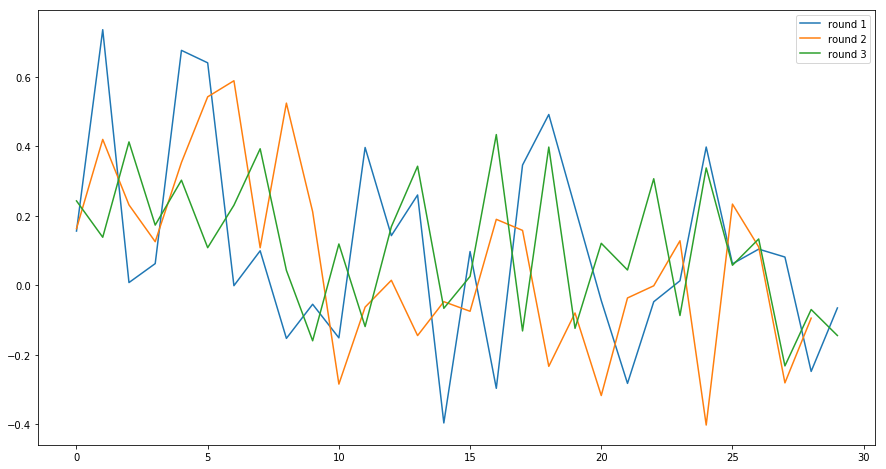

Same with sifted values of autocorrelation


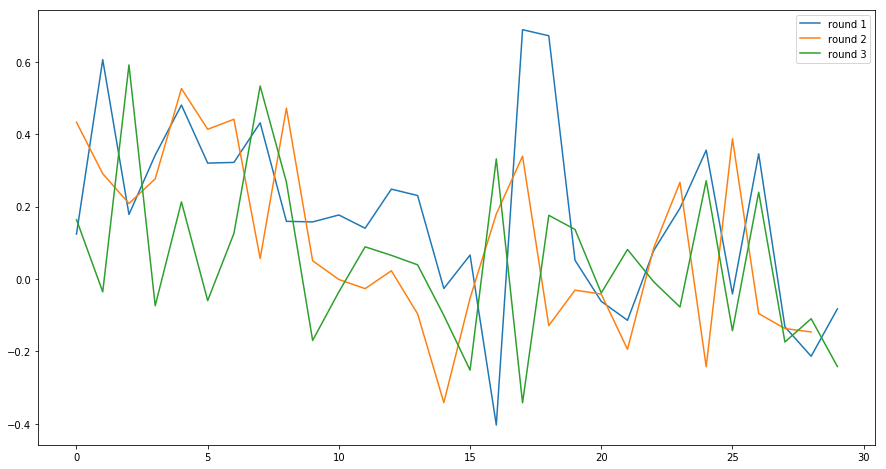

In [ ]:
graphs1 = [max_corr_windowed[start_round_frames[0] // window_size : end_round_frames[0] // window_size],
          max_corr_windowed[start_round_frames[1] // window_size : end_round_frames[1] // window_size],
          max_corr_windowed[start_round_frames[2] // window_size : end_round_frames[2] // window_size]]

graphs2 = [max_corr_shifted_windowed[start_round_frames[0] // window_size : end_round_frames[0] // window_size],
          max_corr_shifted_windowed[start_round_frames[1] // window_size : end_round_frames[1] // window_size],
          max_corr_shifted_windowed[start_round_frames[2] // window_size : end_round_frames[2] // window_size]]

print("Comparison of max person (of round 1) during each round")
Visualizer.plot_graphs(graphs1, ["round 1", "round 2", "round 3"])

print("Same with shifted values of autocorrelation")
Visualizer.plot_graphs(graphs2, ["round 1", "round 2", "round 3"])

__=> Shifting one signal does not lead to higher correlations between all activations and the neuro spike series. That is why in the following the shifted signal will no longer be used.__

### Generate all time-slices

__Calculate correlations of the neural spike time series with all activations in 5 second windows.__

In [ ]:
def get_max_cumulated_values(corrs_slices_round):
    max_pearson_value = 0
    max_pearson_corr = None

    max_spearman_value = 0
    max_spearman_corr = None

    for corr in corrs_slices_round:      
        pearson = sum(c for c in corr.pearson if not math.isnan(c))

        if pearson > max_pearson_value:
            max_pearson_value = pearson
            max_pearson_corr = corr

        if hasattr(corr, 'spearman'):
            spearman = sum(c for c in corr.spearman if not math.isnan(c))
            
            if spearman > max_spearman_value:
                max_spearman_value = spearman
                max_spearman_corr = corr
                
    return max_pearson_value, max_pearson_corr, max_spearman_value, max_spearman_corr

def get_max_values_per_slice(corrs_slices_round):
    count = len(corrs_slices_round[0].pearson)
    
    max_pearson_corr_values = [-1 for i in range(count)]
    max_pearson_corrs = [None for i in range(len(max_pearson_corr_values))]
    
    max_spearman_corr_values = [-1 for i in range(count)]
    max_spearman_corrs = [None for i in range(len(max_spearman_corr_values))]
    
    for corr in corrs_slices_round:            
        for c_i in range(len(corr.pearson)):
            if not math.isnan(corr.pearson[c_i]) and (abs(corr.pearson[c_i]) > max_pearson_corr_values[c_i] or math.isnan(max_pearson_corr_values[c_i])):
                max_pearson_corr_values[c_i] = corr.pearson[c_i]
                max_pearson_corrs[c_i] = corr
                    
            if hasattr(corr, 'spearman') and not math.isnan(corr.spearman[c_i]) and (abs(corr.spearman[c_i]) > max_spearman_corr_values[c_i] or math.isnan(max_spearman_corr_values[c_i])):
                max_spearman_corr_values[c_i] = corr.spearman[c_i]
                max_spearman_corrs[c_i] = corr
                    
    return max_pearson_corr_values, max_pearson_corrs, max_spearman_corr_values, max_spearman_corrs

def save_max_values_per_slice(max_sliced_corrs, round_num, slice_size, path):
    for i in range(len(max_sliced_corrs)):
        fig = Visualizer.show_correlation(max_sliced_corrs[i], start_round_frames[round_num] + (i * slice_size),
                                         model_loader, model_loader.model.encoder)
        Utils.add_fig_to_image(fig)
    
    Utils.save_combined_image(path)

In [ ]:
# Calculating slices with pearson & spearman takes much time. Set spearman to False to speed up calculation time.

corrs_slices_round_1 = Correlation.correlate(activations, neuro_spikes, start_frame = start_round_frames[0],
                                             end_frame = end_round_frames[0], window_size = 50, pearson = True,
                                             spearman = True)

corrs_slices_round_2 = Correlation.correlate(activations, neuro_spikes, start_frame = start_round_frames[1],
                                             end_frame = end_round_frames[1], window_size = 50, pearson = True,
                                             spearman = True)

corrs_slices_round_3 = Correlation.correlate(activations, neuro_spikes, start_frame = start_round_frames[2],
                                             end_frame = end_round_frames[2], window_size = 50, pearson = True,
                                             spearman = True)

In [ ]:
max_pearson_value_r1, max_pearson_corr_r1, max_spearman_value_r1, max_spearman_corr_r1 = get_max_cumulated_values(corrs_slices_round_1)
max_pearson_value_r2, max_pearson_corr_r2, max_spearman_value_r2, max_spearman_corr_r2 = get_max_cumulated_values(corrs_slices_round_2)
max_pearson_value_r3, max_pearson_corr_r3, max_spearman_value_r3, max_spearman_corr_r3 = get_max_cumulated_values(corrs_slices_round_3)

Round 1:
max cumulative pearson = 5.014817843428315, max cumulative spearman = 4.947870829796616
pearson: layer 5, activation 1, row 14, column 21
spearman: layer 4, activation 1, row 14, column 21


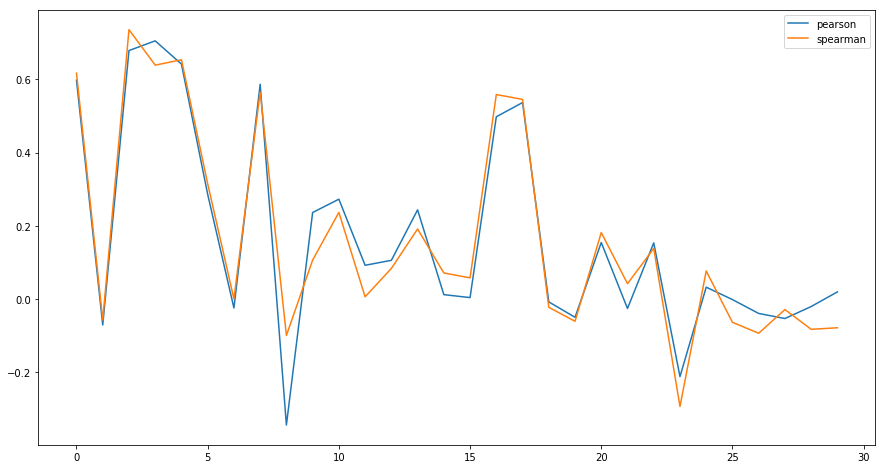

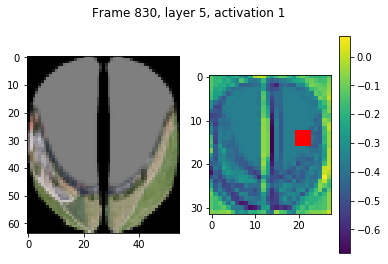

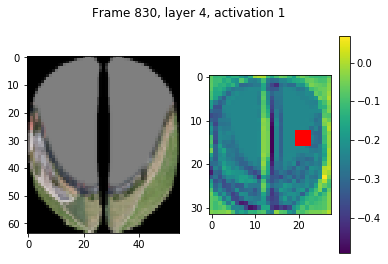

Round 2:
max cumulative pearson = 5.3235154995433565, max cumulative spearman = 5.242291880319963
pearson: layer 9, activation 13, row 8, column 9
spearman: layer 8, activation 13, row 8, column 9


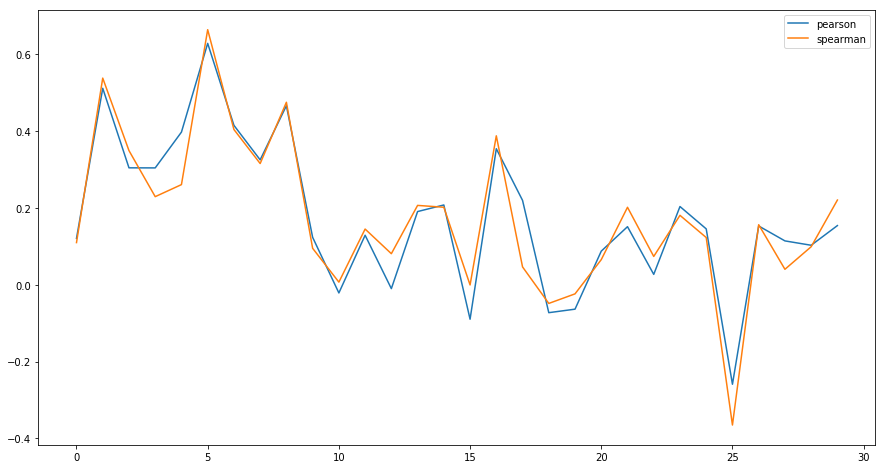

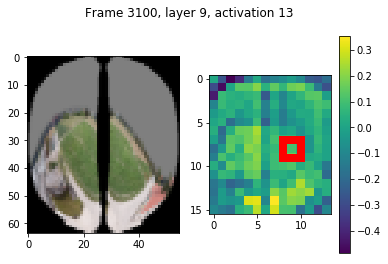

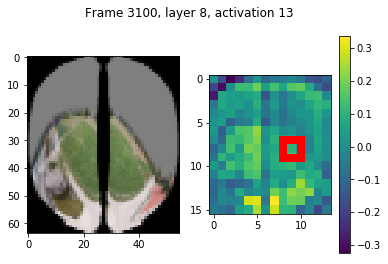

Round 3:
max cumulative pearson = 4.751748741917719, max cumulative spearman = 4.795857520472228
pearson: layer 6, activation 6, row 9, column 12
spearman: layer 16, activation 113, row 0, column 2


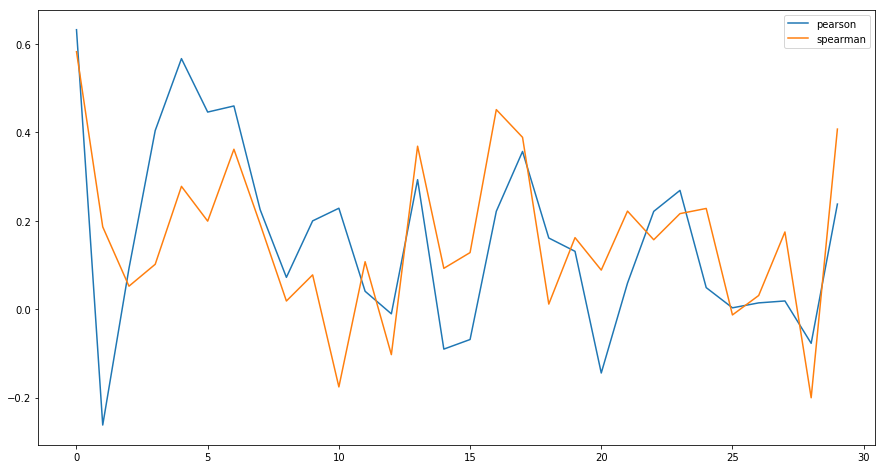

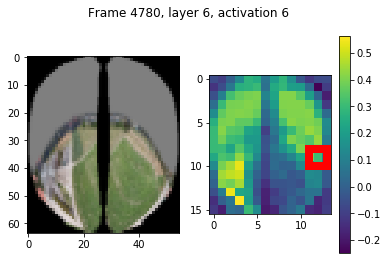

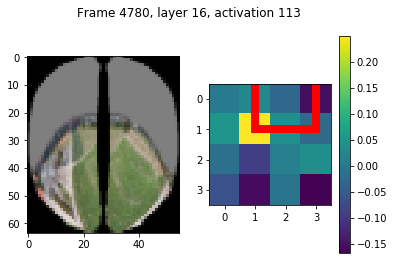

In [ ]:
print("Round 1:")
print("max cumulative pearson = {}, max cumulative spearman = {}".format(max_pearson_value_r1,
                                                                         max_spearman_value_r1))

print("pearson: layer {}, activation {}, row {}, column {}".format(max_pearson_corr_r1.layer,
      max_pearson_corr_r1.activation, max_pearson_corr_r1.row, max_pearson_corr_r1.column))

print("spearman: layer {}, activation {}, row {}, column {}".format(max_spearman_corr_r1.layer,
      max_spearman_corr_r1.activation, max_spearman_corr_r1.row, max_spearman_corr_r1.column))

Visualizer.plot_graphs([max_pearson_corr_r1.pearson, max_spearman_corr_r1.spearman], ["pearson", "spearman"])
_ = Visualizer.show_correlation(max_pearson_corr_r1, start_round_frames[0] + 200, model_loader,
                                model_loader.model.encoder)
_ = Visualizer.show_correlation(max_spearman_corr_r1, start_round_frames[0] + 200, model_loader,
                                model_loader.model.encoder)

print("Round 2:")
print("max cumulative pearson = {}, max cumulative spearman = {}".format(max_pearson_value_r2,
                                                                         max_spearman_value_r2))

print("pearson: layer {}, activation {}, row {}, column {}".format(max_pearson_corr_r2.layer,
      max_pearson_corr_r2.activation, max_pearson_corr_r2.row, max_pearson_corr_r2.column))

print("spearman: layer {}, activation {}, row {}, column {}".format(max_spearman_corr_r2.layer,
      max_spearman_corr_r2.activation, max_spearman_corr_r2.row, max_spearman_corr_r2.column))

Visualizer.plot_graphs([max_pearson_corr_r2.pearson, max_spearman_corr_r2.spearman], ["pearson", "spearman"])
_ = Visualizer.show_correlation(max_pearson_corr_r2, start_round_frames[1] + 200, model_loader,
                                model_loader.model.encoder)
_ = Visualizer.show_correlation(max_spearman_corr_r2, start_round_frames[1] + 200, model_loader,
                                model_loader.model.encoder)

print("Round 3:")
print("max cumulative pearson = {}, max cumulative spearman = {}".format(max_pearson_value_r3,
                                                                         max_spearman_value_r3))

print("pearson: layer {}, activation {}, row {}, column {}".format(max_pearson_corr_r3.layer,
      max_pearson_corr_r3.activation, max_pearson_corr_r3.row, max_pearson_corr_r3.column))

print("spearman: layer {}, activation {}, row {}, column {}".format(max_spearman_corr_r3.layer,
      max_spearman_corr_r3.activation, max_spearman_corr_r3.row, max_spearman_corr_r3.column))

Visualizer.plot_graphs([max_pearson_corr_r3.pearson, max_spearman_corr_r3.spearman], ["pearson", "spearman"])
_ = Visualizer.show_correlation(max_pearson_corr_r3, start_round_frames[2] + 200, model_loader,
                                model_loader.model.encoder)
_ = Visualizer.show_correlation(max_spearman_corr_r3, start_round_frames[2] + 200, model_loader,
                                model_loader.model.encoder)

Show locations of activations in their activation map which have the highest correlation values per 50 frame window:

In [ ]:
max_sliced_pearson_corr_values_r1, max_sliced_pearson_corrs_r1, max_sliced_spearman_corr_values_r1, max_sliced_spearman_corrs_r1 = get_max_values_per_slice(corrs_slices_round_1)
max_sliced_pearson_corr_values_r2, max_sliced_pearson_corrs_r2, max_sliced_spearman_corr_values_r2, max_sliced_spearman_corrs_r2 = get_max_values_per_slice(corrs_slices_round_2)
max_sliced_pearson_corr_values_r3, max_sliced_pearson_corrs_r3, max_sliced_spearman_corr_values_r3, max_sliced_spearman_corrs_r3 = get_max_values_per_slice(corrs_slices_round_3)

In [ ]:
paths_max_sliced_pearson_corrs = [Utils.get_path(["02_autoencoder", "results"],
                                                 "pearson_max_slice_50_round_1.jpg"),
                                  Utils.get_path(["02_autoencoder", "results"],
                                                 "pearson_max_slice_50_round_2.jpg"),
                                  Utils.get_path(["02_autoencoder", "results"],
                                                 "pearson_max_slice_50_round_3.jpg")]

paths_max_sliced_spearman_corrs = [Utils.get_path(["02_autoencoder", "results"],
                                                  "spearman_max_slice_50_round_1.jpg"),
                                   Utils.get_path(["02_autoencoder", "results"],
                                                  "spearman_max_slice_50_round_2.jpg"),
                                   Utils.get_path(["02_autoencoder", "results"],
                                                  "spearman_max_slice_50_round_3.jpg")]

save_max_values_per_slice(max_sliced_pearson_corrs_r1, 0, 50, paths_max_sliced_pearson_corrs[0])
save_max_values_per_slice(max_sliced_pearson_corrs_r2, 1, 50, paths_max_sliced_pearson_corrs[1])
save_max_values_per_slice(max_sliced_pearson_corrs_r3, 2, 50, paths_max_sliced_pearson_corrs[2])

save_max_values_per_slice(max_sliced_spearman_corrs_r1, 0, 50, paths_max_sliced_spearman_corrs[0])
save_max_values_per_slice(max_sliced_spearman_corrs_r2, 1, 50, paths_max_sliced_spearman_corrs[1])
save_max_values_per_slice(max_sliced_spearman_corrs_r3, 2, 50, paths_max_sliced_spearman_corrs[2])

combine_images_horizontally(paths_max_sliced_pearson_corrs, Utils.get_path(["02_autoencoder", "results"],
                                                                           "pearson_max_slice_50_combined.jpg"))
combine_images_horizontally(paths_max_sliced_spearman_corrs, Utils.get_path(["02_autoencoder", "results"],
                                                                            "spearman_max_slice_50_combined.jpg"))

### Pairwise correlation of window-correlated rounds

__Neuro spikes and activations are correlated in 5 second windows. Correlate the time series of correlates during different flight rounds.__

In [ ]:
def show_corr_table(correlations):
    data = []
    for i in range(len(correlations)):
        row = []
        
        for j in range(len(correlations)):
            p = Correlation._pearson(correlations[i], correlations[j])
            row.append(p)

        data.append(row)

    return pd.DataFrame(data, columns = ["Round 1", "Round 2", "Round 3"],
                        index = ["Round 1", "Round 2", "Round 3"])

def get_corr_at_same_activation(corr_slices_round, search_corr):
    for corr in corr_slices_round:
        if corr.layer == search_corr.layer and corr.filter_num == search_corr.filter_num and \
           corr.row == search_corr.row and corr.col == search_corr.col:
                    
            return corr

In [ ]:
print("Correlations of maximum sums of each round:")

table1 = show_corr_table([max_pearson_corr_r1.pearson, max_pearson_corr_r2.pearson, max_pearson_corr_r3.pearson])
display(table1)

print("\n\nCorrelations of maximum sum of first round and correlations of round 2 and 3 of same activation:")

r1 = max_pearson_corr_r1.pearson
r2 = get_corr_at_same_activation(corrs_slices_round_2, max_pearson_corr_r1).pearson
r3 = get_corr_at_same_activation(corrs_slices_round_3, max_pearson_corr_r1).pearson

table2 = show_corr_table([r1 ,r2 ,r3])
display(table2)

print("\n\nCorrelations of maximum sum of second round and correlations of round 1 and 3 of same activation:")

r1 = get_corr_at_same_activation(corrs_slices_round_1, max_pearson_corr_r2).pearson
r2 = max_pearson_corr_r2.pearson
r3 = get_corr_at_same_activation(corrs_slices_round_3, max_pearson_corr_r2).pearson

table3 = show_corr_table([r1 ,r2 ,r3])
display(table3)

print("\n\nCorrelations of maximum sum of third round and correlations of round 1 and 2 of same activation:")

r1 = get_corr_at_same_activation(corrs_slices_round_1, max_pearson_corr_r3).pearson
r2 = get_corr_at_same_activation(corrs_slices_round_2, max_pearson_corr_r3).pearson
r3 = max_pearson_corr_r3.pearson

table4 = show_corr_table([r1 ,r2 ,r3])
display(table4)

Correlations of maximum sums of each round:


Round 1   Round 2   Round 3
Round 1  1.000000  0.232581  0.565165
Round 2  0.232581  1.000000  0.297491
Round 3  0.565165  0.297491  1.000000



Correlations of maximum sum of first round and correlations of round 2 and 3 of same activation:


Round 1   Round 2   Round 3
Round 1  1.000000  0.421734  0.465177
Round 2  0.421734  1.000000  0.196614
Round 3  0.465177  0.196614  1.000000



Correlations of maximum sum of second round and correlations of round 1 and 3 of same activation:


Round 1   Round 2   Round 3
Round 1  1.000000  0.276443  0.132897
Round 2  0.276443  1.000000  0.302667
Round 3  0.132897  0.302667  1.000000



Correlations of maximum sum of third round and correlations of round 1 and 2 of same activation:


Round 1   Round 2   Round 3
Round 1  1.000000  0.200693 -0.164691
Round 2  0.200693  1.000000 -0.049417
Round 3 -0.164691 -0.049417  1.000000

### Show activations of high correlations during all 3 rounds

__Find activations which have high correlations with the neuro spikes during all rounds in all 5 second windows.__

In [ ]:
def get_local_round_matches(rounds, threshold, pearson = True):
    matches = []
    
    for layer in range(len(rounds[0])):
        for corr_num in range(len(rounds[0][layer])):
            append = True
            
            for round_num in range(len(rounds)):
                append = append and (sum(rounds[round_num][layer][corr_num].pearson) > threshold)
                
            if append:
                matches.append(rounds[0][layer][corr_num])
                
    return matches

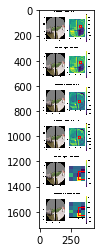

In [ ]:
matches = get_local_round_matches([corrs_slices_round_1, corrs_slices_round_2, corrs_slices_round_3], 2.9)

for match in matches:
    fig = Visualizer.show_correlation(match, start_round_frames[0] + 780, model_loader, model_loader.model.encoder)
    Utils.add_fig_to_image(fig)
    
Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"],
                                         "windowed_sum_threshold_matches_pearson.jpg"),
                          show_image = True)

### Sliding Window Correlations (SWC)

__The flight consists of multiple rounds. Do activations and neuro spikes reflect this periodicy? In the following, this is investigated with sliding window correlations. One fixed-size window of either an activation or neuro spike series is slided over the whole other series to correlate it with all parts of the same length.__

__Only pearson is used because previous results between pearson and spearman correlations are similar. Spearman takes more time to calculate than pearson.__

In [ ]:
def get_swc(fixed_series, moving_series, window_size, start_frame_fixed_window):
    swc_corrs = []
    
    fixed_time_series = fixed_series[start_frame_fixed_window : start_frame_fixed_window + window_size]

    for i in range(len(moving_series) - window_size):
        moving_time_series = moving_series[i : i + window_size]
        
        corr = Correlation.Correlation(-1, -1, -1, -1, -1)
        corr.calculate_pearson(fixed_time_series, moving_time_series)
        
        swc_corrs.append(corr)
        
    return swc_corrs

def plot_swc(neuro_series, corr, window_size, start_frame_fixed_window, fix_activation = True, smooth_points = 100,
             smoothness = 200):
    
    activation_series = corr.get_activation_series(activations)
    swc_corrs = []

    if fix_activation:
        swc_corrs = get_swc(activation_series, neuro_series, window_size, start_frame_fixed_window)
    else:
        swc_corrs = get_swc(neuro_series, activation_series, window_size, start_frame_fixed_window)
    
    execute_swc(swc_corrs, window_size, smooth_points, smoothness)
    
def execute_swc(swc_corrs, window_size, smooth_points, smoothness):
    auto_corrs_pearson = [c.pearson for c in swc_corrs]
    highlight = [start_round_frames[0], end_round_frames[0] - window_size,
                 start_round_frames[1], end_round_frames[1] - window_size,
                 start_round_frames[2], end_round_frames[2] - window_size]
    
    Visualizer.plot([auto_corrs_pearson], labels = ["pearson"], highlight_regions = highlight,
                    smooth_points = smooth_points, smoothness = smoothness)
    
    print("Max index: ", auto_corrs_pearson.index(max(auto_corrs_pearson[25:])),
          ", max pearson: ", max(auto_corrs_pearson[25:-25]))

####  Neuro Spikes x Activations

__Correlate a 50 frames window of either neuro spike series or an activation series with all possible windows of the other series with the same size. The rounds are highlighted in green.__

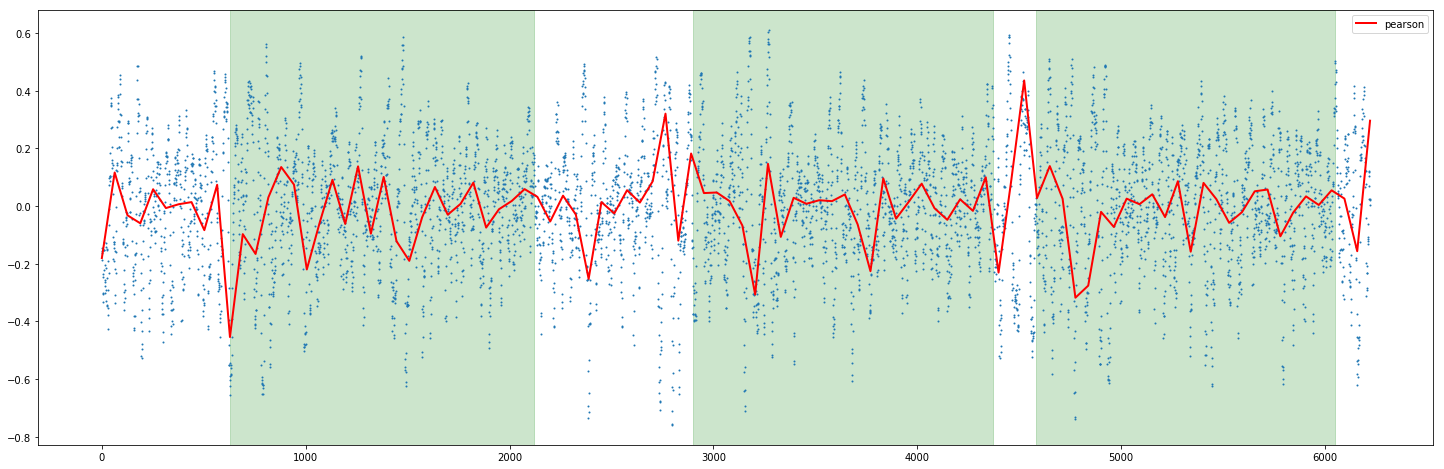

Max index:  3271 , max pearson:  0.6116435003875383


In [ ]:
plot_swc(neuro_spikes, max_pearson_round_1, 50,
         start_round_frames[0] + (end_round_frames[0] - start_round_frames[0]) // 2)

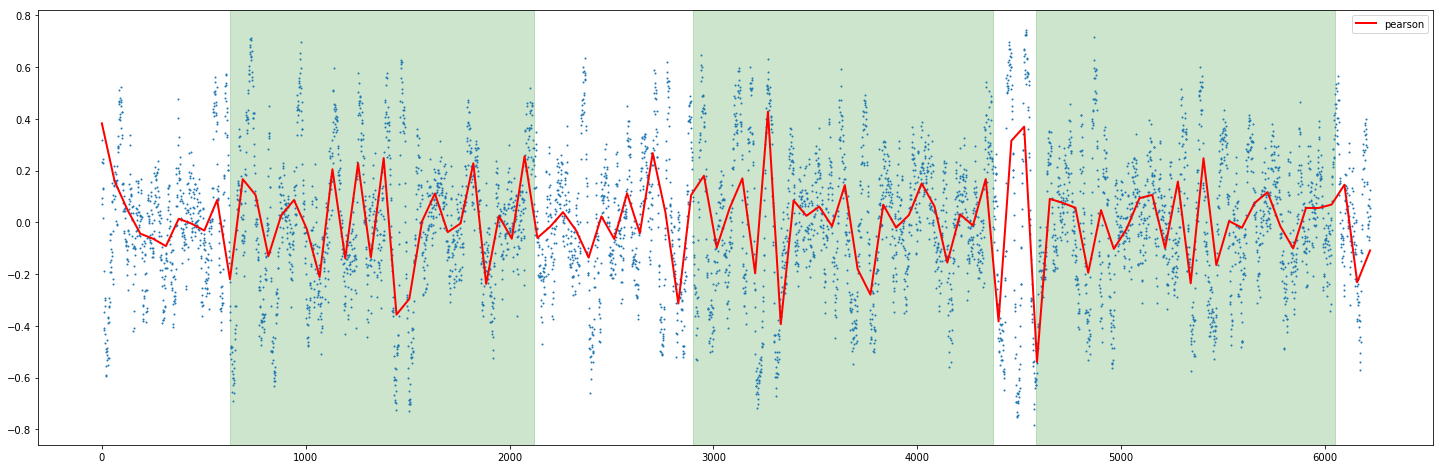

Max index:  4534 , max pearson:  0.7443693956355182


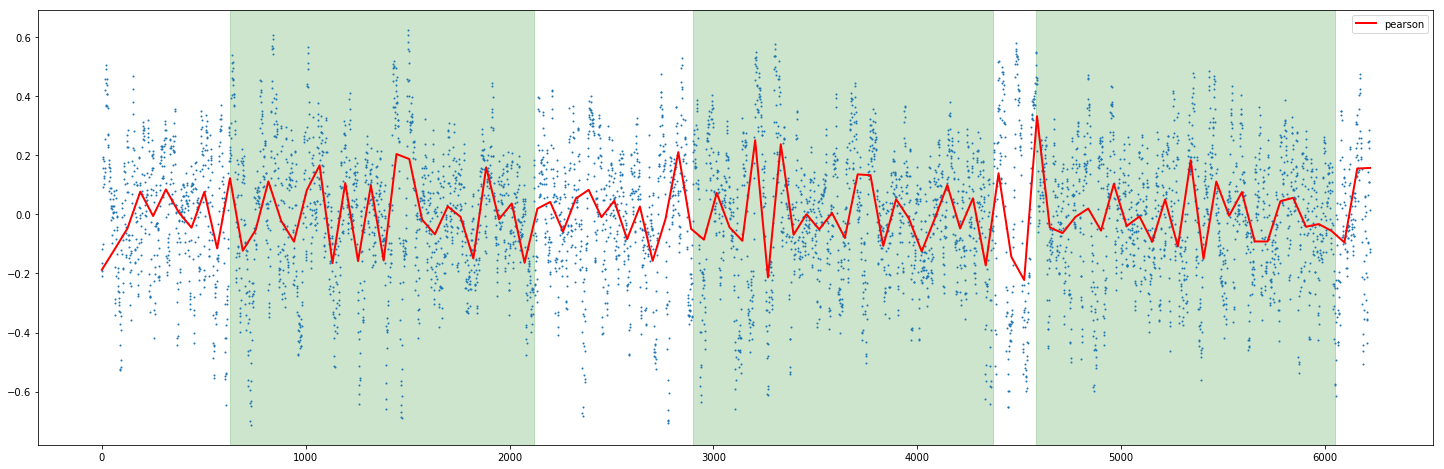

Max index:  1503 , max pearson:  0.625795227564219


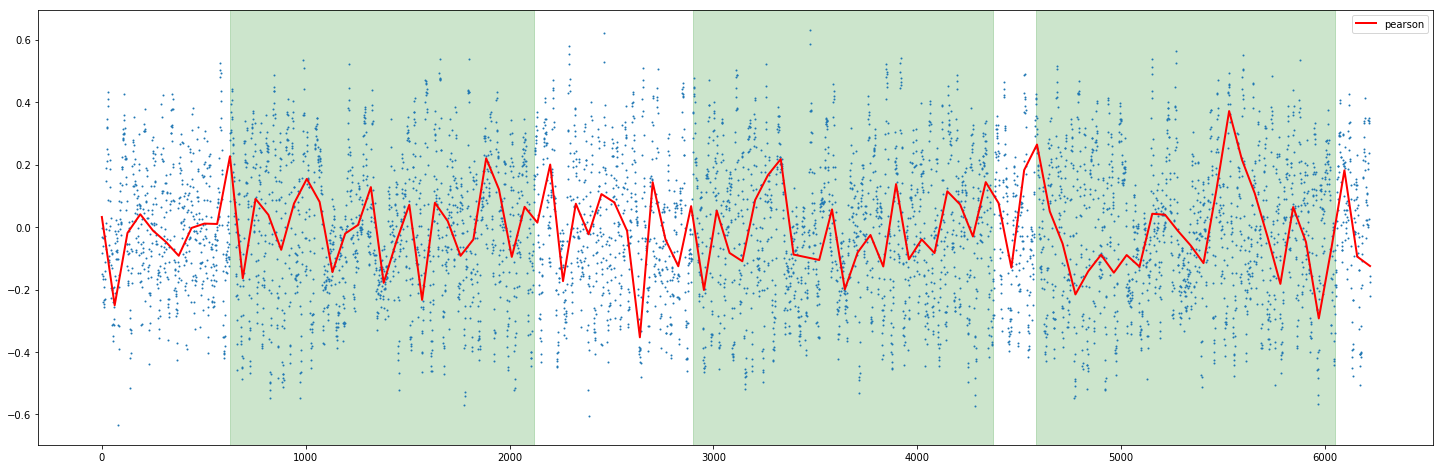

Max index:  3475 , max pearson:  0.6321087162331871


In [ ]:
plot_swc(neuro_spikes, max_sliced_pearson_corrs_r1[0], 50,
         start_round_frames[0] + (end_round_frames[0] - start_round_frames[0]) // 2)

plot_swc(neuro_spikes, max_sliced_pearson_corrs_r1[0], 50, 1000)

plot_swc(neuro_spikes, max_sliced_pearson_corrs_r1[0], 50, 1000, fix_activation = False)

window size: 50
auto_corrs size: 6222
loop size: 6222


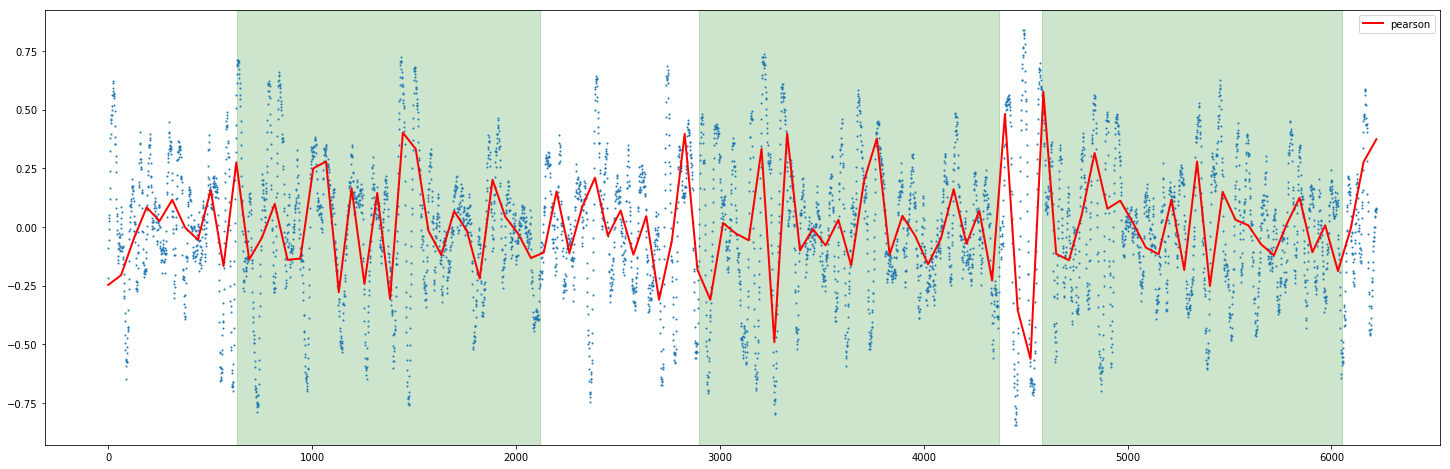

Max index:  4491 , max pearson:  0.8410560046245134


In [ ]:
plot_swc(neuro_spikes, activation_neurons, neuro_spikes, max_spearman_corr_r3, 50, 1000)

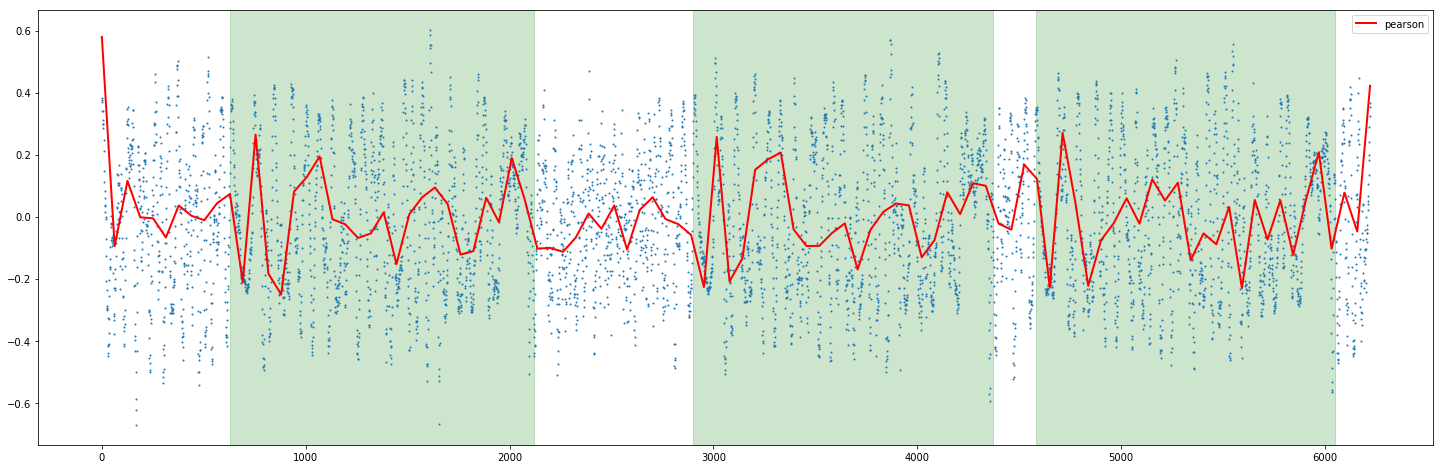

Max index:  1610 , max pearson:  0.6029089459314503


In [ ]:
plot_swc(neuro_spikes, max_spearman_corr_r3, 50, 1000, fix_activation = False)

__5 second windows seem to be too short. This could be just noise. Hence, a whole round is shifted in the following sections.__

#### Activations x Activations

__Sanity check: Correlate one round of an activation series with all same-length windows of the same activation series. The start of the chosen round should correlate to 1. Round starts are highlighted in green.__

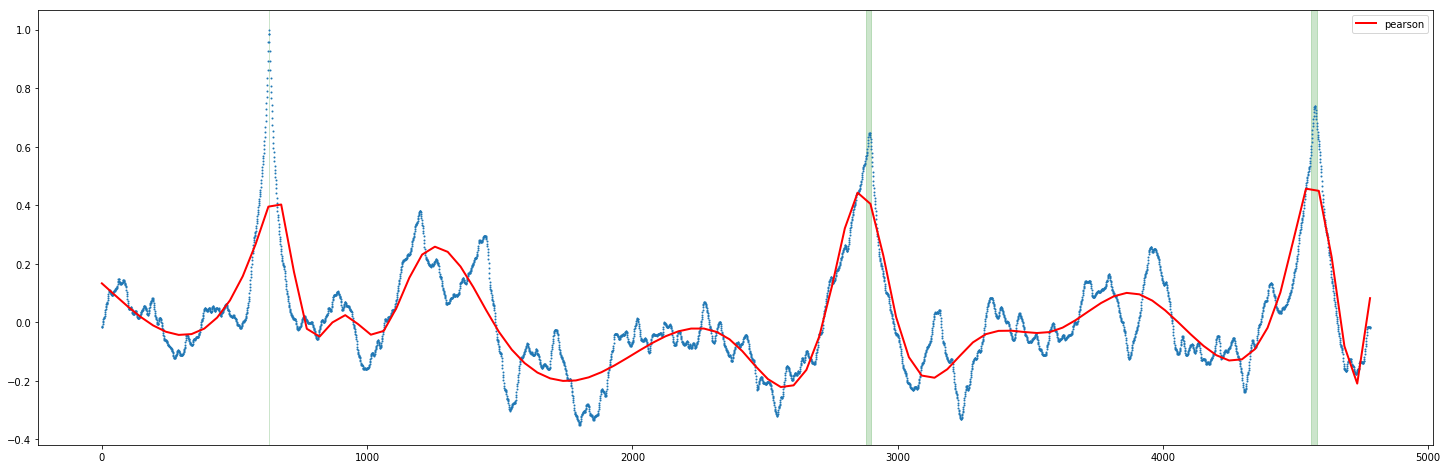

Max index:  630 , max pearson:  1.0


In [ ]:
window_size = end_round_frames[0] - start_round_frames[0]
start_frame_fixed_window = start_round_frames[0]

activation_series = max_pearson_round_1.get_activation_series(activations)

plot_swc(activation_series, max_pearson_round_1, window_size, start_frame_fixed_window, smooth_points = 100,
         smoothness = 40)

#### Correlations x Correlations

__Calculate sliding window correlations with whole rounds in time slices. This approach is like a sliding window correlation for the local analysis as investigated in previous sections.__

__First, correlations (A) of neuro spikes and and an activation are calculated during one flight round in 5 second windows. Then, all correlation sequences (B) are computed with the same amount of 5 second windows for the whole flight (and the same neuro spike and activation series). Lastly, A is correlated with every series of B.__

In [ ]:
def get_round_cross_correlations(windowed_corr_round, window_size, neuro_spikes):
    activation_series = windowed_corr_round.get_activation_series(activations)

    all_windowed_corrs = []
    round_corrs = windowed_corr_round.pearson

    for x in range(0, len(activation_series) - (window_size * len(round_corrs))):
        sequence_corrs = []
        for i in range(x, x + (window_size * len(round_corrs)), window_size):
            p = Correlation._pearson(activation_series[i : i + window_size], neuro_spikes[i : i + window_size])
            sequence_corrs.append(p)

        all_windowed_corrs.append(sequence_corrs)

    cross_corrs = []
    for windowed_corr in all_windowed_corrs:
        corr = Correlation.Correlation(-1, -1, -1, -1, -1)
        corr.calculate_pearson(round_corrs, windowed_corr)
        cross_corrs.append(corr)
        
    return cross_corrs

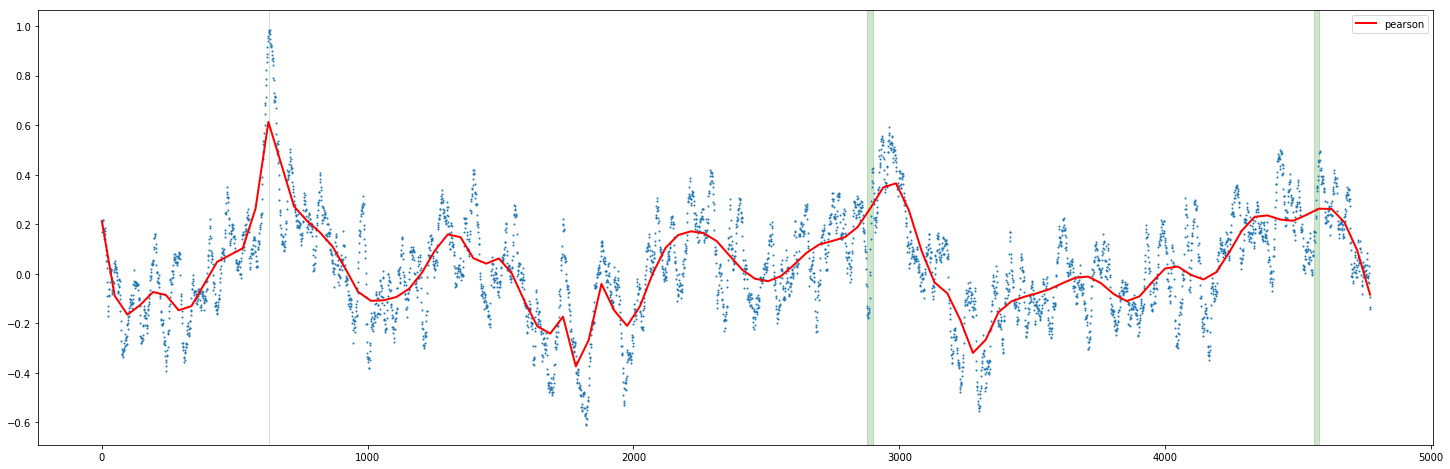

Max index:  629 , max pearson:  0.9856310254184817


In [ ]:
cross_corrs = get_round_cross_correlations(max_pearson_corr_r1, 50, neuro_spikes)
window_size = end_round_frames[0] - start_round_frames[0]

execute_plot_swc(cross_corrs, window_size, smooth_points = 100, smoothness = 80)

### Find activations with periodic patterns in SWCs

__In section 3.3.4.3 a sliding window correlation with time slices is presented. This can be used to find periodic patterns between activations and neuro spikes over the whole flight. In 3.3.4.3, the result for only one activation is shown. In this section, the same calculation is performed for all activations. Thereafter, distributions of all graphs are compared statistically since manual/visual comparison would be too laborious. The optimal correlation graph would show high correlations when flight rounds are compared and low correlations on overlapping sliding window correlations.__

__The calculation of all distributions is very time consuming. If Linux is used the computation is divided onto 8 cpu threads while on windows this is not possible and hence everything is computed sequentially. See function "test_distributions" of module "DistributionTest".__

In [ ]:
window_size = 20

corrs_slices_20_round_1 = Correlation.correlate(activations, neuro_spikes, start_frame = start_round_frames[0],
                                                end_frame = start_round_frames[0] + 60, window_size = window_size,
                                                pearson = True, spearman = False)

entry_count:  137728 , windows:  3 , window_size:  20


In [ ]:
# needed if Correlation.correlate was computed on gpu:

tmp = [[] for layer_num in range(18)]

for corr in corrs_slices_20_round_1:
    tmp[corr.layer].append(corr)
    
corrs_slices_20_round_1 = tmp

Calculate patterns:

In [ ]:
patterns = test_distributions(corrs_slices_20_round_1, activations, neuro_spikes, window_size, start_round_frames,
                              exclude_start_frame_num = 0)

Or load saved patterns:

In [ ]:
patterns = []
for i in range(18):
    layer_patterns = load_object(Utils.get_path(["02_autoencoder", "patterns"],
                                                "pattern_parts_layer_" + str(i) + ".dill"), True)
    
    for pid in range(8):
        patterns.extend(layer_patterns[pid])
        
# class attributes were changed after saving the objects and must be updated as follows for further computations:
for distrTest in patterns:
    distrTest.filter_num = distrTest.activation
    distrTest.col = distrTest.column

__If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions
of the two samples are the same.__
(https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html)

__Here distributions should not be the same!__

In [ ]:
ks_p_sorted = sorted(patterns, key=attrgetter('ks_p'), reverse=False)
ks_statistic_sorted = sorted(patterns, key=attrgetter('ks_statistic'), reverse=True)

In [ ]:
for i in range(10):
    print(ks_p_sorted[i].get_infos())

layer 2, activation 3, row 12, column 21, ks_statistic 0.6101342281879194, ks_p 5.24959280543542e-120, mw_statistic 202797.0, mw_p 9.744110769613352e-139
layer 5, activation 9, row 13, column 21, ks_statistic 0.5765484180249281, ks_p 3.332904371790914e-107, mw_statistic 199657.0, mw_p 4.25471460390923e-140
layer 4, activation 9, row 13, column 21, ks_statistic 0.5755560882070949, ks_p 7.763730607099772e-107, mw_statistic 200110.0, mw_p 6.690687171775126e-140
layer 4, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234325.0, mw_p 1.863331206814104e-125
layer 5, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234305.0, mw_p 1.8284354124496056e-125
layer 4, activation 12, row 13, column 22, ks_statistic 0.5668791946308726, ks_p 1.1866395301949682e-103, mw_statistic 274744.0, mw_p 2.0233993609923062e-109
layer 5, activation 12, row 13, column 22, ks_statistic 0.565337

In [ ]:
for i in range(10):
    print(ks_statistic_sorted[i].get_infos())

layer 2, activation 3, row 12, column 21, ks_statistic 0.6101342281879194, ks_p 5.24959280543542e-120, mw_statistic 202797.0, mw_p 9.744110769613352e-139
layer 5, activation 9, row 13, column 21, ks_statistic 0.5765484180249281, ks_p 3.332904371790914e-107, mw_statistic 199657.0, mw_p 4.25471460390923e-140
layer 4, activation 9, row 13, column 21, ks_statistic 0.5755560882070949, ks_p 7.763730607099772e-107, mw_statistic 200110.0, mw_p 6.690687171775126e-140
layer 4, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234325.0, mw_p 1.863331206814104e-125
layer 5, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234305.0, mw_p 1.8284354124496056e-125
layer 4, activation 12, row 13, column 22, ks_statistic 0.5668791946308726, ks_p 1.1866395301949682e-103, mw_statistic 274744.0, mw_p 2.0233993609923062e-109
layer 5, activation 12, row 13, column 22, ks_statistic 0.565337

__Activations of ks_p_sorted and ks_statistic_sorted are in the same order. That is why only ks_p_sorted is used in the following.__

In [ ]:
for distrTest in ks_p_sorted[:20]:
    fig = Visualizer.show_correlation(distrTest, start_round_frames[0] + 780, model_loader,
                                      model_loader.model.encoder)
    Utils.add_fig_to_image(fig)
    
Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"], "pattern_matches_high_ks.jpg"))

In [ ]:
def plot_distr_test_result(distrTest, smooth_points, smoothness):
    highlight = [start_round_frames[0], end_round_frames[0],
                 start_round_frames[1], end_round_frames[1],
                 start_round_frames[2], end_round_frames[2]]

    activation_series = activations[distrTest.layer][distrTest.filter_num][distrTest.row][distrTest.col]
    neuro_spikes_norm = neuro_spikes / np.max(neuro_spikes)
    
    Visualizer.plot([neuro_spikes_norm, activation_series], labels = ["neuro spikes", "activations"],
                    highlight_regions = highlight, smooth_points = smooth_points, smoothness = smoothness,
                    show_unsmoothed_points = False)

layer 5, activation 9, row 13, column 21, ks_statistic 0.5795701502077342, ks_p 3.825999801089039e-155, mw_statistic 293452.0, mw_p 7.858839758179436e-203


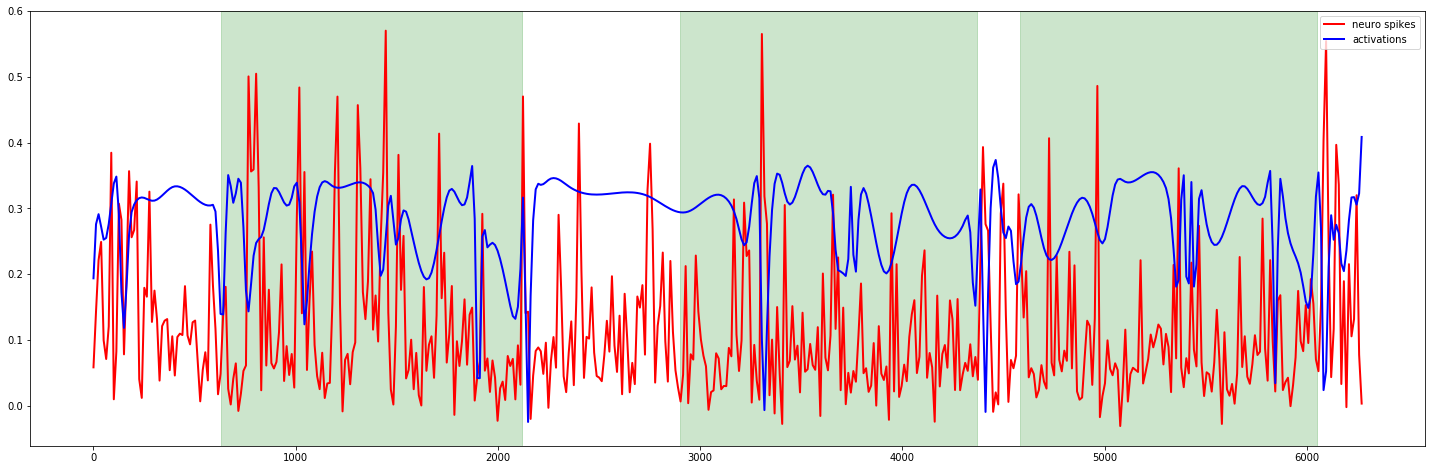

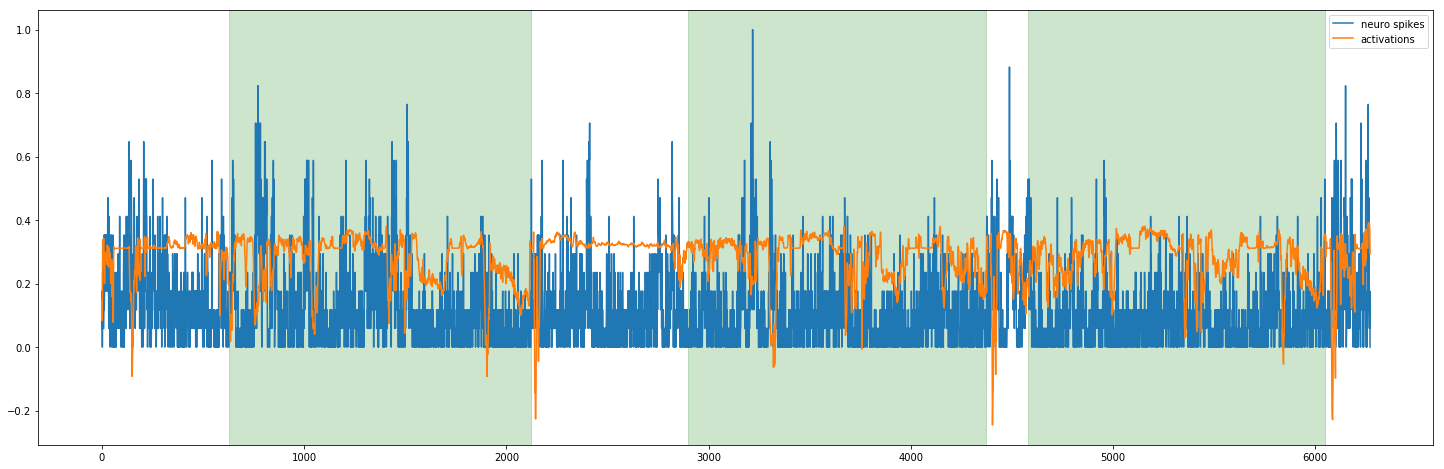

In [ ]:
i = 7

print(ks_p_sorted[i].get_infos())
plot_distr_test_result(ks_p_sorted[i], 500, 10)
plot_distr_test_result(ks_p_sorted[i], -1, -1)

In [ ]:
mw_p_sorted = sorted(patterns, key=attrgetter('mw_p'), reverse=False)
mw_statistic_sorted = sorted(patterns, key=attrgetter('mw_statistic'), reverse=False)

In [ ]:
for i in range(10):
    print(mw_p_sorted[i].get_infos())

layer 5, activation 9, row 13, column 21, ks_statistic 0.5765484180249281, ks_p 3.332904371790914e-107, mw_statistic 199657.0, mw_p 4.25471460390923e-140
layer 4, activation 9, row 13, column 21, ks_statistic 0.5755560882070949, ks_p 7.763730607099772e-107, mw_statistic 200110.0, mw_p 6.690687171775126e-140
layer 2, activation 3, row 12, column 21, ks_statistic 0.6101342281879194, ks_p 5.24959280543542e-120, mw_statistic 202797.0, mw_p 9.744110769613352e-139
layer 5, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234305.0, mw_p 1.8284354124496056e-125
layer 4, activation 15, row 11, column 22, ks_statistic 0.5697866730584851, ks_p 1.0297223024990353e-104, mw_statistic 234325.0, mw_p 1.863331206814104e-125
layer 14, activation 20, row 0, column 3, ks_statistic 0.5563087248322147, ks_p 7.728897168343434e-100, mw_statistic 240598.0, mw_p 6.792616592973431e-123
layer 15, activation 20, row 0, column 3, ks_statistic 0.5563087248

In [ ]:
for i in range(10):
    print(mw_statistic_sorted[i].get_infos())

layer 0, activation 0, row 0, column 0, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 1, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 2, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 3, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 4, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 5, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 6, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 7, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 8, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1
layer 0, activation 0, row 0, column 9, ks_statistic 0.0, ks_p 1.0, mw_statistic 0, mw_p 1


__Again, only mw_p_sorted is used in the following because activations of mw_p_sorted and mw_statistic_sorted are in the same order.__

__But both lists are ordered ascending!__

In [ ]:
for distrTest in mw_p_sorted[:20]:
    fig = Visualizer.show_correlation(distrTest, start_round_frames[0] + 780, model_loader,
                                      model_loader.model.encoder)
    Utils.add_fig_to_image(fig)
    
Utils.save_combined_image(Utils.get_path(["02_autoencoder", "results"], "pattern_matches_high_mw.jpg"))

layer 4, activation 9, row 13, column 21, ks_statistic 0.5779194630872483, ks_p 2.902707902188072e-154, mw_statistic 293874.0, mw_p 1.1799944505287507e-202


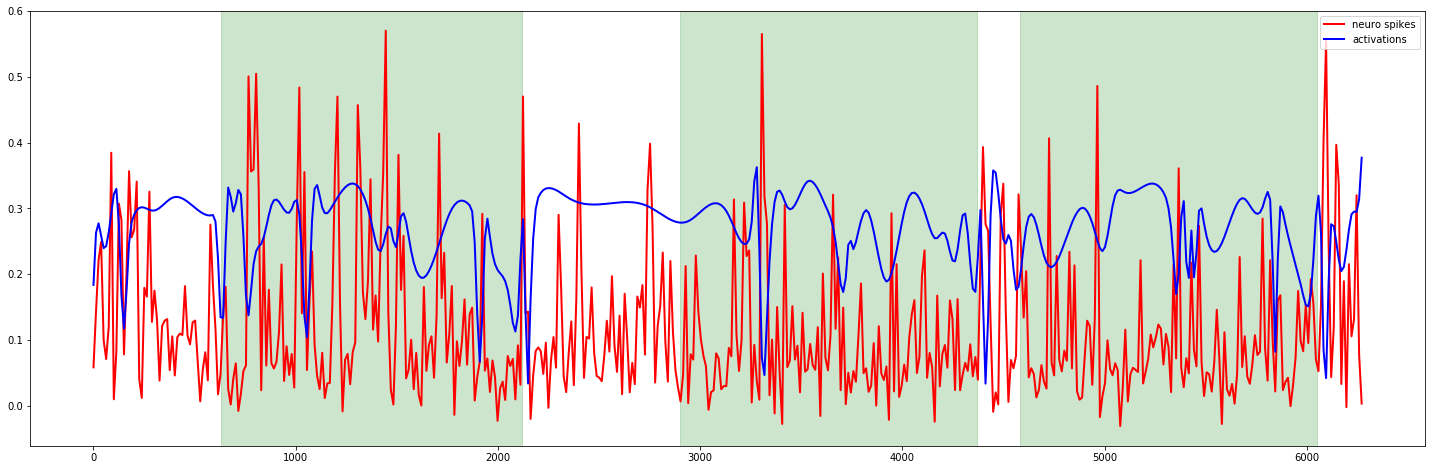

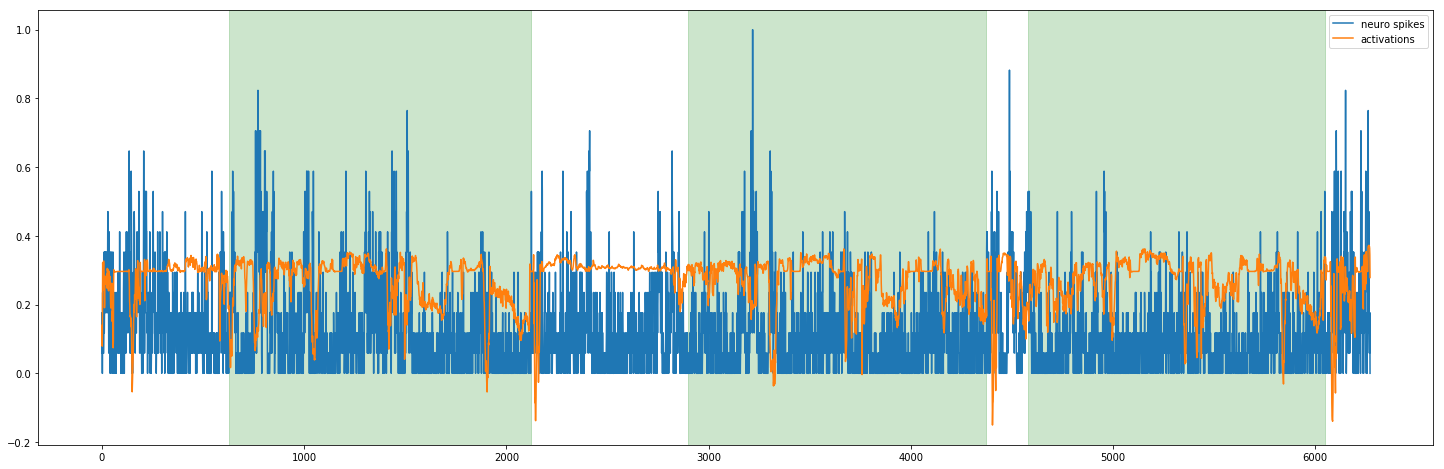

In [ ]:
i = 4

print(mw_p_sorted[i].get_infos())
plot_distr_test_result(mw_p_sorted[i], 500, 10)
plot_distr_test_result(mw_p_sorted[i], -1, -1)

__Conclusion:__

__1. Results for KS test and Rangsum test are similar.__

__2. Activations whose distributions differ strongly (= small p-value) between rounds and noise (= overlapping of round and waiting time) are located at the horizon (= transition from the field to the grey background).__